In [4]:
import ast
from collections import defaultdict
from pathlib import Path
from typing import Literal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    roc_auc_score,
    balanced_accuracy_score,
)


def read_res(
    data,
    model,
    trainer,
    data_path,
    base_path=Path("/data/home/shubi/Cognitive-State-Decoding"),
    base_res_path="cross_validation_runs",
    wandb_job_type="cv",
    template="{}/+data={},+data_path={},+model={},+trainer={},trainer.wandb_job_type={}",
    on_error="raise",
) -> pd.DataFrame | None:
    file_path = (
        base_path
        / template.format(
            base_res_path, data, data_path, model, trainer, wandb_job_type
        )
        / "trial_level_test_results.csv"
    )
    try:
        res = pd.read_csv(file_path, index_col=0)
    except FileNotFoundError as e:
        print(f"File not found: {file_path}")
        if on_error == "raise":
            raise e
        else:
            return None
    return res


def convert_string_to_list(s: pd.Series) -> list[list[float]]:
    return s.apply(ast.literal_eval).tolist()


def raw_res_to_metric(
    res: pd.DataFrame,
    avg: Literal["micro", "macro", "samples", "weighted"] | None = "micro",
    mode: Literal[
        "auroc", "accuracy", "binary_accuracy", "balanced_accuracy"
    ] = "auroc",
    dummy: bool = False,  # majority class prediction
) -> pd.DataFrame:
    # grouped_res = res.groupby(["eval_regime", "fold_index"])
    grouped_res = res.groupby(["eval_regime"])
    # grouped_res = res.groupby(["fold_index"])
    res_df = defaultdict(list)
    # for (eval_type, fold_index), group_data in grouped_res:
    for (eval_type,), group_data in grouped_res:
        # for (fold_index,), group_data in grouped_res:
        labels = group_data["label"].tolist()
        if dummy:
            assert mode != "auroc", "dummy mode does not support auroc"
            y_pred = [1] * len(labels)
        else:
            preds = group_data["prediction_prob"]
            if preds.dtype == "object":
                preds = convert_string_to_list(preds)
                y_pred = np.array(preds).argmax(axis=1)
            else:
                y_pred = group_data["y_pred"]
        if mode == "auroc":
            try:
                auroc = roc_auc_score(
                    y_true=labels, y_score=preds, average=avg, multi_class="ovr"
                )
            except ValueError:
                print(
                    # f"No labels of each class in {eval_type.replace("_", " ").capitalize()}, {fold_index=}. setting auroc to 0"
                    #     f"No labels of each class in {eval_type.replace("_", " ").capitalize()}. setting auroc to 0"
                )
                auroc = 0
            measure = round(auroc, 3)
        elif mode == "accuracy":
            accuracy = accuracy_score(y_true=labels, y_pred=y_pred)
            measure = round(accuracy, 3)
        elif mode == "binary_accuracy":
            binary_label = [1 if x == 1 else 0 for x in labels]
            binary_pred = [1 if x == 1 else 0 for x in y_pred]
            accuracy = accuracy_score(y_true=binary_label, y_pred=binary_pred)
            measure = round(accuracy, 3)
        elif mode == "balanced_accuracy":
            accuracy = balanced_accuracy_score(y_true=labels, y_pred=y_pred)
            # c = cls_metrics.MulticlassAccuracy(num_classes=2, average="macro")
            # tm_accuracy = c(torch.tensor(y_pred.values), torch.tensor(labels)).item()
            # tm_accuracy = c(torch.tensor(y_pred), torch.tensor(labels)).item()
            # if round(tm_accuracy, 5) != round(accuracy, 5):
            #     print(f"{tm_accuracy=}, {accuracy=}")
            #     raise ValueError
            measure = round(accuracy, 5)

        res_df[eval_type].append(measure)
        # res_df['all'].append(measure)

    df = pd.DataFrame(
        res_df.items(),
        columns=["Eval Regime", mode],
    ).set_index("Eval Regime")

    new_order = ["new_item", "new_subject", "new_item_and_subject"]
    df = df.reindex(new_order, level="Eval Regime")

    # df = pd.DataFrame(
    #     res_df.items(),
    #             columns=["Eval Regime", mode],

    # ).set_index("Eval Regime")
    return df


def raw_res_to_metric_all(
    res: pd.DataFrame,
    avg: Literal["micro", "macro", "samples", "weighted"] | None = "micro",
    mode: Literal[
        "auroc", "accuracy", "binary_accuracy", "balanced_accuracy"
    ] = "auroc",
    dummy: bool = False,  # majority class prediction
) -> pd.DataFrame:
    res_df = defaultdict(list)
    labels = res["label"].tolist()
    if dummy:
        assert mode != "auroc", "dummy mode does not support auroc"
        y_pred = [1] * len(labels)
    else:
        preds = res["prediction_prob"]
        if preds.dtype == "object":
            preds = convert_string_to_list(preds)
            y_pred = np.array(preds).argmax(axis=1)
        else:
            y_pred = res["y_pred"]

    accuracy = balanced_accuracy_score(y_true=labels, y_pred=y_pred)
    measure = round(accuracy, 5)

    res_df["all"].append(measure)

    df = pd.DataFrame(
        res_df.items(),
        columns=["Eval Regime", mode],
    ).set_index("Eval Regime")

    # new_order = ["new_item", "new_subject", "new_item_and_subject"]
    # df = df.reindex(new_order, level="Eval Regime")

    return df


def aggregate_df(
    res_df: pd.DataFrame,
    metric_name: str,
    columns: list[str] = ["new_item", "new_subject", "new_item_and_subject"],
) -> pd.DataFrame:
    res_df = res_df.copy()
    for col in columns:
        avg_col = f"Avg {metric_name} {col}"
        std_col = f"Std {metric_name} {col}"
        res_df[avg_col] = res_df[col].apply(np.mean)
        res_df[std_col] = res_df[col].apply(np.std)
        res_df[avg_col] = (100 * res_df[avg_col]).round(1)
        res_df[std_col] = (100 * res_df[std_col]).round(1)
        res_df[f"{metric_name} {col}".replace("_", " ").capitalize()] = res_df.apply(
            # lambda x: f"{x[avg_col]} ± {x[std_col]}", axis=1
            lambda x: f"{x[avg_col]}",
            axis=1,
        )
        res_df = res_df.drop([col, avg_col, std_col], axis=1)
    return res_df

## May Results

In [5]:
models = {
    "Baseline - Always A": "Roberta",
    "Baseline - RoBERTaNoEyes": "Roberta",
    "MAG": "MAG",
    "RoberteyeWord": "RoberteyeWord",
    "RoBERTeyeFixation": "RoberteyeFixation",
    "PostFusion": "PostFusion",
    "BEyeLSTM": "BEyeLSTMArgs",
    "AhnCNN": "AhnCNN",
    "LR": "LR",
    "RobertaSelectedAnswersMultiClass": "RobertaSelectedAnswersMultiClass",
    "PostFusionSelectedAnswersMultiClass": "PostFusionSelectedAnswersMultiClass",
    "MAGSelectedAnswersMultiClass": "MAGSelectedAnswersMultiClass",
    "KNN": "KNN",
    "SVM": "SVM",
    "PostFusionAnswers": "PostFusionAnswers",
    "PostFusionMultiClass": "PostFusionMultiClass",
    "PostFusionAnswersMultiClass": "PostFusionAnswersMultiClass",
}

all_res = defaultdict(dict)
for model, model_name in models.items():
    trainer = "IsCorrectSampling"
    if model == "BEyeLSTM":
        trainer = "BEyeLSTM"
    if model == "AhnCNN":
        trainer = "Ahn"
    if model in ["LR", "KNN", "SVM"]:
        trainer = "ML"

    for data_ in ["Hunting", "Gathering"]:
        res = read_res(
            data=data_,
            model=model_name,
            trainer=trainer,
            data_path="may05",
            wandb_job_type=f"hyperparameter_sweep_{model_name}",
            base_res_path="emnlp24_results",
            on_error="continue",
            base_path=Path("/data/home/shubi/Cognitive-State-Decoding"),
        )
        if res is None:
            print(f"{model} - {data_} no found")
            continue
        else:
            print(f"Found {model} - {data_}")
            # print(model, data_, res.value_counts(subset=["eval_regime", "eval_type", "fold_index"],sort=False))
            if res["prediction_prob"].dtype == "object":
                preds = convert_string_to_list(res["prediction_prob"])
                y_pred = np.array(preds).argmax(axis=1)
            else:
                preds = res["prediction_prob"]
                # over or less than 0.5
                y_pred = (preds > 0.5).astype(int)
            res["y_pred"] = y_pred
            all_res[data_][model] = res

Found Baseline - Always A - Hunting
Found Baseline - Always A - Gathering
Found Baseline - RoBERTaNoEyes - Hunting
Found Baseline - RoBERTaNoEyes - Gathering
Found MAG - Hunting
Found MAG - Gathering
Found RoberteyeWord - Hunting
Found RoberteyeWord - Gathering
Found RoBERTeyeFixation - Hunting
Found RoBERTeyeFixation - Gathering
Found PostFusion - Hunting
Found PostFusion - Gathering
Found BEyeLSTM - Hunting
Found BEyeLSTM - Gathering
File not found: /data/home/shubi/Cognitive-State-Decoding/emnlp24_results/+data=Hunting,+data_path=may05,+model=AhnCNN,+trainer=Ahn,trainer.wandb_job_type=hyperparameter_sweep_AhnCNN/trial_level_test_results.csv
AhnCNN - Hunting no found
File not found: /data/home/shubi/Cognitive-State-Decoding/emnlp24_results/+data=Gathering,+data_path=may05,+model=AhnCNN,+trainer=Ahn,trainer.wandb_job_type=hyperparameter_sweep_AhnCNN/trial_level_test_results.csv
AhnCNN - Gathering no found
File not found: /data/home/shubi/Cognitive-State-Decoding/emnlp24_results/+data=

In [6]:
metric_names = [
    # "auroc",
    #             "accuracy",
    #             "binary_accuracy",
    "balanced_accuracy"
]
metrics = {name: [] for name in metric_names}

for data_, data_res in all_res.items():
    for model, res in data_res.items():
        for eval_type in ["test", "val"]:
            res_val = res[res["eval_type"] == eval_type]
            for metric_name in metric_names:
                if model == "Baseline - Always A":
                    if metric_name == "auroc":
                        continue
                    dummy_flag = True
                else:
                    dummy_flag = False
                metric_val = raw_res_to_metric_all(
                    res=res_val,
                    avg="macro",
                    mode=metric_name,  # type: ignore
                    dummy=dummy_flag,
                )
                metric_val = metric_val[[metric_name]].T

                metric_val.index = pd.MultiIndex.from_tuples(
                    [(model, data_)], names=["Model", "Data"]
                )
                metric_val["Eval Type"] = eval_type
                metrics[metric_name].append(metric_val)

            # labels = res_val["label"].tolist()
            # preds = res_val["prediction_prob"]
            # if preds.dtype == "object":
            #     preds = convert_string_to_list(preds)
            #     y_pred = np.array(preds).argmax(axis=1)
            # else:
            #     y_pred = res_val["y_pred"]
            # accuracy = balanced_accuracy_score(y_true=labels, y_pred=y_pred)

            # print(data_, model, eval_type, accuracy)

res_dfs = {
    name: pd.concat(metrics[name])
    .swaplevel()
    .reset_index()
    .set_index(["Eval Type", "Data", "Model"])
    .sort_index(level=["Eval Type", "Data", "Model"], ascending=[False, True, True])
    for name in metric_names
}


metric = (
    "balanced_accuracy"  # "auroc", "accuracy", "binary_accuracy", "balanced_accuracy"
)
all = aggregate_df(res_dfs[metric], metric, columns=["all"])
# display(all)

In [7]:
metric_names = [
    # "auroc",
    #             "accuracy",
    #             "binary_accuracy",
    "balanced_accuracy"
]
metrics = {name: [] for name in metric_names}

for data_, data_res in all_res.items():
    for model, res in data_res.items():
        for eval_type in ["test", "val"]:
            res_val = res[res["eval_type"] == eval_type]
            for metric_name in metric_names:
                if model == "Baseline - Always A":
                    if metric_name == "auroc":
                        continue
                    dummy_flag = True
                else:
                    dummy_flag = False
                metric_val = raw_res_to_metric(
                    res=res_val,
                    avg="macro",
                    mode=metric_name,  # type: ignore
                    dummy=dummy_flag,
                )
                metric_val = metric_val[[metric_name]].T

                metric_val.index = pd.MultiIndex.from_tuples(
                    [(model, data_)], names=["Model", "Data"]
                )
                metric_val["Eval Type"] = eval_type
                metrics[metric_name].append(metric_val)

            # labels = res_val["label"].tolist()
            # preds = res_val["prediction_prob"]
            # if preds.dtype == "object":
            #     preds = convert_string_to_list(preds)
            #     y_pred = np.array(preds).argmax(axis=1)
            # else:
            #     y_pred = res_val["y_pred"]
            # accuracy = balanced_accuracy_score(y_true=labels, y_pred=y_pred)

            # print(data_, model, eval_type, accuracy)

res_dfs = {
    name: pd.concat(metrics[name])
    .swaplevel()
    .reset_index()
    .set_index(["Eval Type", "Data", "Model"])
    .sort_index(level=["Eval Type", "Data", "Model"], ascending=[False, True, True])
    for name in metric_names
}


metric = (
    "balanced_accuracy"  # "auroc", "accuracy", "binary_accuracy", "balanced_accuracy"
)
# display(res_dfs[metric])
regime = aggregate_df(res_dfs[metric], metric)
# display(regime)

In [8]:
all_results = regime.merge(all, left_index=True, right_index=True)
model_order = [
    "Baseline - Always A",
    "Baseline - RoBERTaNoEyes",
    "LR",
    "AhnCNN",
    "BEyeLSTM",
    "Eyettention",
    "MAG",
    "RoberteyeWord",
    "RoBERTeyeFixation",
    "PostFusion",
    "RobertaSelectedAnswersMultiClass",
    "MAGSelectedAnswersMultiClass",
    "PostFusionSelectedAnswersMultiClass",
    "KNN",
    "SVM",
    "PostFusionAnswers",
    "PostFusionAnswersMultiClass",
    "PostFusionMultiClass",
]
all_results = all_results.reindex(model_order, level="Model")
# Strip "Balanced accuracy" from the column names
all_results.columns = all_results.columns.str.replace("Balanced accuracy ", "")
all_results

Eval Regime                                             new item new subject  \
Eval Type Data      Model                                                      
val       Gathering Baseline - Always A                     50.0        50.0   
                    Baseline - RoBERTaNoEyes                59.8        65.8   
                    BEyeLSTM                                55.0        58.5   
                    MAG                                     60.4        65.8   
                    RoberteyeWord                           57.0        65.5   
                    RoBERTeyeFixation                       57.0        63.5   
                    PostFusion                              60.1        65.2   
                    RobertaSelectedAnswersMultiClass        25.7        35.7   
                    MAGSelectedAnswersMultiClass            33.8        36.1   
                    PostFusionSelectedAnswersMultiClass     33.2        35.1   
                    PostFusionAnswers                       60.3        65.6   
                    PostFusionAnswersMultiClass             27.1        37.0   
                    PostFusionMultiClass                    26.7        36.8   
          Hunting   Baseline - Always A                     50.0        50.0   
                    Baseline - RoBERTaNoEyes                57.1        65.1   
                    BEyeLSTM                                57.3        58.6   
                    MAG                                     57.3        66.0   
                    RoberteyeWord                           55.3        64.7   
                    RoBERTeyeFixation                       54.6        62.4   
                    PostFusion                              58.3        65.8   
                    RobertaSelectedAnswersMultiClass        25.0        34.4   
                    MAGSelectedAnswersMultiClass            34.8        33.6   
                    PostFusionSelectedAnswersMultiClass     34.0        31.8   
                    PostFusionAnswers                       58.2        66.1   
                    PostFusionAnswersMultiClass             26.2        35.4   
                    PostFusionMultiClass                    26.0        34.4   
test      Gathering Baseline - Always A                     50.0        50.0   
                    Baseline - RoBERTaNoEyes                54.8        63.1   
                    BEyeLSTM                                50.6        55.7   
                    MAG                                     54.8        64.1   
                    RoberteyeWord                           55.5        63.5   
                    RoBERTeyeFixation                       53.3        61.3   
                    PostFusion                              54.8        63.5   
                    RobertaSelectedAnswersMultiClass        25.3        33.0   
                    MAGSelectedAnswersMultiClass            27.9        32.5   
                    PostFusionSelectedAnswersMultiClass     29.4        31.7   
                    PostFusionAnswers                       56.7        62.7   
                    PostFusionAnswersMultiClass             25.4        33.6   
                    PostFusionMultiClass                    27.1        33.2   
          Hunting   Baseline - Always A                     50.0        50.0   
                    Baseline - RoBERTaNoEyes                51.8        63.1   
                    BEyeLSTM                                50.5        55.1   
                    MAG                                     52.5        62.3   
                    RoberteyeWord                           50.5        63.8   
                    RoBERTeyeFixation                       50.3        60.3   
                    PostFusion                              53.8        62.7   
                    RobertaSelectedAnswersMultiClass        25.0        31.7   
                    MAGSelectedAnswersMultiClass            26.8        30.0   


In [9]:
all_results.columns

Index(['new item', 'new subject', 'new item and subject', 'all'], dtype='object', name='Eval Regime')

In [37]:
a = all_results.reset_index()
a[a["Eval Type"] == "test"].to_latex()  # .query("'Eval Type' == 'test'").to_latex()

'\\begin{tabular}{llllllll}\n\\toprule\nEval Regime & Eval Type & Data & Model & new item & new subject & new item and subject & all \\\\\n\\midrule\n22 & test & Gathering & Baseline - Always A & 50.0 & 50.0 & 50.0 & 50.0 \\\\\n23 & test & Gathering & Baseline - RoBERTaNoEyes & 54.8 & 63.1 & 55.2 & 58.7 \\\\\n24 & test & Gathering & KNN & 50.9 & 49.5 & 49.9 & 50.2 \\\\\n25 & test & Gathering & SVM & 54.3 & 50.8 & 51.2 & 52.5 \\\\\n26 & test & Gathering & LR & 53.3 & 50.8 & 53.8 & 52.2 \\\\\n27 & test & Gathering & AhnCNN & 51.0 & 51.0 & 51.9 & 51.1 \\\\\n28 & test & Gathering & BEyeLSTM & 50.6 & 55.7 & 51.1 & 53.0 \\\\\n29 & test & Gathering & MAG & 54.8 & 64.1 & 53.8 & 59.2 \\\\\n30 & test & Gathering & RoberteyeWord & 55.5 & 63.5 & 52.1 & 59.1 \\\\\n31 & test & Gathering & RoBERTeyeFixation & 53.3 & 61.3 & 57.1 & 57.3 \\\\\n32 & test & Gathering & PostFusion & 54.8 & 63.5 & 55.0 & 58.9 \\\\\n33 & test & Hunting & Baseline - Always A & 50.0 & 50.0 & 50.0 & 50.0 \\\\\n34 & test & Hunti

In [17]:
reset_results = all_results.reset_index()
reset_results

Eval Regime,Eval Type,Data,Model,new item,new subject,new item and subject,all
0,val,Gathering,Baseline - Always A,50.0,50.0,50.0,50.0
1,val,Gathering,Baseline - RoBERTaNoEyes,59.8,65.8,57.9,62.5
2,val,Gathering,MAG,60.4,65.8,58.9,62.9
3,val,Gathering,RoberteyeWord,57.0,65.5,60.5,61.2
4,val,Gathering,RoBERTeyeFixation,57.0,63.5,60.4,60.3
5,val,Gathering,PostFusion,60.1,65.2,60.4,62.5
6,val,Hunting,Baseline - Always A,50.0,50.0,50.0,50.0
7,val,Hunting,Baseline - RoBERTaNoEyes,57.1,65.1,56.8,60.8
8,val,Hunting,MAG,57.3,66.0,59.5,61.6
9,val,Hunting,RoberteyeWord,55.3,64.7,52.2,59.6


In [66]:
wide_results = reset_results.pivot(
    columns="Data", values="all", index=["Eval Type", "Model"]
)
wide_results

Data                               Gathering Hunting
Eval Type Model                                     
test      BEyeLSTM                      53.0    53.0
          Baseline - Always A           50.0    50.0
          Baseline - RoBERTaNoEyes      58.7    57.1
          MAG                           59.2    57.1
          PostFusion                    58.9    58.0
          RoBERTeyeFixation             57.3    55.1
          RoberteyeWord                 59.1    56.8
val       BEyeLSTM                      56.7    58.0
          Baseline - Always A           50.0    50.0
          Baseline - RoBERTaNoEyes      62.5    60.8
          MAG                           62.9    61.6
          PostFusion                    62.5    61.9
          RoBERTeyeFixation             60.3    58.4
          RoberteyeWord                 61.2    59.6

In [68]:
# compute mean for Gathering and hunting
(wide_results["Gathering"].astype(float) + wide_results["Hunting"].astype(float)) / 2

Eval Type  Model                   
test       BEyeLSTM                    53.00
           Baseline - Always A         50.00
           Baseline - RoBERTaNoEyes    57.90
           MAG                         58.15
           PostFusion                  58.45
           RoBERTeyeFixation           56.20
           RoberteyeWord               57.95
val        BEyeLSTM                    57.35
           Baseline - Always A         50.00
           Baseline - RoBERTaNoEyes    61.65
           MAG                         62.25
           PostFusion                  62.20
           RoBERTeyeFixation           59.35
           RoberteyeWord               60.40
dtype: float64

Data: Hunting
i=0 model1='Baseline - RoBERTaNoEyes', j=1 MAG
i=0 model1='Baseline - RoBERTaNoEyes', j=2 PostFusion
i=0 model1='Baseline - RoBERTaNoEyes', j=3 RoBERTeyeFixation
i=0 model1='Baseline - RoBERTaNoEyes', j=4 RoBERTeyeIA
i=1 model1='MAG', j=2 PostFusion
i=1 model1='MAG', j=3 RoBERTeyeFixation
i=1 model1='MAG', j=4 RoBERTeyeIA
i=2 model1='PostFusion', j=3 RoBERTeyeFixation
i=2 model1='PostFusion', j=4 RoBERTeyeIA
i=3 model1='RoBERTeyeFixation', j=4 RoBERTeyeIA


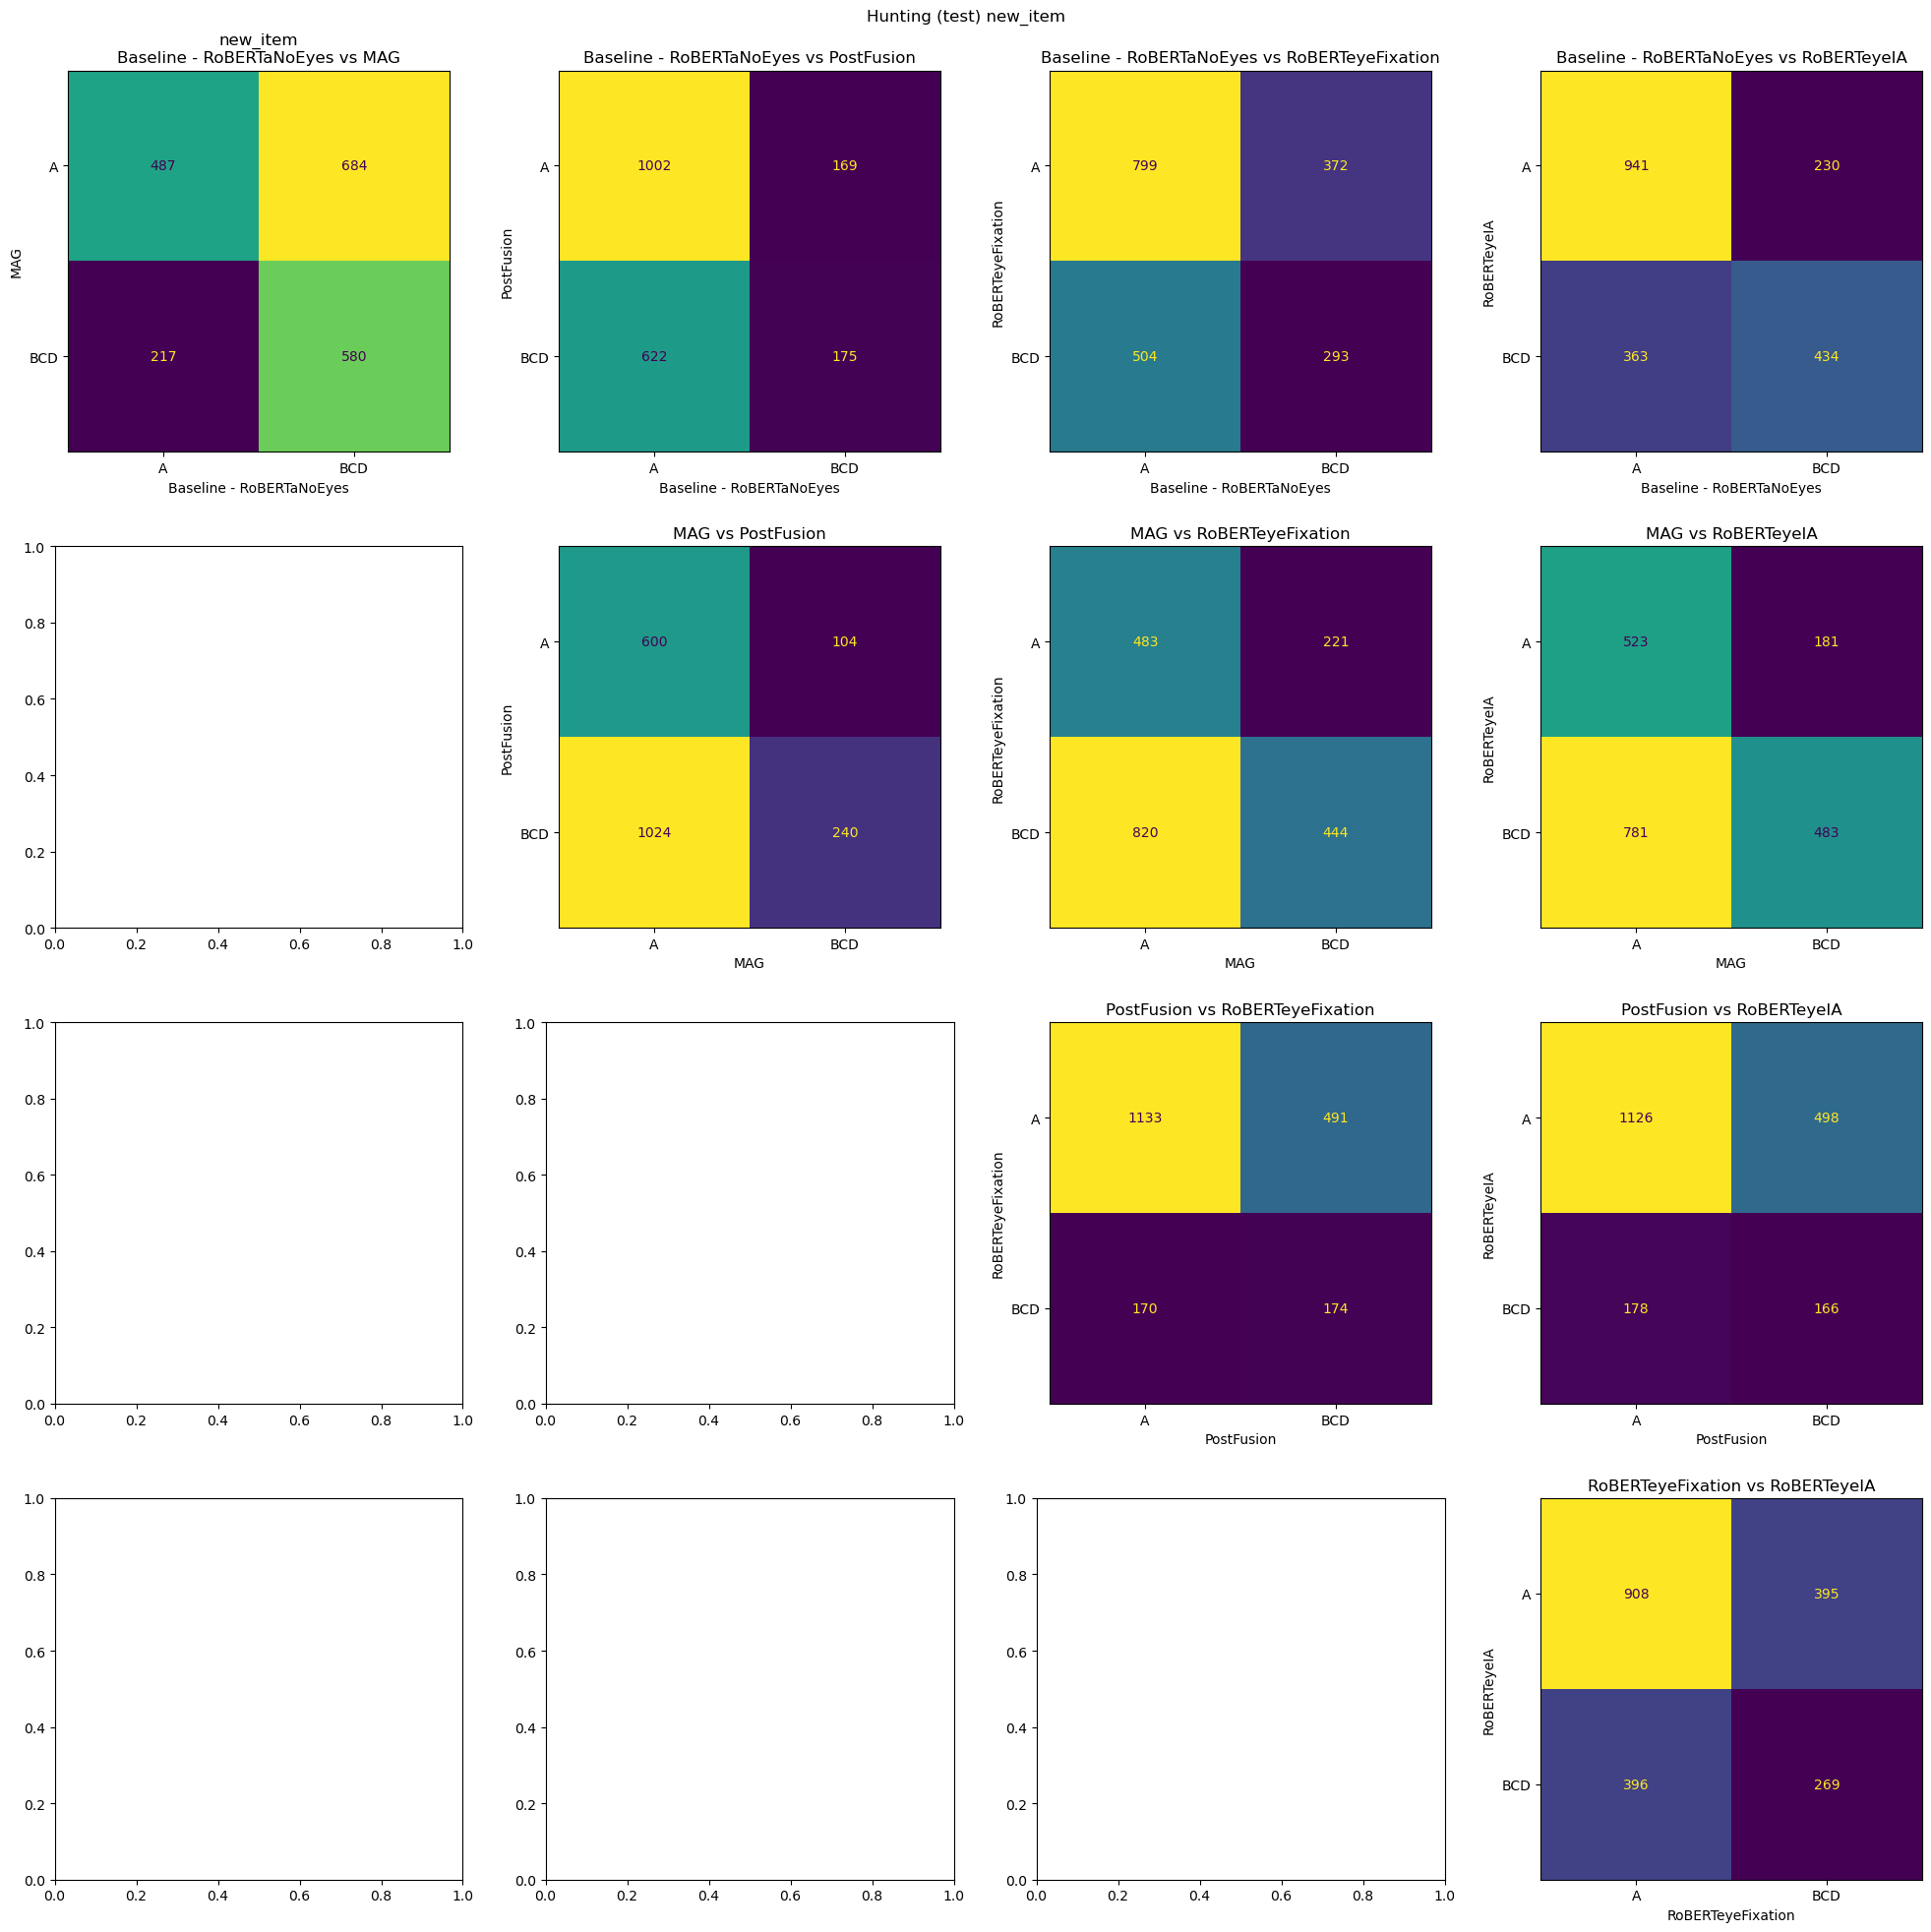

Data: Gathering
i=0 model1='Baseline - RoBERTaNoEyes', j=1 MAG
i=0 model1='Baseline - RoBERTaNoEyes', j=2 PostFusion
i=0 model1='Baseline - RoBERTaNoEyes', j=3 RoBERTeyeFixation
i=0 model1='Baseline - RoBERTaNoEyes', j=4 RoBERTeyeIA
i=1 model1='MAG', j=2 PostFusion
i=1 model1='MAG', j=3 RoBERTeyeFixation
i=1 model1='MAG', j=4 RoBERTeyeIA
i=2 model1='PostFusion', j=3 RoBERTeyeFixation
i=2 model1='PostFusion', j=4 RoBERTeyeIA
i=3 model1='RoBERTeyeFixation', j=4 RoBERTeyeIA


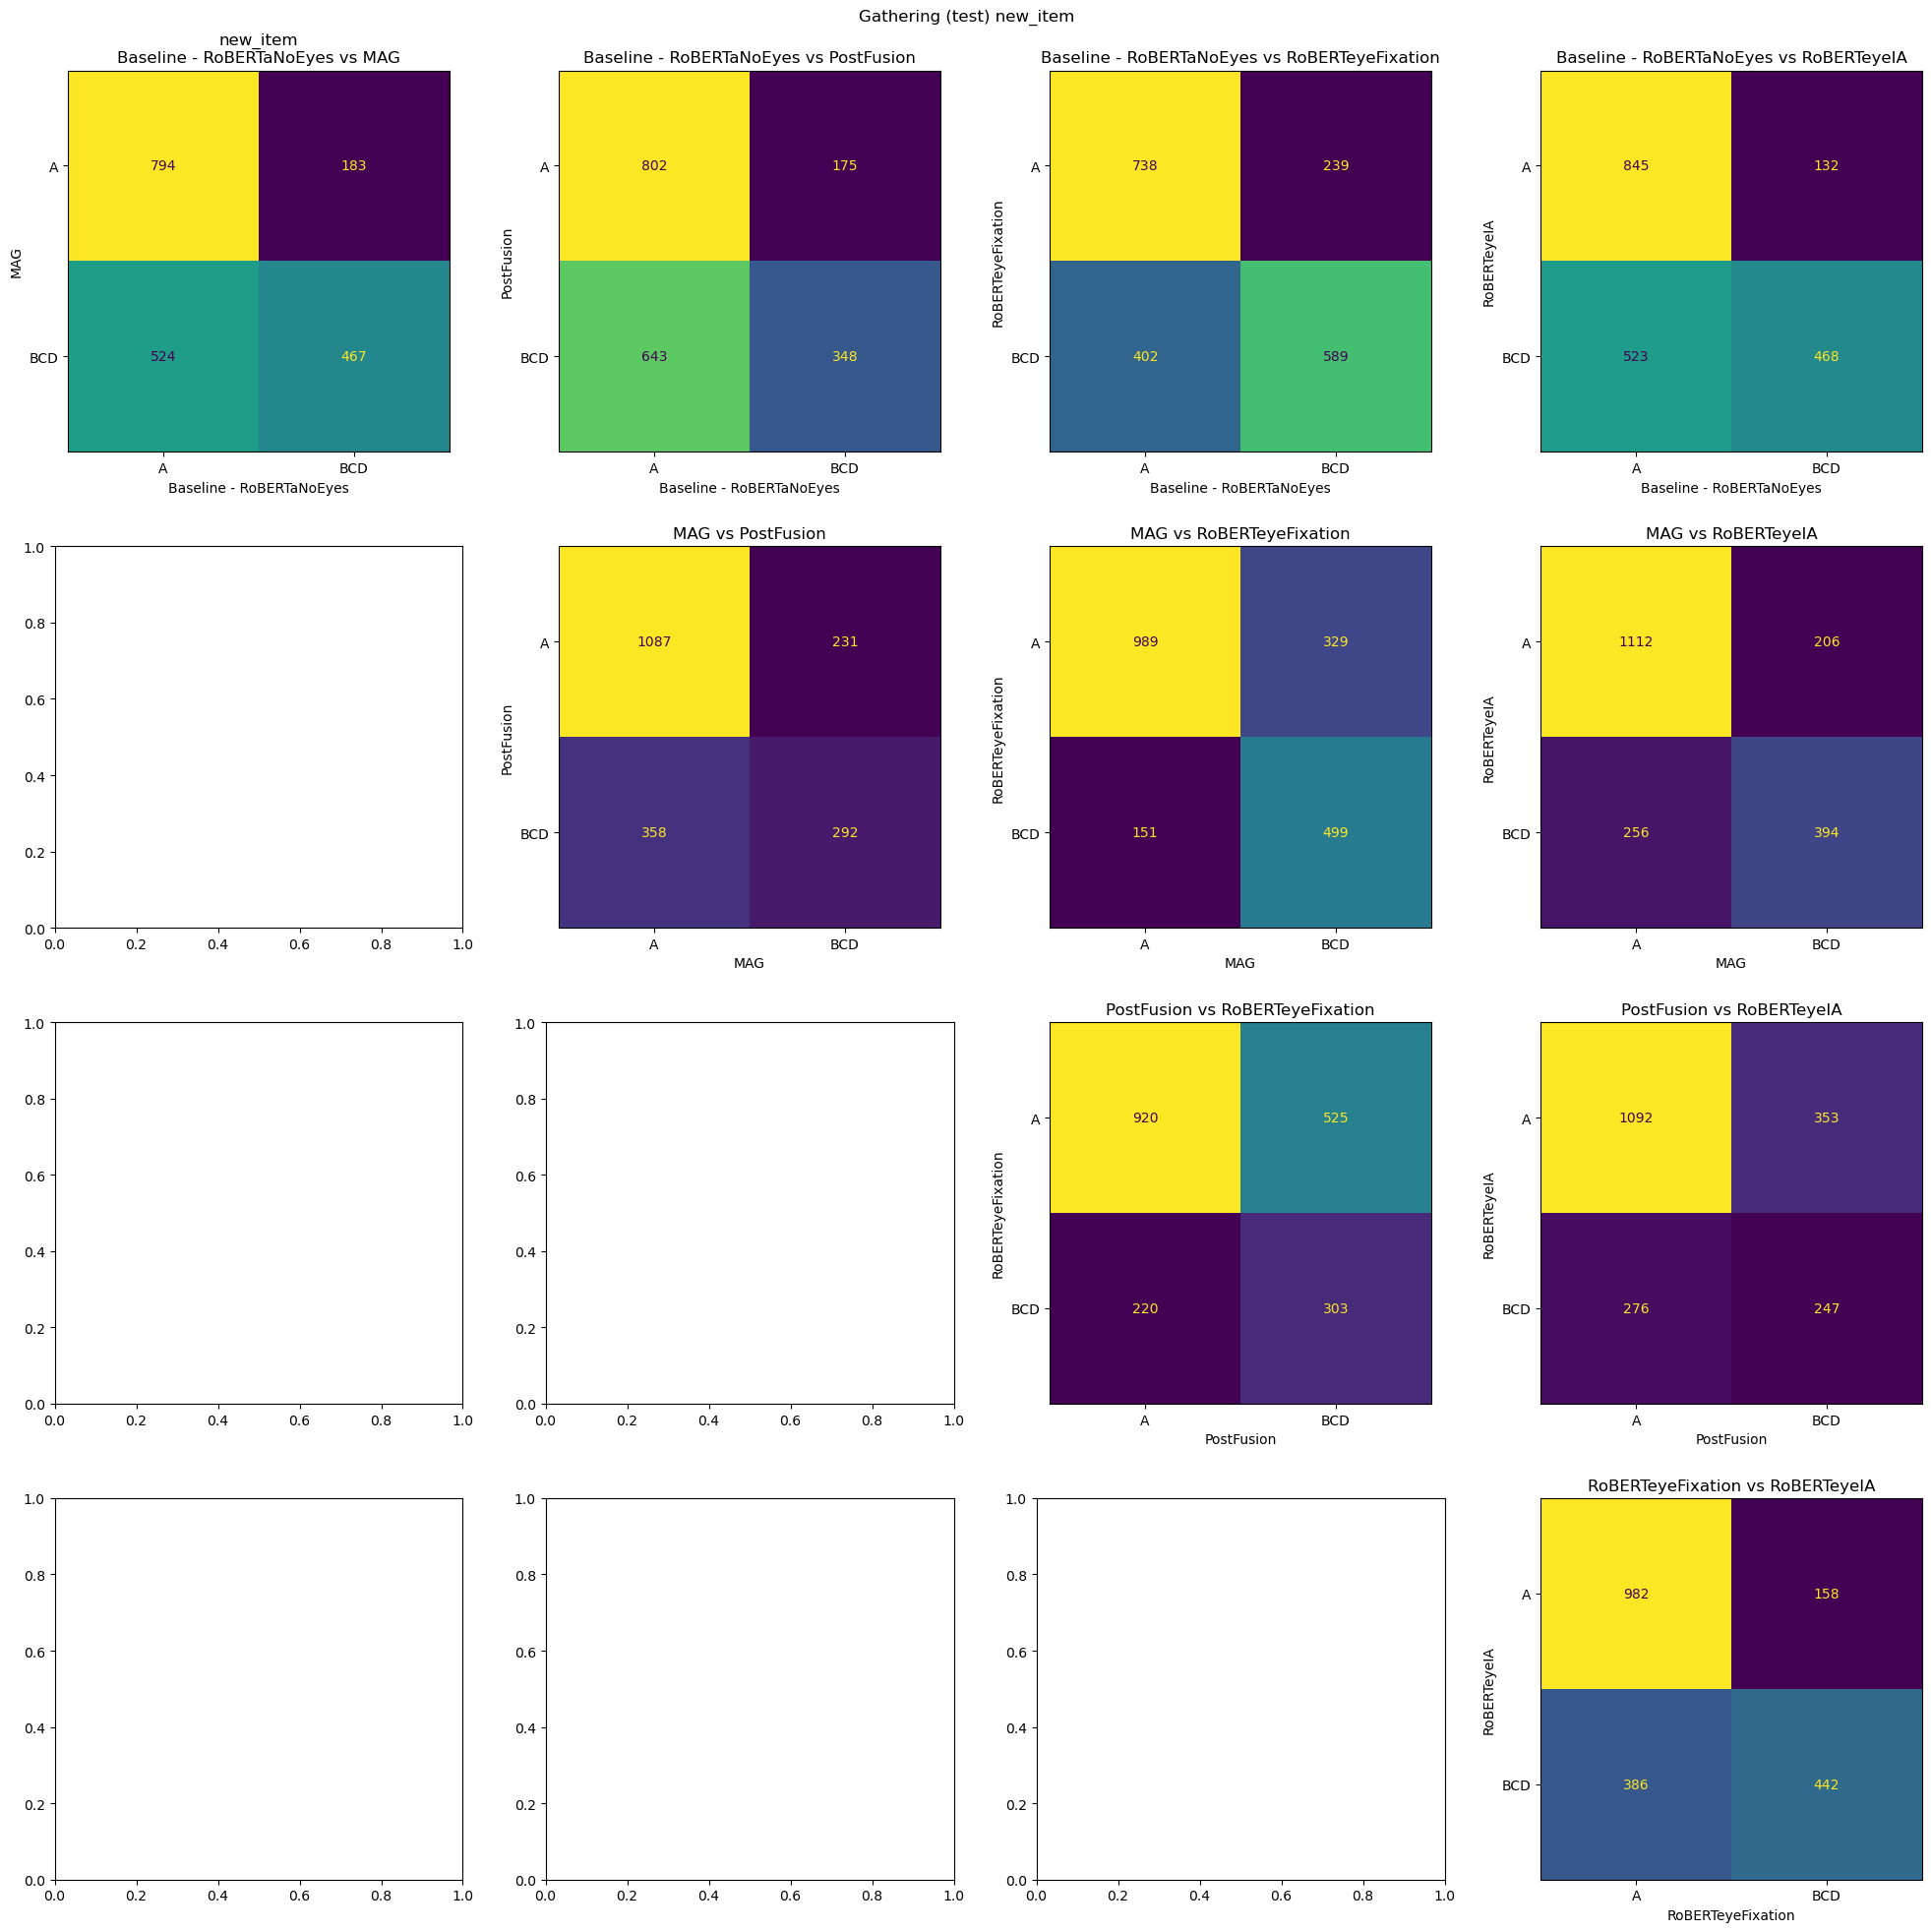

Data: Hunting
i=0 model1='Baseline - RoBERTaNoEyes', j=1 MAG
i=0 model1='Baseline - RoBERTaNoEyes', j=2 PostFusion
i=0 model1='Baseline - RoBERTaNoEyes', j=3 RoBERTeyeFixation
i=0 model1='Baseline - RoBERTaNoEyes', j=4 RoBERTeyeIA
i=1 model1='MAG', j=2 PostFusion
i=1 model1='MAG', j=3 RoBERTeyeFixation
i=1 model1='MAG', j=4 RoBERTeyeIA
i=2 model1='PostFusion', j=3 RoBERTeyeFixation
i=2 model1='PostFusion', j=4 RoBERTeyeIA
i=3 model1='RoBERTeyeFixation', j=4 RoBERTeyeIA


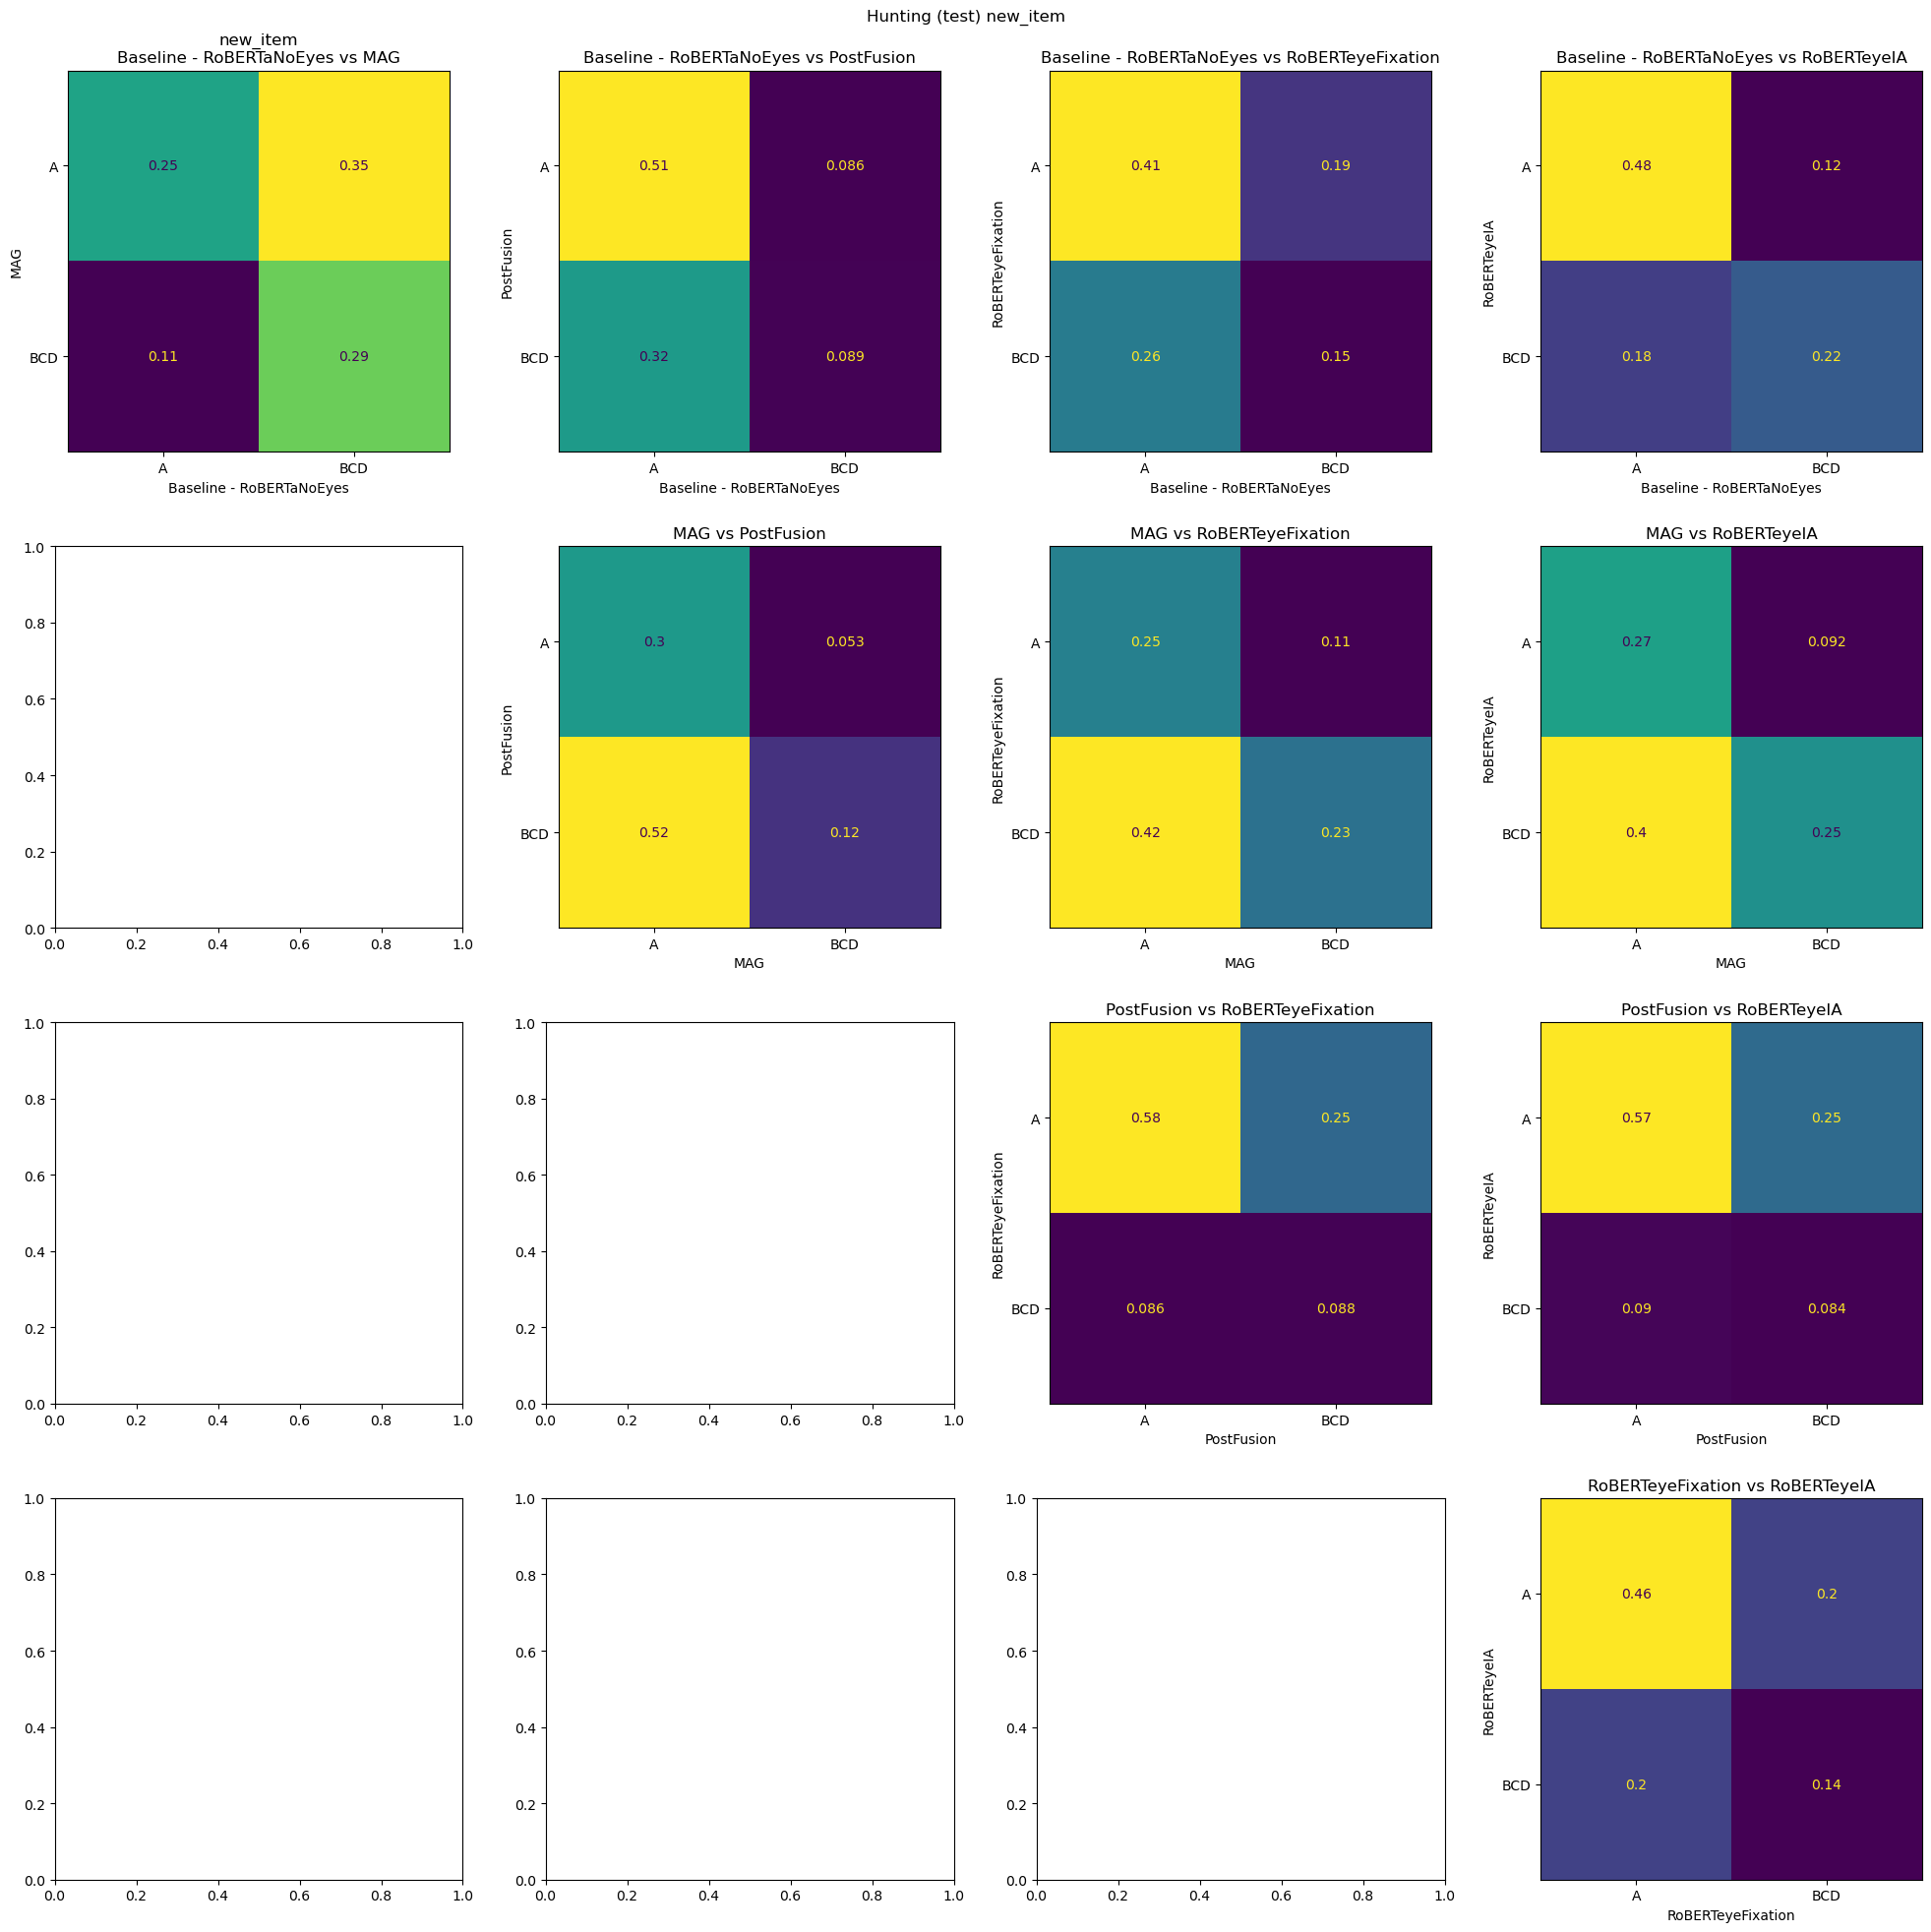

Data: Gathering
i=0 model1='Baseline - RoBERTaNoEyes', j=1 MAG
i=0 model1='Baseline - RoBERTaNoEyes', j=2 PostFusion
i=0 model1='Baseline - RoBERTaNoEyes', j=3 RoBERTeyeFixation
i=0 model1='Baseline - RoBERTaNoEyes', j=4 RoBERTeyeIA
i=1 model1='MAG', j=2 PostFusion
i=1 model1='MAG', j=3 RoBERTeyeFixation
i=1 model1='MAG', j=4 RoBERTeyeIA
i=2 model1='PostFusion', j=3 RoBERTeyeFixation
i=2 model1='PostFusion', j=4 RoBERTeyeIA
i=3 model1='RoBERTeyeFixation', j=4 RoBERTeyeIA


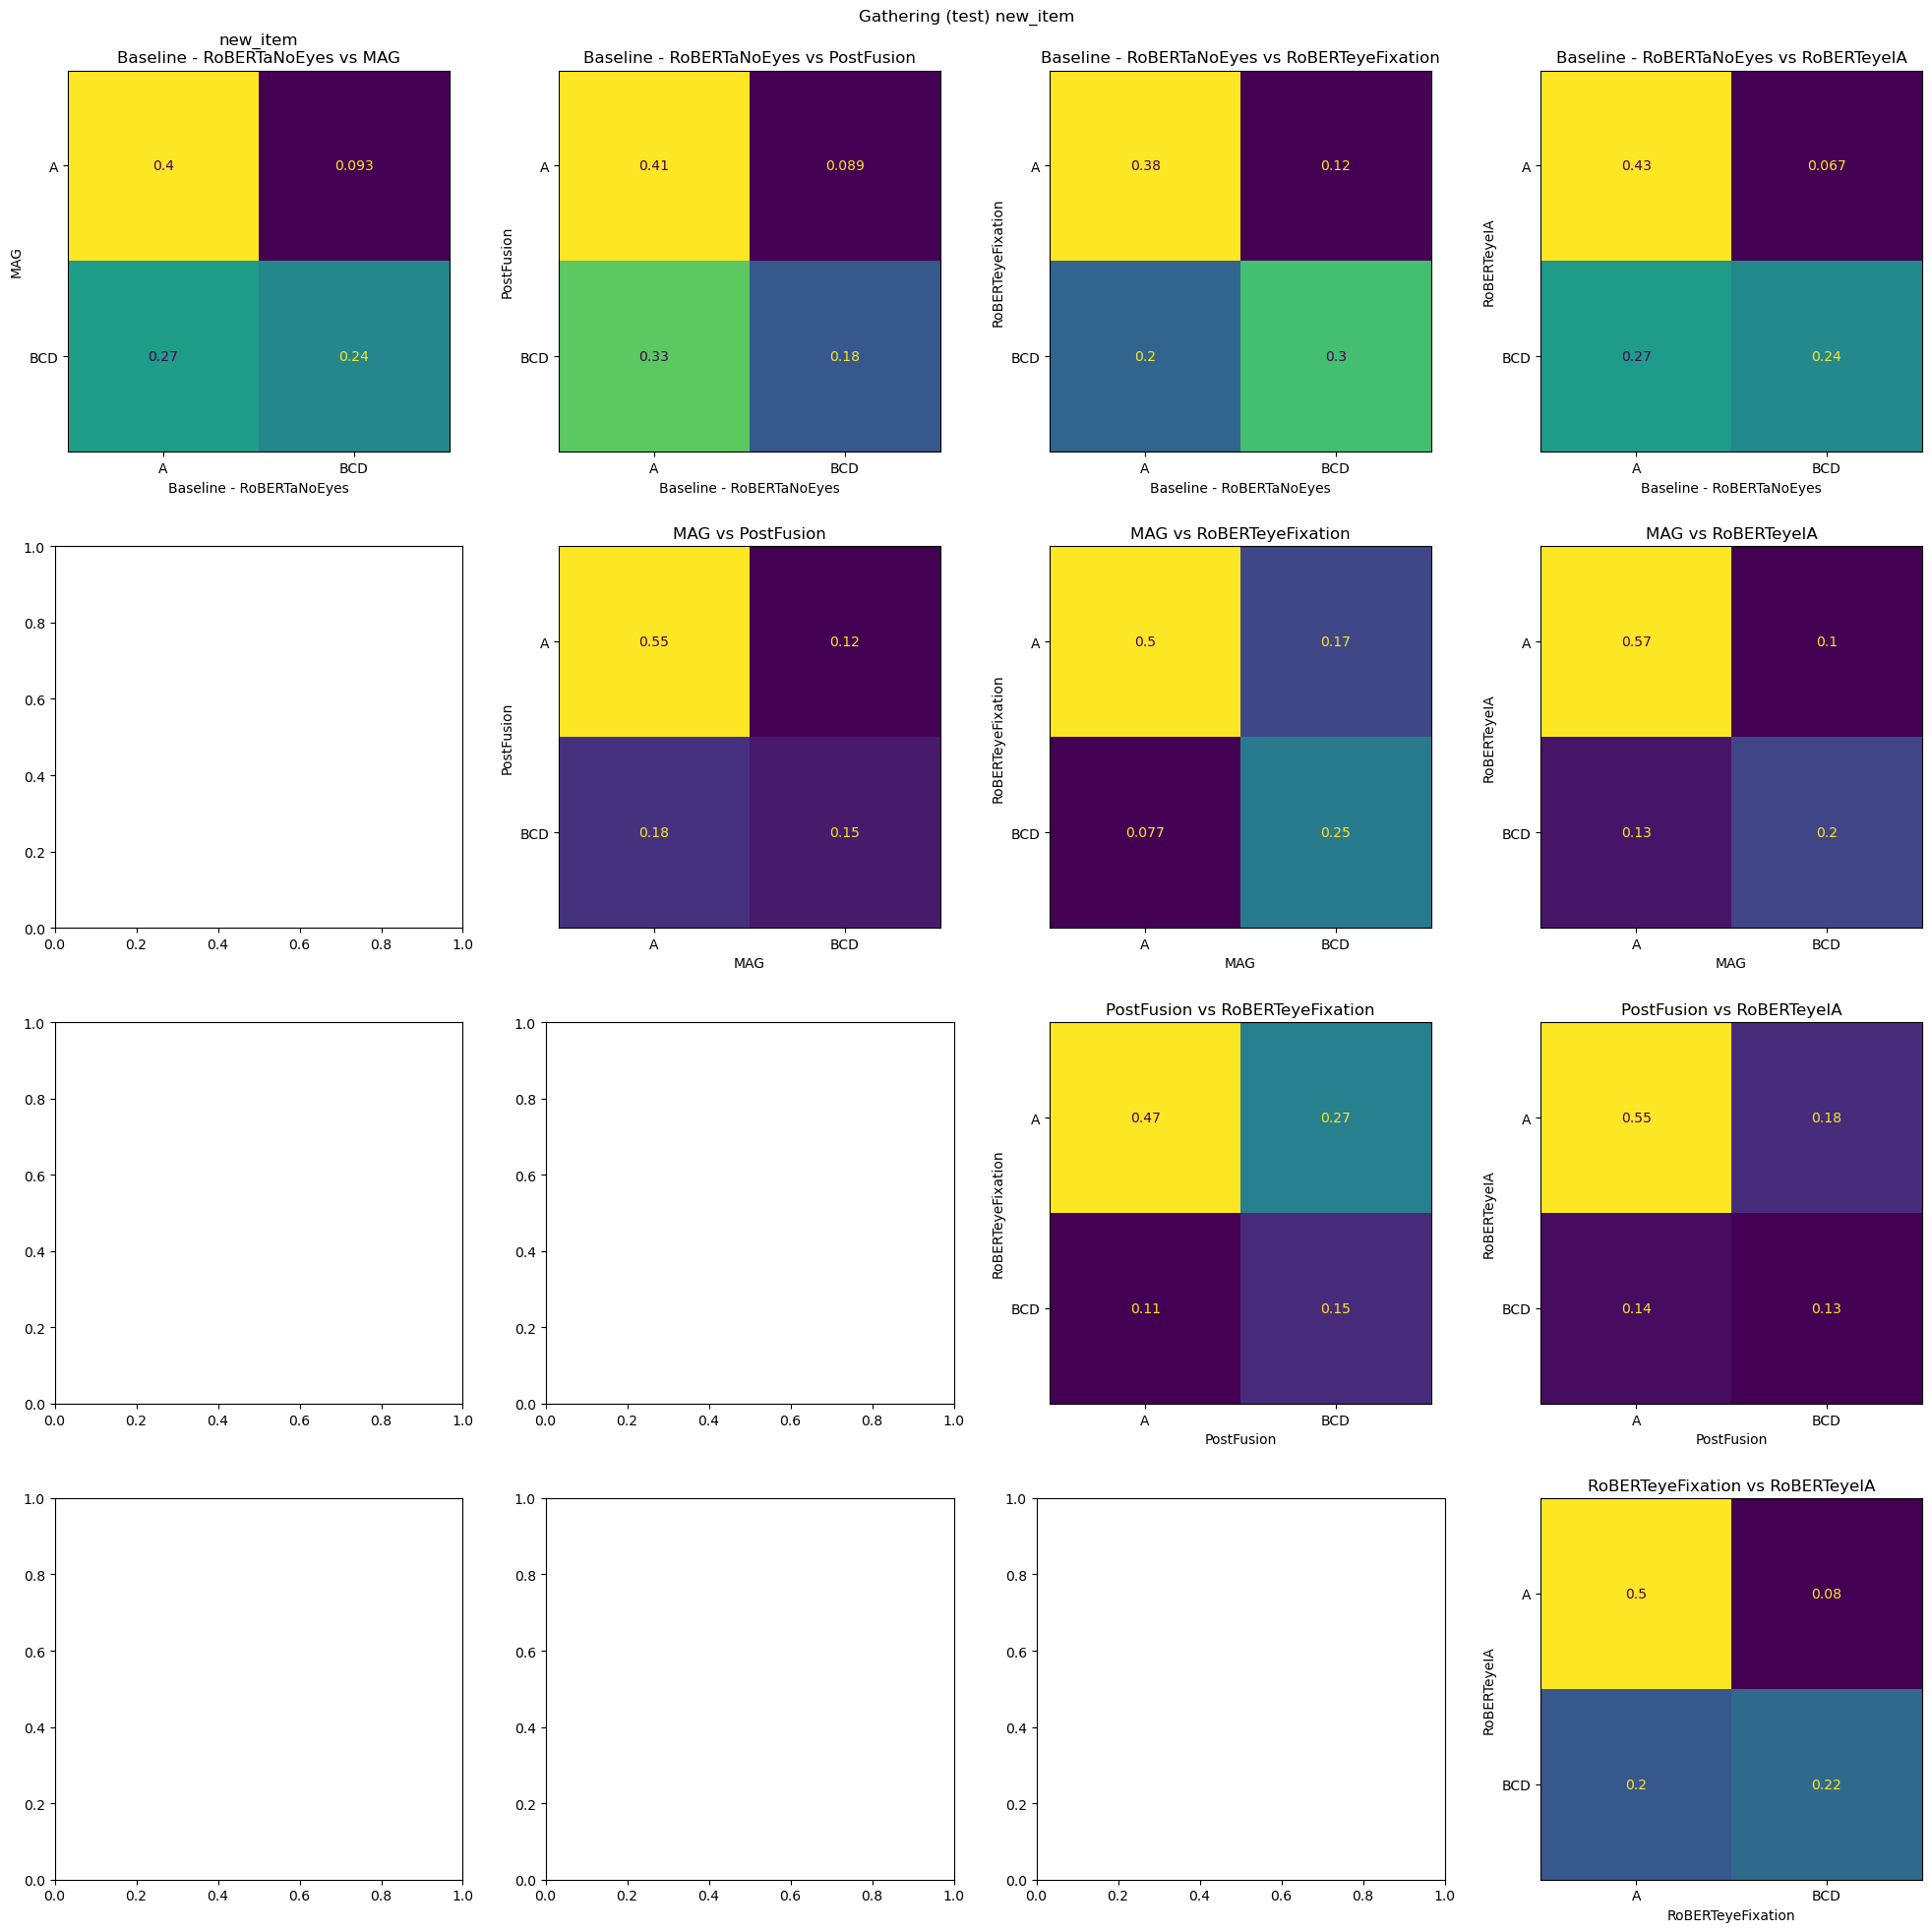

Data: Hunting
i=0 model1='Baseline - RoBERTaNoEyes', j=1 MAG
i=0 model1='Baseline - RoBERTaNoEyes', j=2 PostFusion
i=0 model1='Baseline - RoBERTaNoEyes', j=3 RoBERTeyeFixation
i=0 model1='Baseline - RoBERTaNoEyes', j=4 RoBERTeyeIA
i=1 model1='MAG', j=2 PostFusion
i=1 model1='MAG', j=3 RoBERTeyeFixation
i=1 model1='MAG', j=4 RoBERTeyeIA
i=2 model1='PostFusion', j=3 RoBERTeyeFixation
i=2 model1='PostFusion', j=4 RoBERTeyeIA
i=3 model1='RoBERTeyeFixation', j=4 RoBERTeyeIA


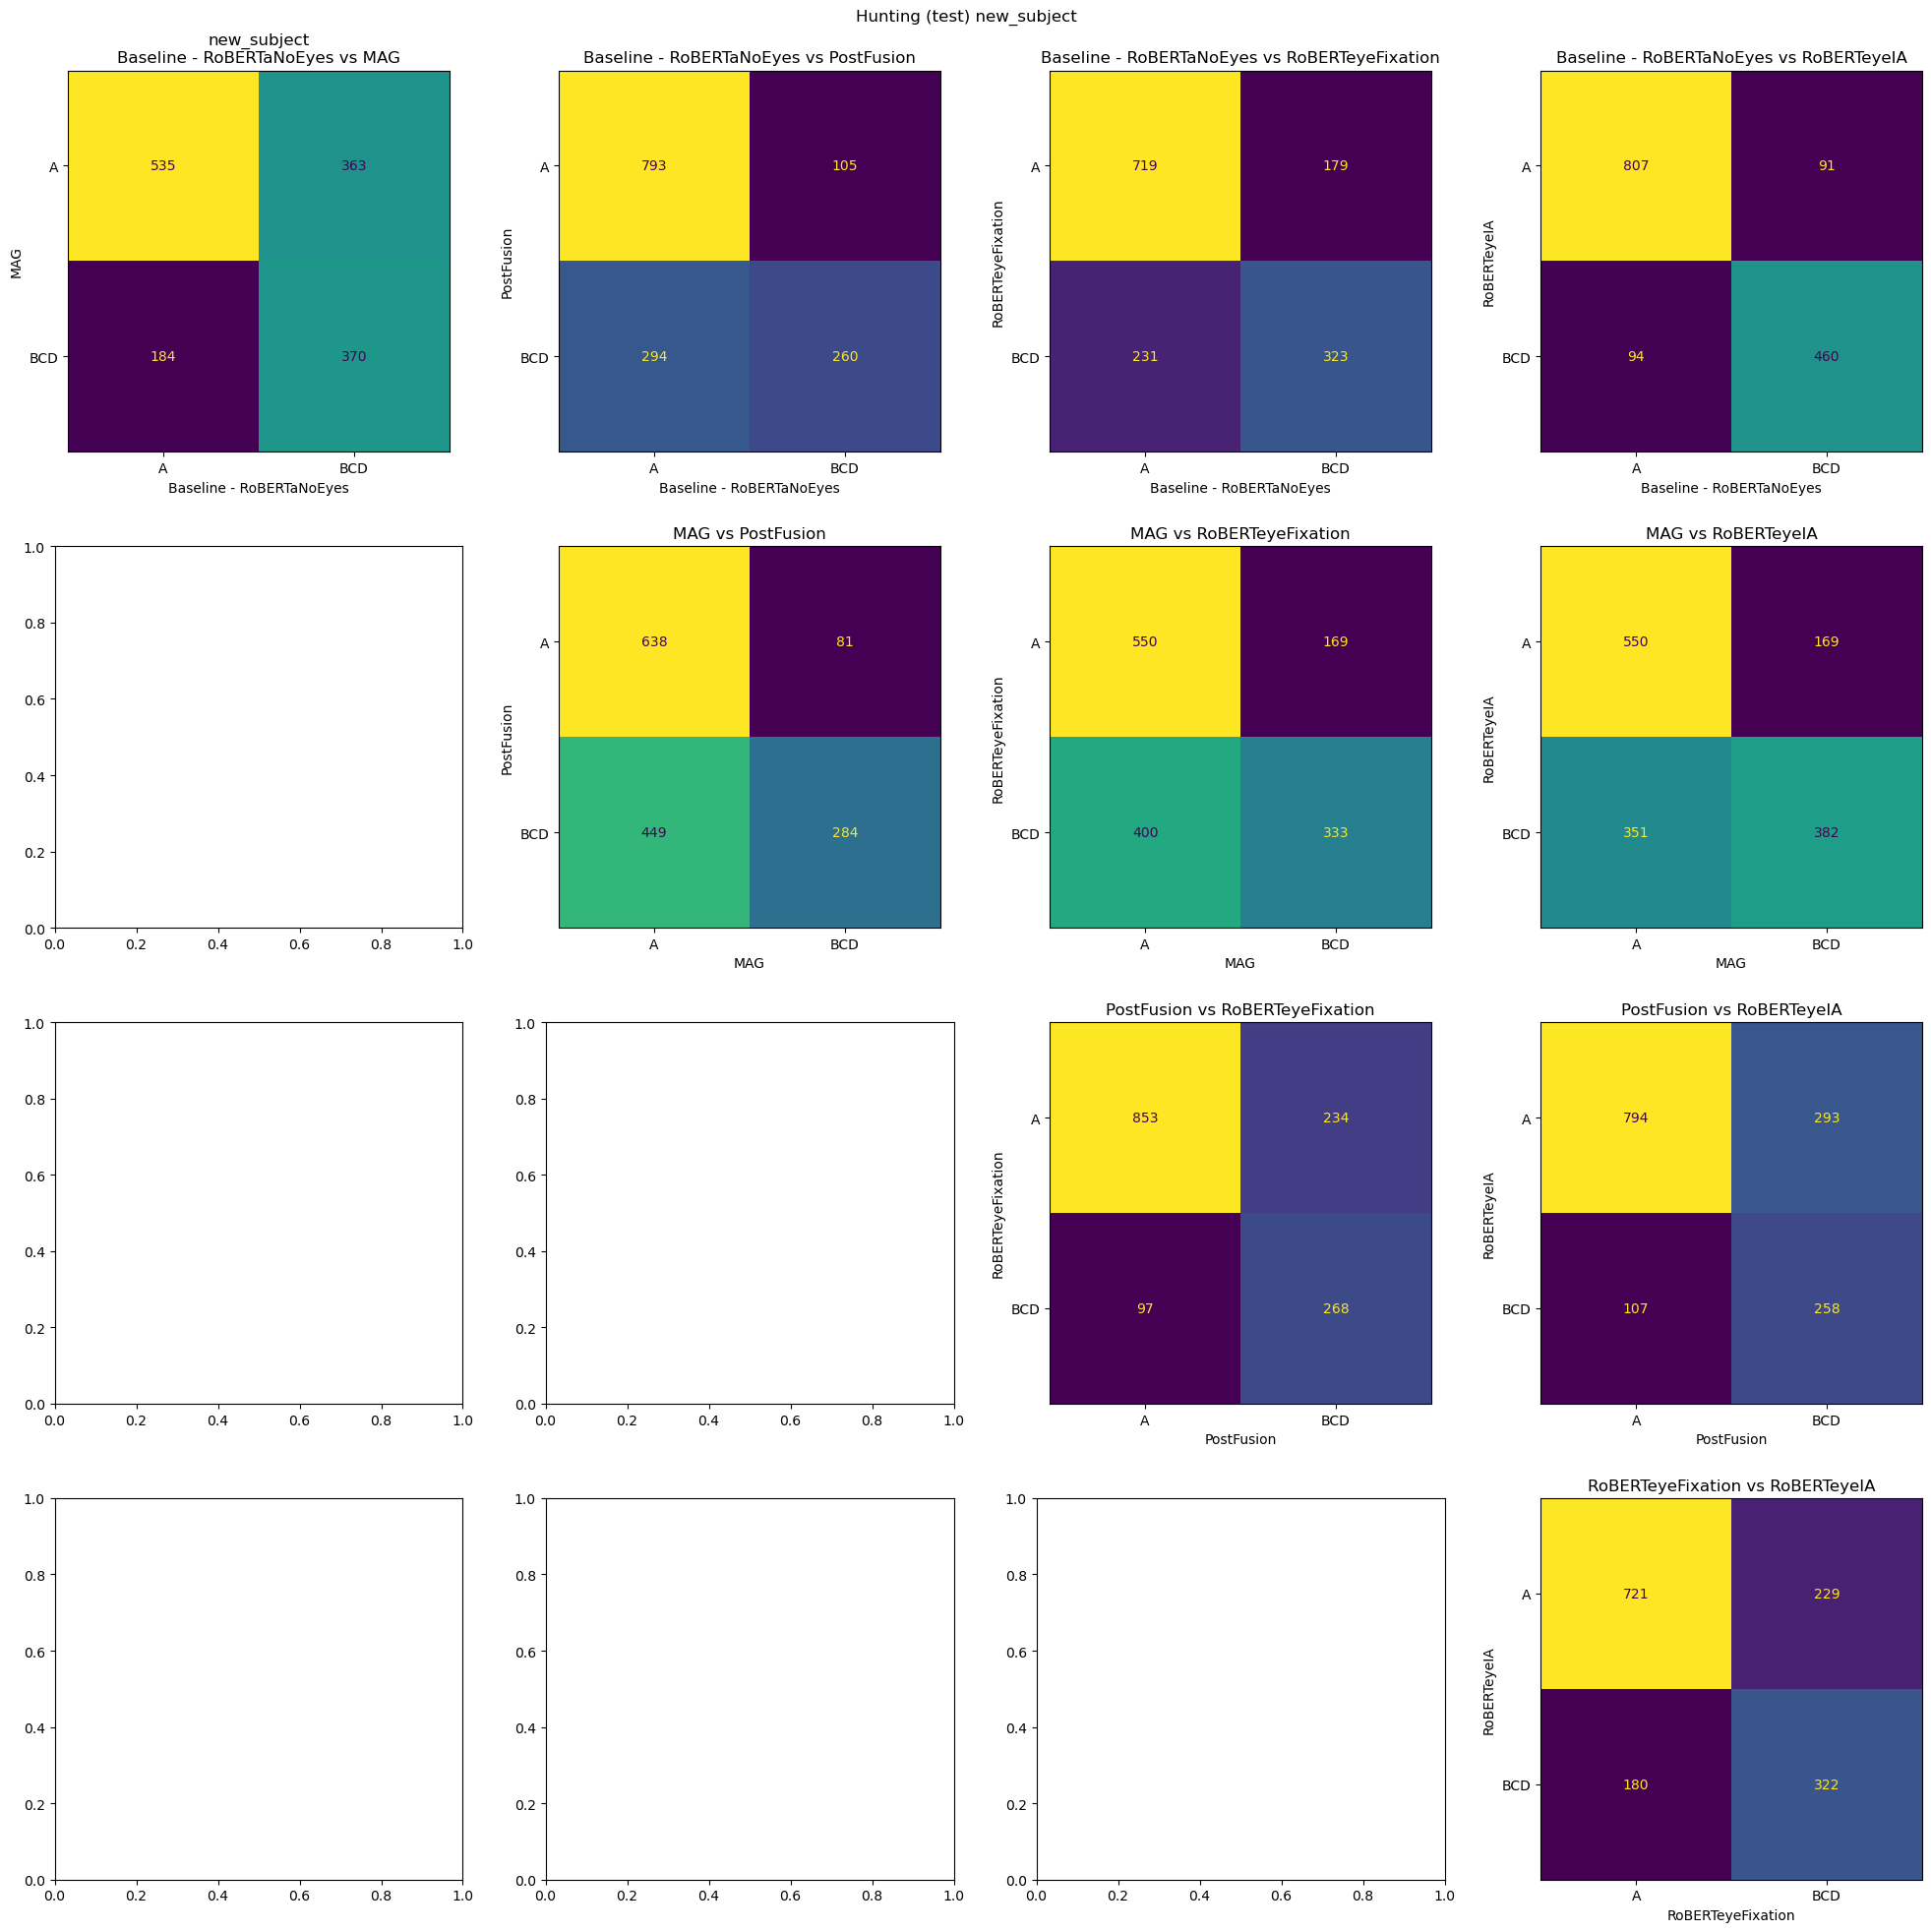

Data: Gathering
i=0 model1='Baseline - RoBERTaNoEyes', j=1 MAG
i=0 model1='Baseline - RoBERTaNoEyes', j=2 PostFusion
i=0 model1='Baseline - RoBERTaNoEyes', j=3 RoBERTeyeFixation
i=0 model1='Baseline - RoBERTaNoEyes', j=4 RoBERTeyeIA
i=1 model1='MAG', j=2 PostFusion
i=1 model1='MAG', j=3 RoBERTeyeFixation
i=1 model1='MAG', j=4 RoBERTeyeIA
i=2 model1='PostFusion', j=3 RoBERTeyeFixation
i=2 model1='PostFusion', j=4 RoBERTeyeIA
i=3 model1='RoBERTeyeFixation', j=4 RoBERTeyeIA


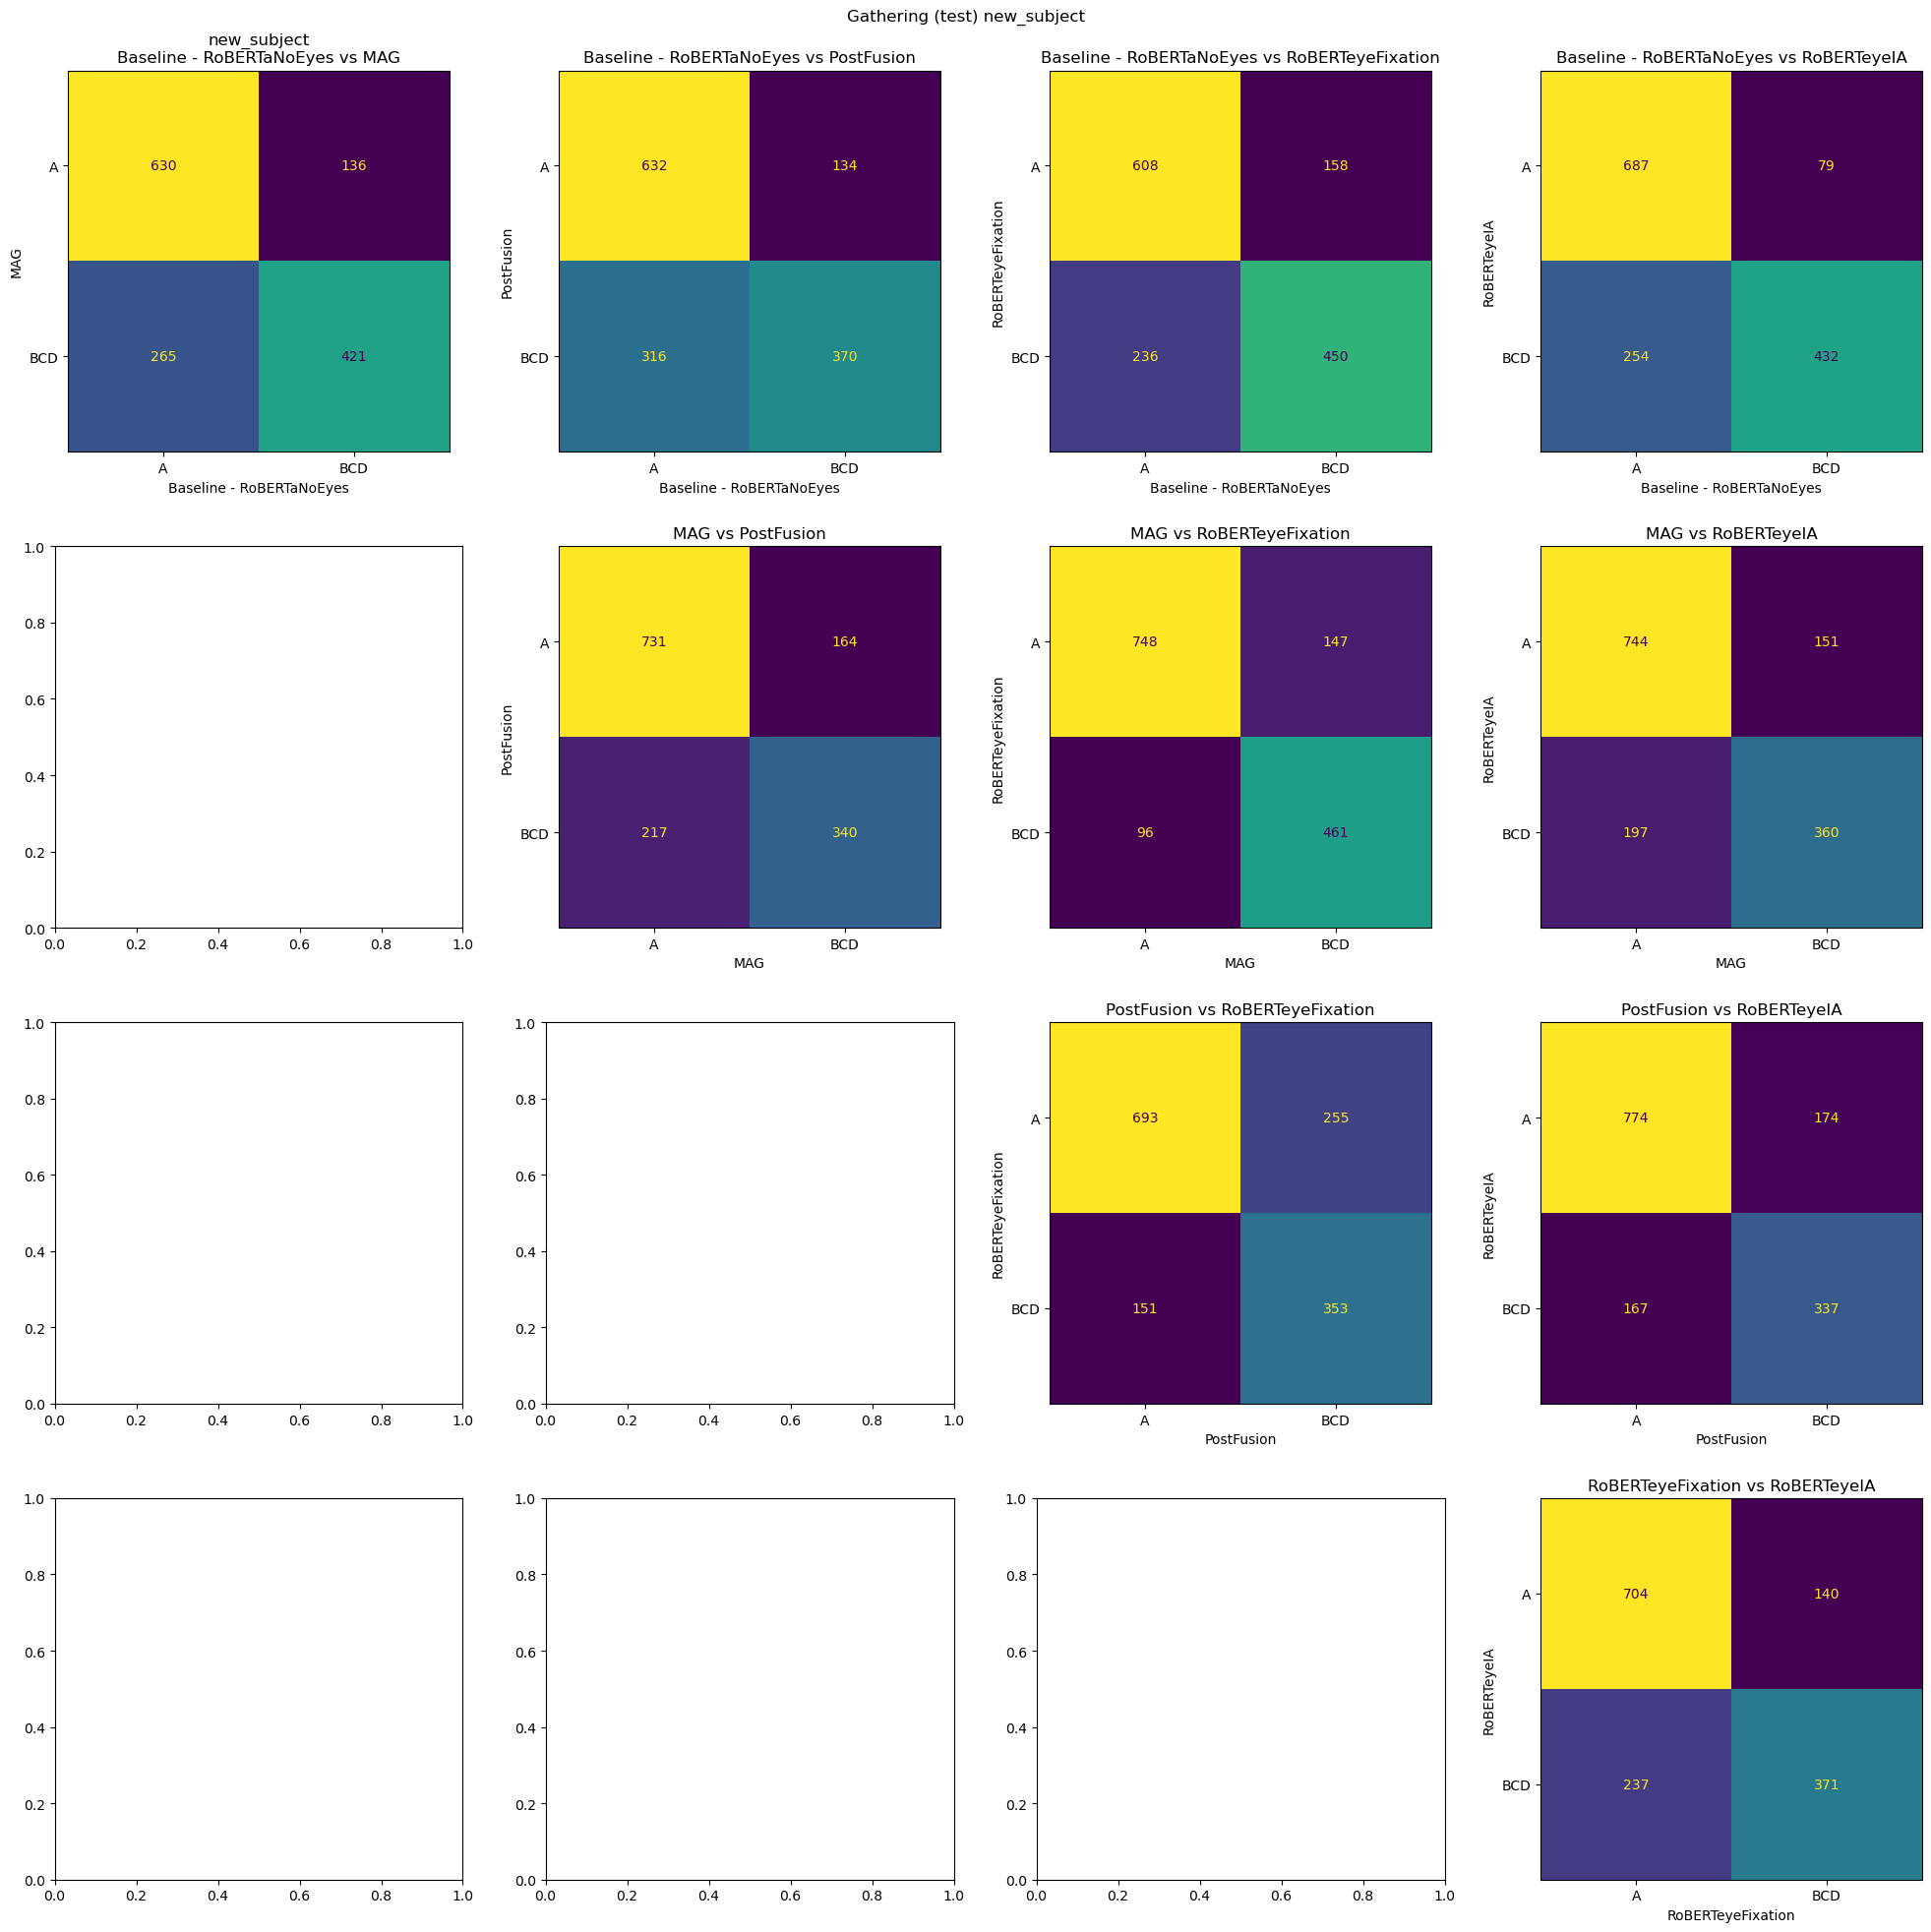

Data: Hunting
i=0 model1='Baseline - RoBERTaNoEyes', j=1 MAG
i=0 model1='Baseline - RoBERTaNoEyes', j=2 PostFusion
i=0 model1='Baseline - RoBERTaNoEyes', j=3 RoBERTeyeFixation
i=0 model1='Baseline - RoBERTaNoEyes', j=4 RoBERTeyeIA
i=1 model1='MAG', j=2 PostFusion
i=1 model1='MAG', j=3 RoBERTeyeFixation
i=1 model1='MAG', j=4 RoBERTeyeIA
i=2 model1='PostFusion', j=3 RoBERTeyeFixation
i=2 model1='PostFusion', j=4 RoBERTeyeIA
i=3 model1='RoBERTeyeFixation', j=4 RoBERTeyeIA


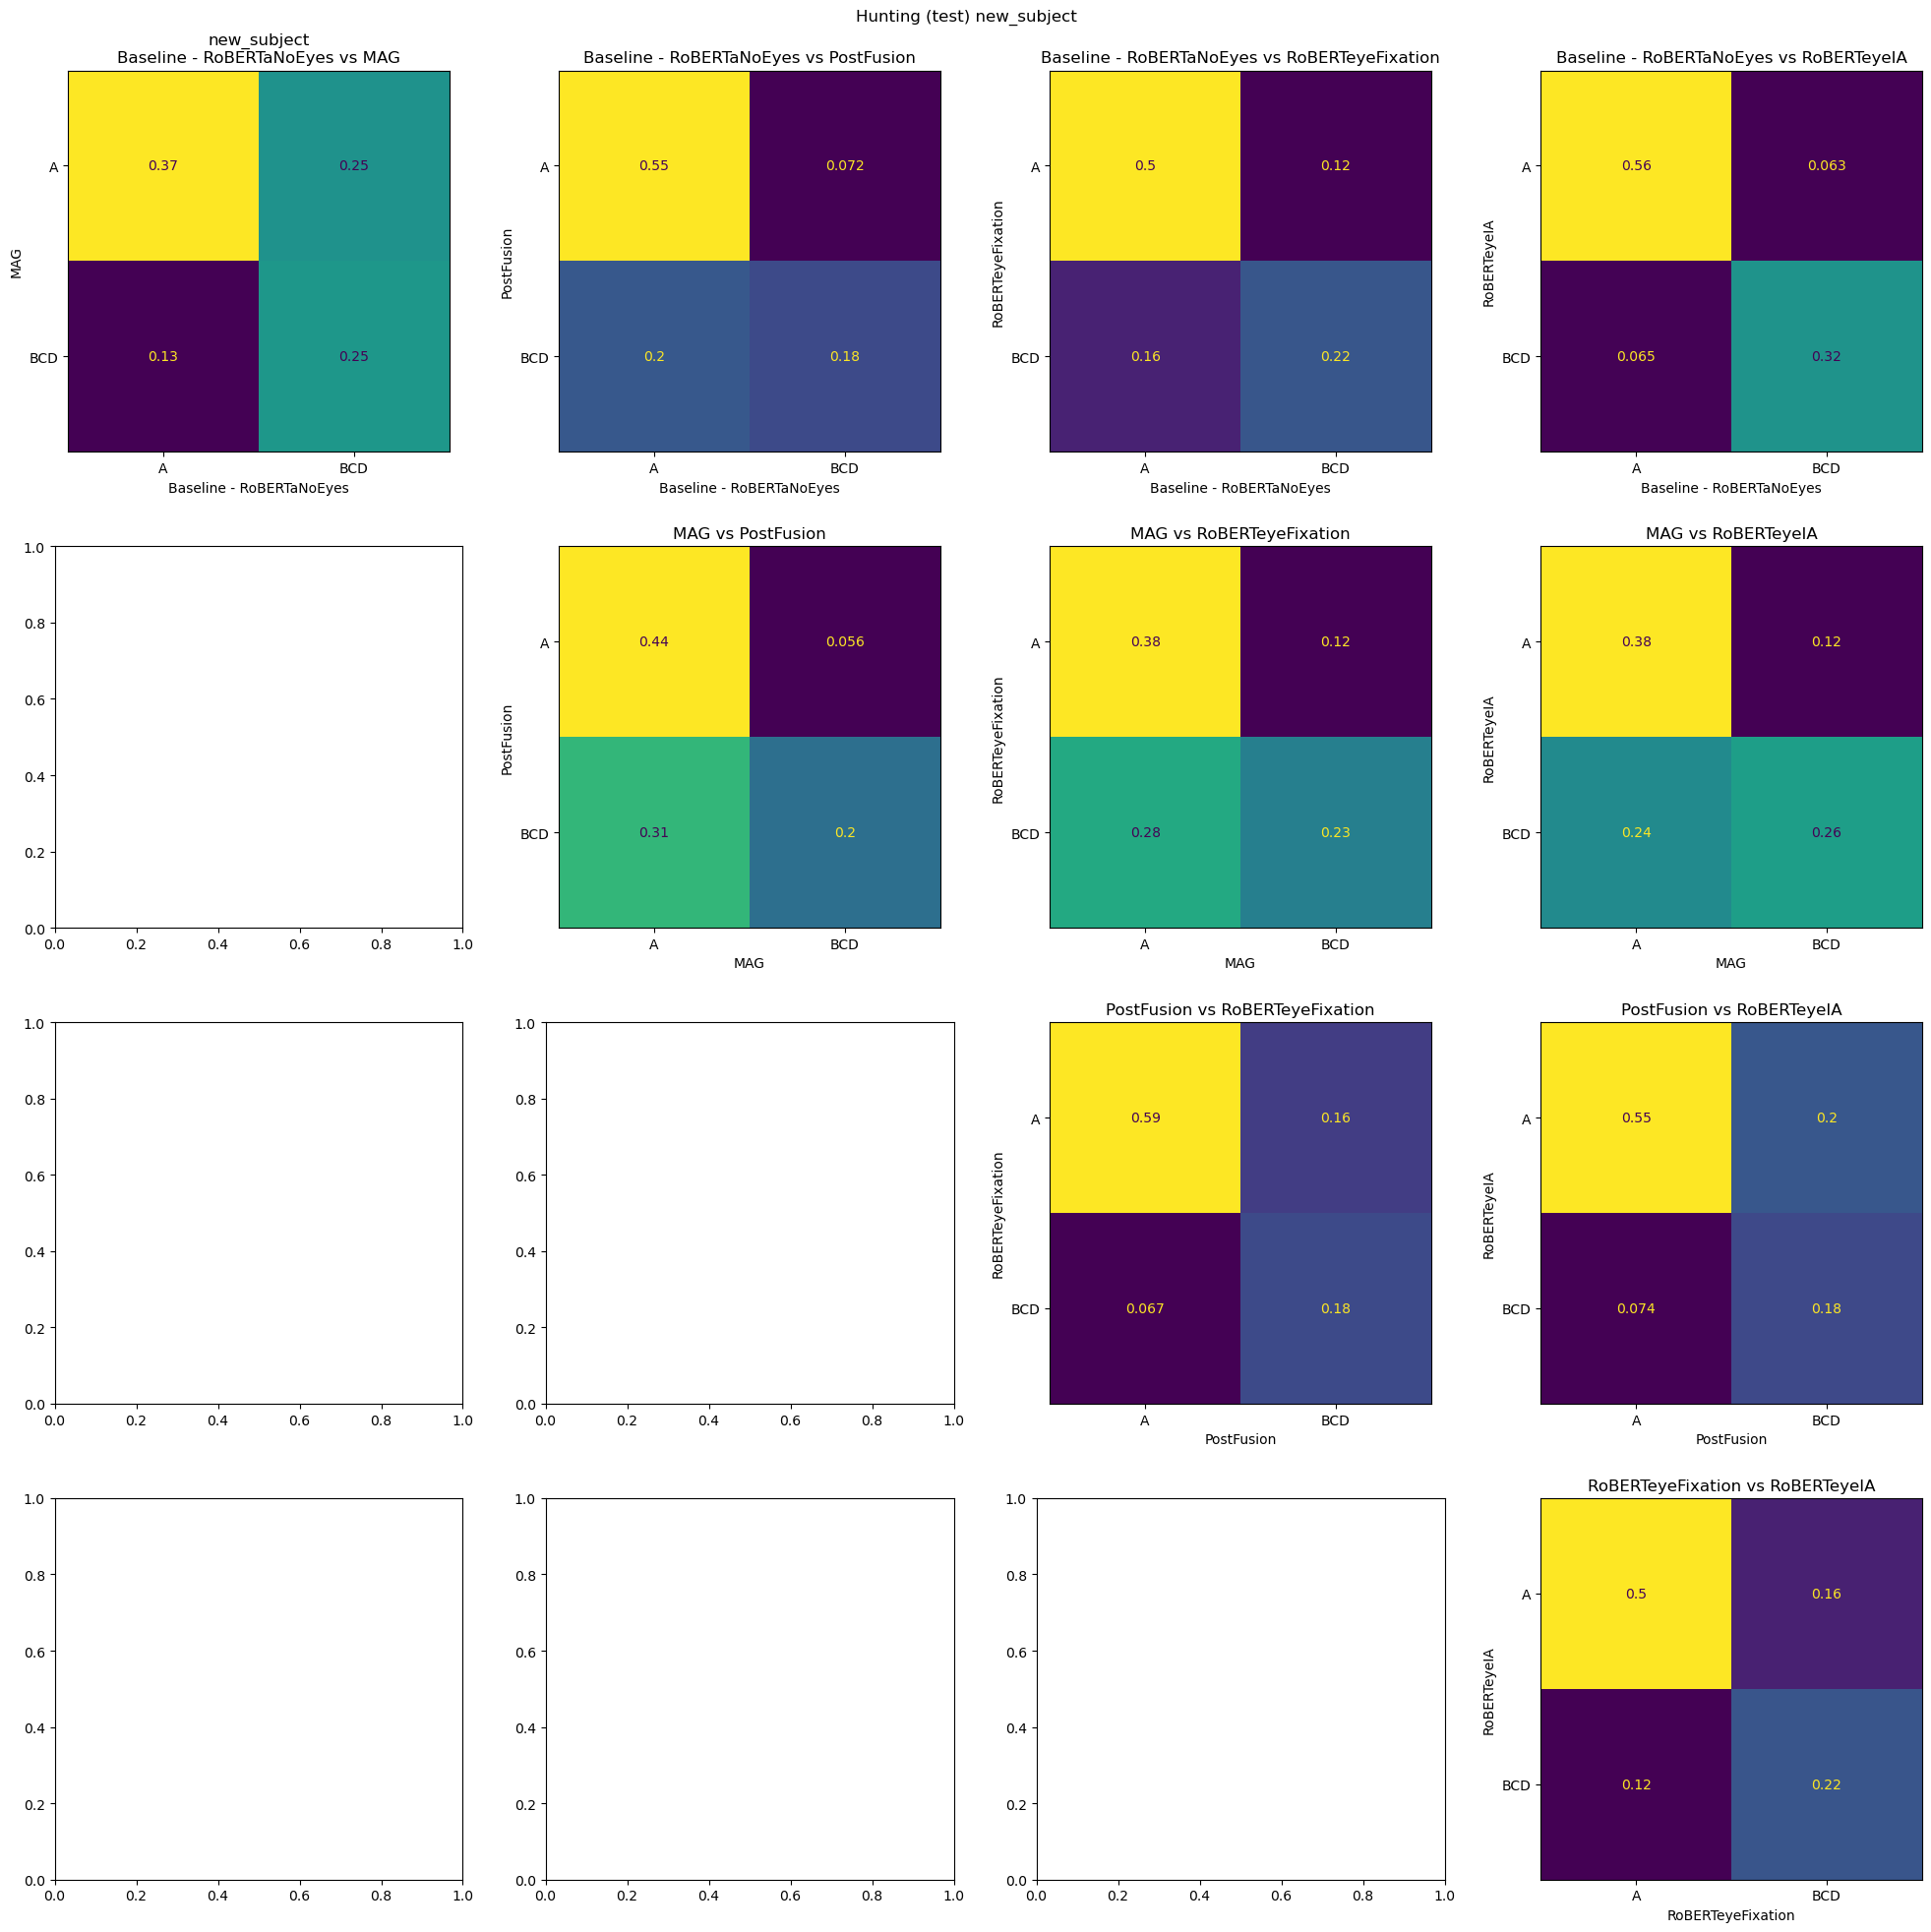

Data: Gathering
i=0 model1='Baseline - RoBERTaNoEyes', j=1 MAG
i=0 model1='Baseline - RoBERTaNoEyes', j=2 PostFusion
i=0 model1='Baseline - RoBERTaNoEyes', j=3 RoBERTeyeFixation
i=0 model1='Baseline - RoBERTaNoEyes', j=4 RoBERTeyeIA
i=1 model1='MAG', j=2 PostFusion
i=1 model1='MAG', j=3 RoBERTeyeFixation
i=1 model1='MAG', j=4 RoBERTeyeIA
i=2 model1='PostFusion', j=3 RoBERTeyeFixation
i=2 model1='PostFusion', j=4 RoBERTeyeIA
i=3 model1='RoBERTeyeFixation', j=4 RoBERTeyeIA


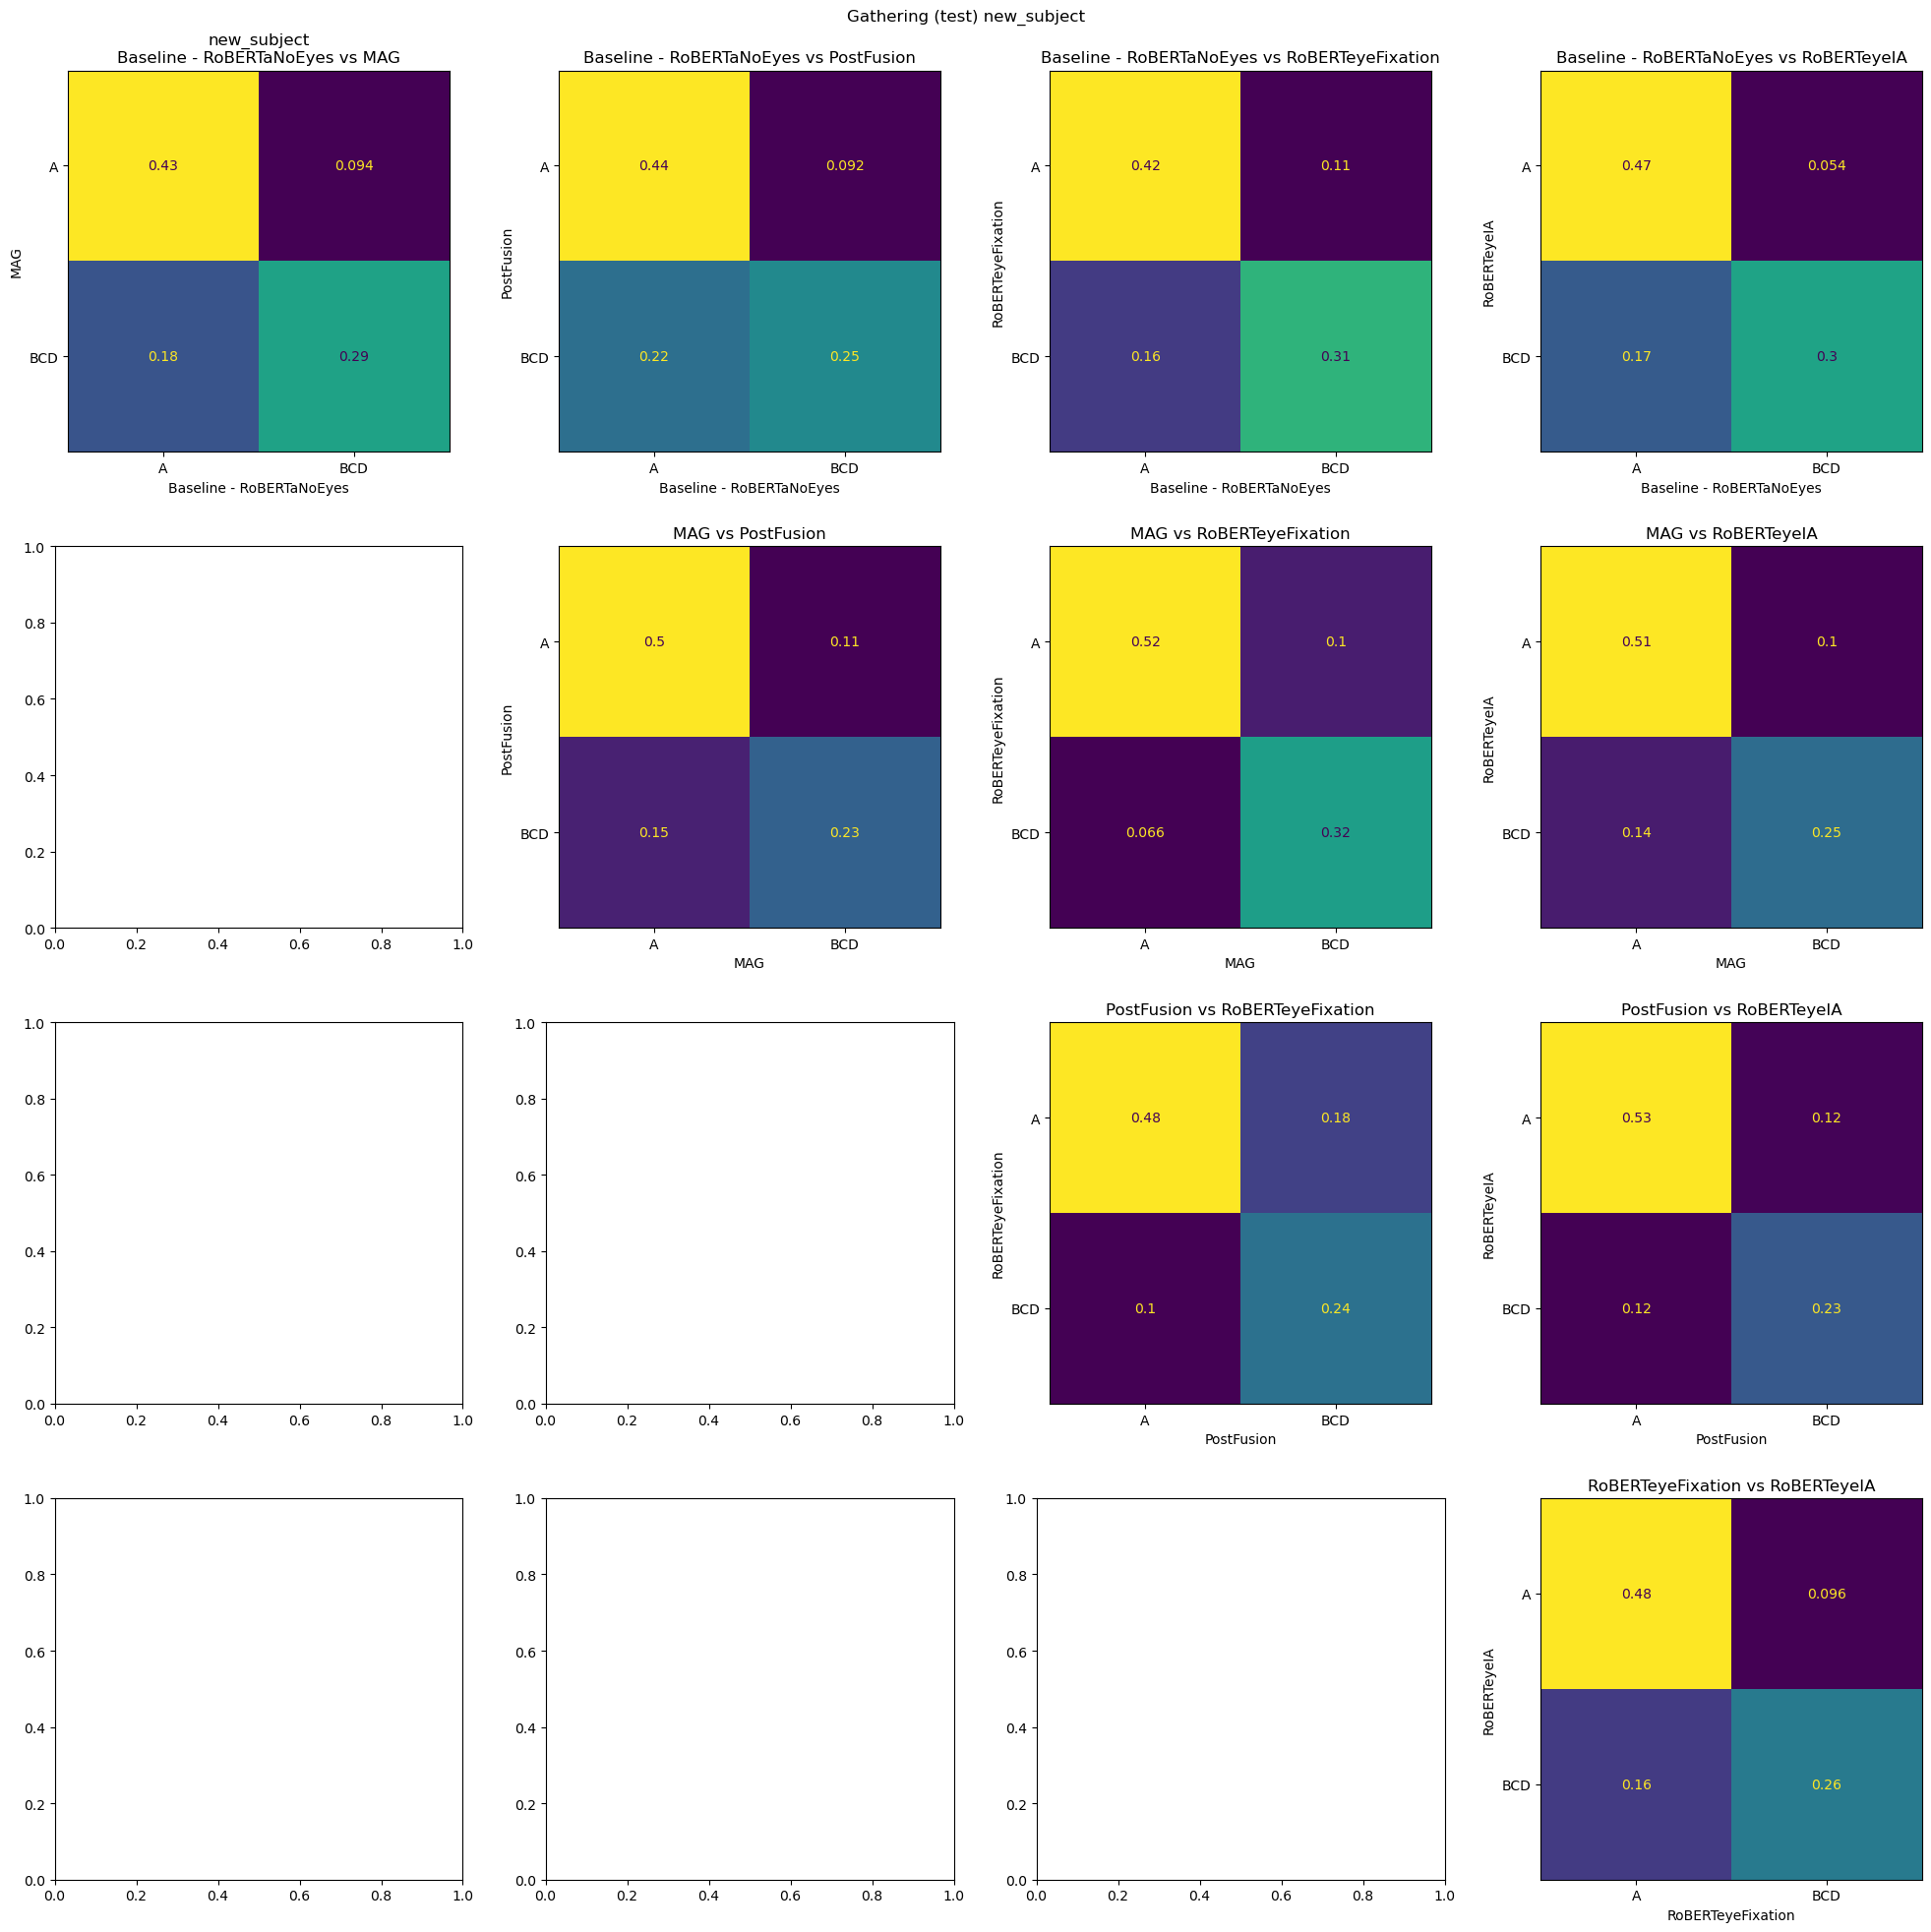

Data: Hunting
i=0 model1='Baseline - RoBERTaNoEyes', j=1 MAG
i=0 model1='Baseline - RoBERTaNoEyes', j=2 PostFusion
i=0 model1='Baseline - RoBERTaNoEyes', j=3 RoBERTeyeFixation
i=0 model1='Baseline - RoBERTaNoEyes', j=4 RoBERTeyeIA
i=1 model1='MAG', j=2 PostFusion
i=1 model1='MAG', j=3 RoBERTeyeFixation
i=1 model1='MAG', j=4 RoBERTeyeIA
i=2 model1='PostFusion', j=3 RoBERTeyeFixation
i=2 model1='PostFusion', j=4 RoBERTeyeIA
i=3 model1='RoBERTeyeFixation', j=4 RoBERTeyeIA


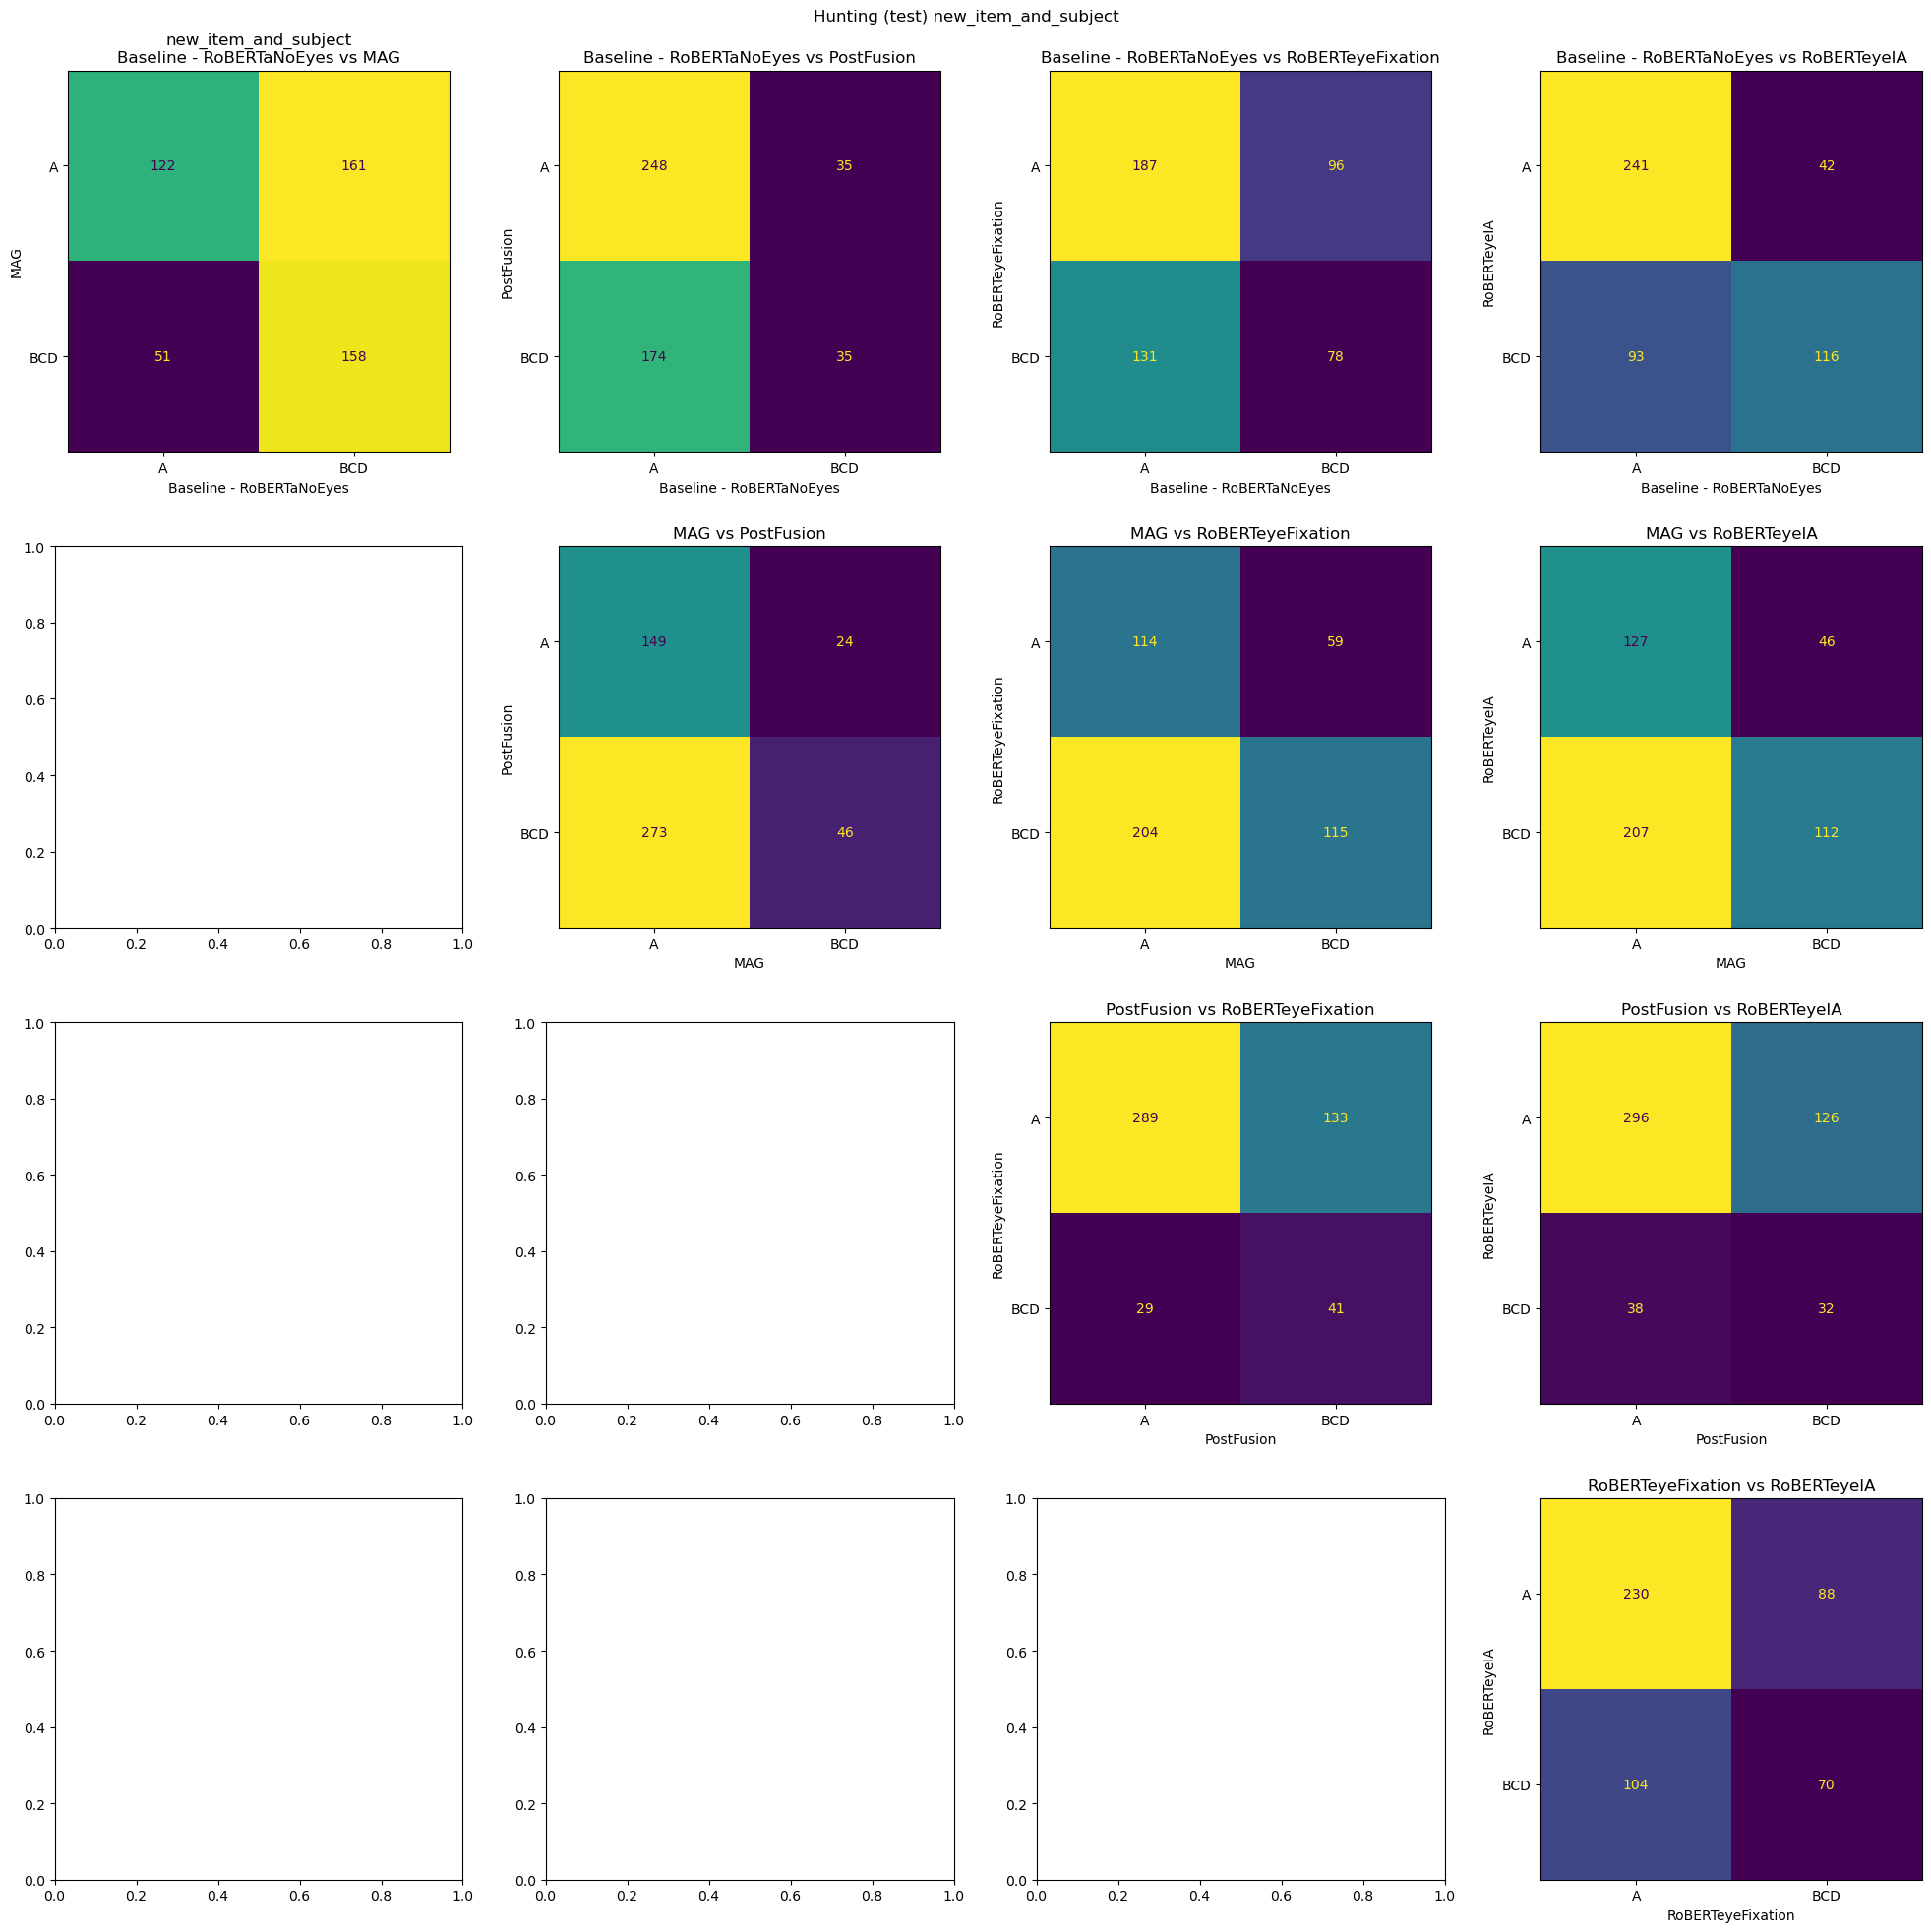

Data: Gathering
i=0 model1='Baseline - RoBERTaNoEyes', j=1 MAG
i=0 model1='Baseline - RoBERTaNoEyes', j=2 PostFusion
i=0 model1='Baseline - RoBERTaNoEyes', j=3 RoBERTeyeFixation
i=0 model1='Baseline - RoBERTaNoEyes', j=4 RoBERTeyeIA
i=1 model1='MAG', j=2 PostFusion
i=1 model1='MAG', j=3 RoBERTeyeFixation
i=1 model1='MAG', j=4 RoBERTeyeIA
i=2 model1='PostFusion', j=3 RoBERTeyeFixation
i=2 model1='PostFusion', j=4 RoBERTeyeIA
i=3 model1='RoBERTeyeFixation', j=4 RoBERTeyeIA


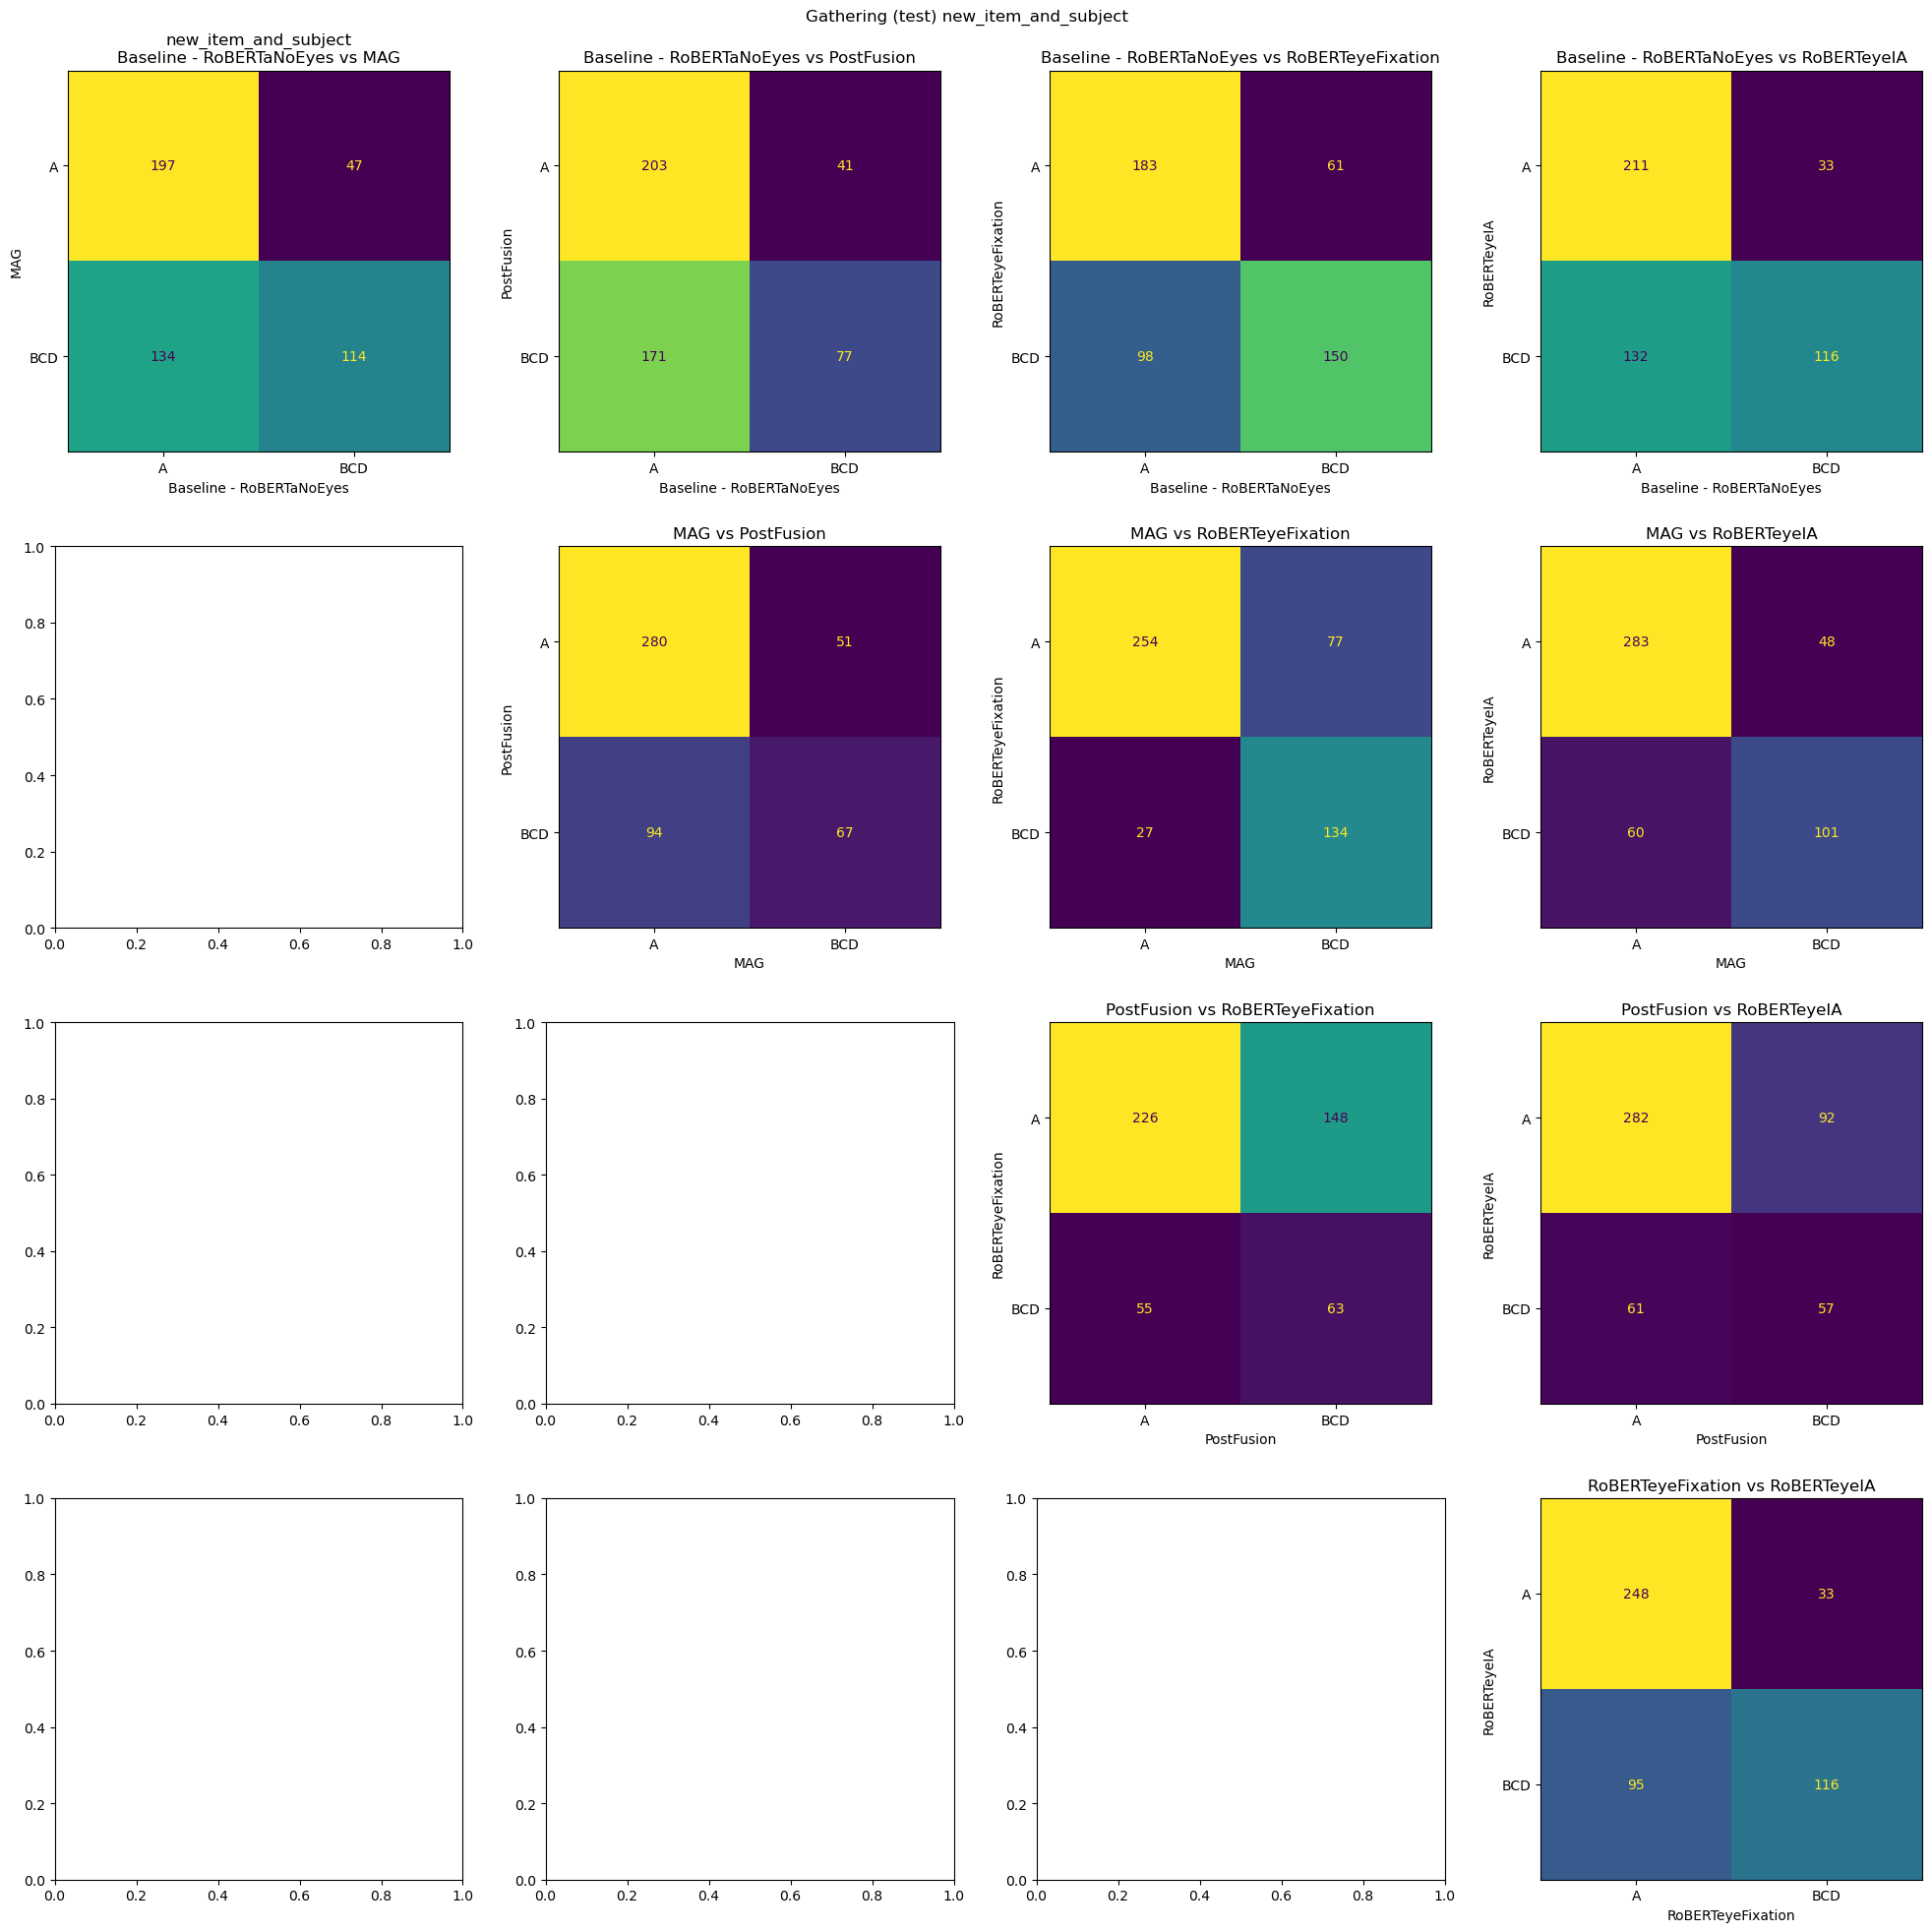

Data: Hunting
i=0 model1='Baseline - RoBERTaNoEyes', j=1 MAG
i=0 model1='Baseline - RoBERTaNoEyes', j=2 PostFusion
i=0 model1='Baseline - RoBERTaNoEyes', j=3 RoBERTeyeFixation
i=0 model1='Baseline - RoBERTaNoEyes', j=4 RoBERTeyeIA
i=1 model1='MAG', j=2 PostFusion
i=1 model1='MAG', j=3 RoBERTeyeFixation
i=1 model1='MAG', j=4 RoBERTeyeIA
i=2 model1='PostFusion', j=3 RoBERTeyeFixation
i=2 model1='PostFusion', j=4 RoBERTeyeIA
i=3 model1='RoBERTeyeFixation', j=4 RoBERTeyeIA


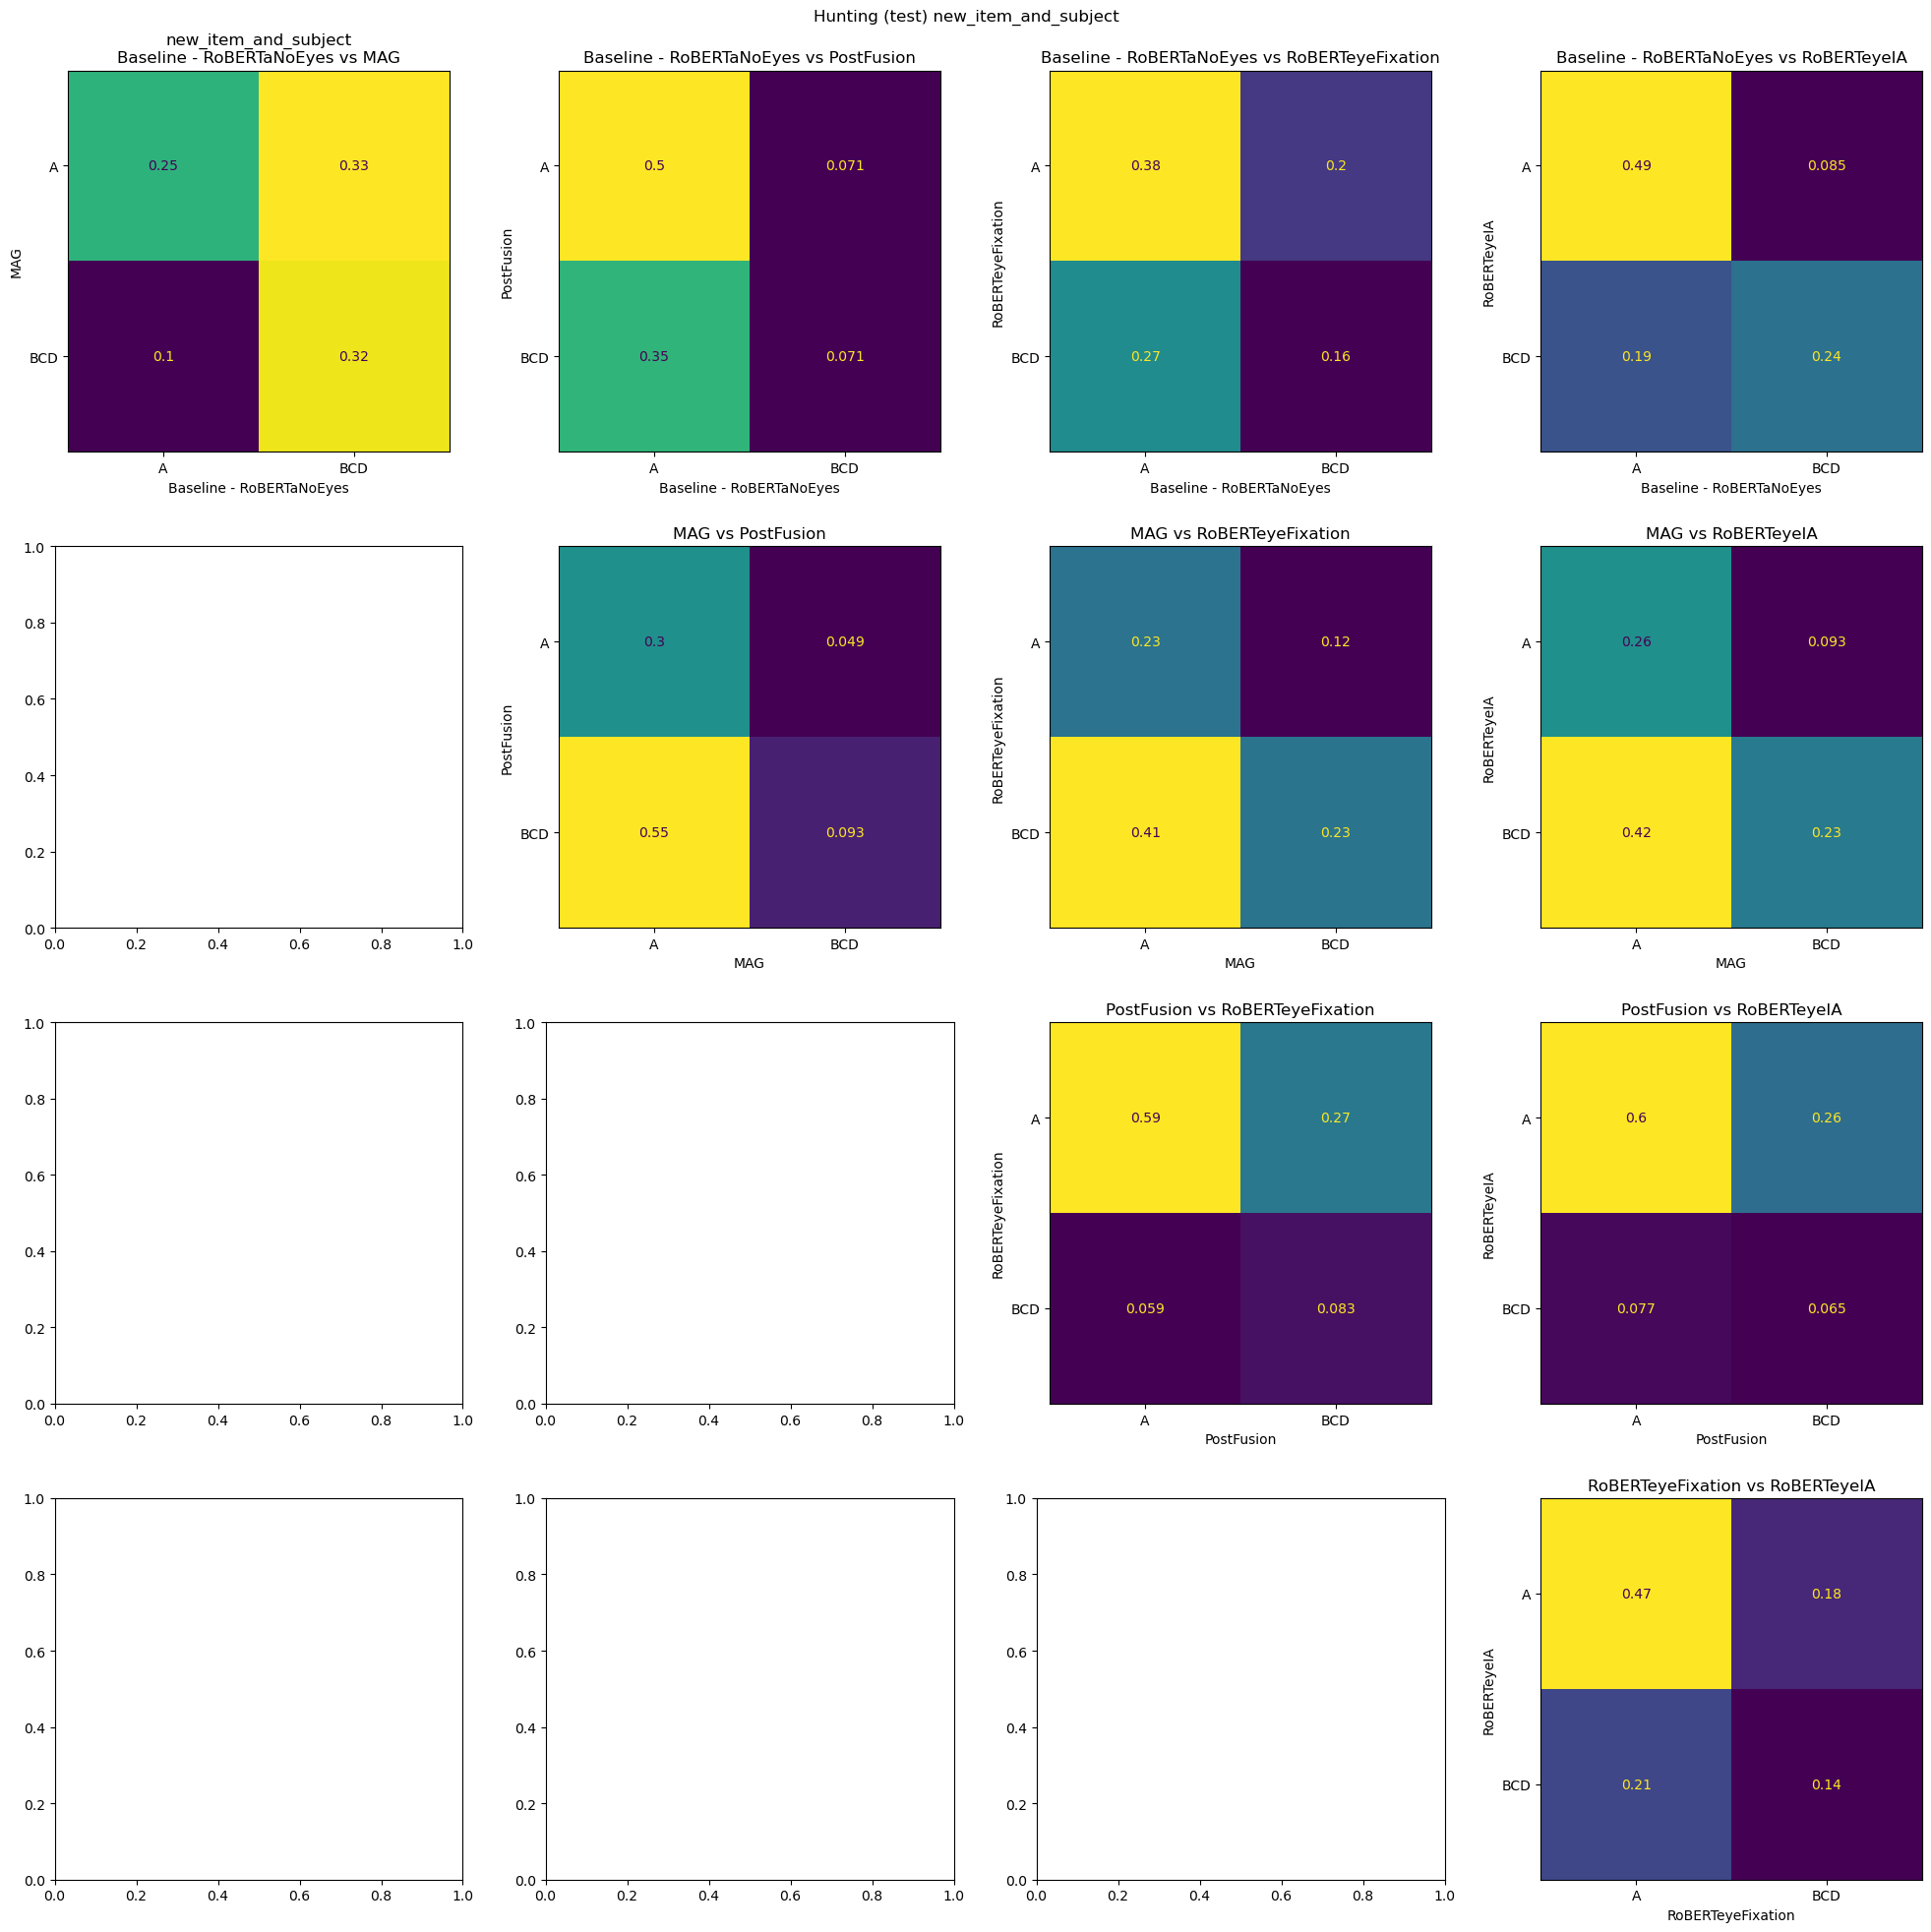

Data: Gathering
i=0 model1='Baseline - RoBERTaNoEyes', j=1 MAG
i=0 model1='Baseline - RoBERTaNoEyes', j=2 PostFusion
i=0 model1='Baseline - RoBERTaNoEyes', j=3 RoBERTeyeFixation
i=0 model1='Baseline - RoBERTaNoEyes', j=4 RoBERTeyeIA
i=1 model1='MAG', j=2 PostFusion
i=1 model1='MAG', j=3 RoBERTeyeFixation
i=1 model1='MAG', j=4 RoBERTeyeIA
i=2 model1='PostFusion', j=3 RoBERTeyeFixation
i=2 model1='PostFusion', j=4 RoBERTeyeIA
i=3 model1='RoBERTeyeFixation', j=4 RoBERTeyeIA


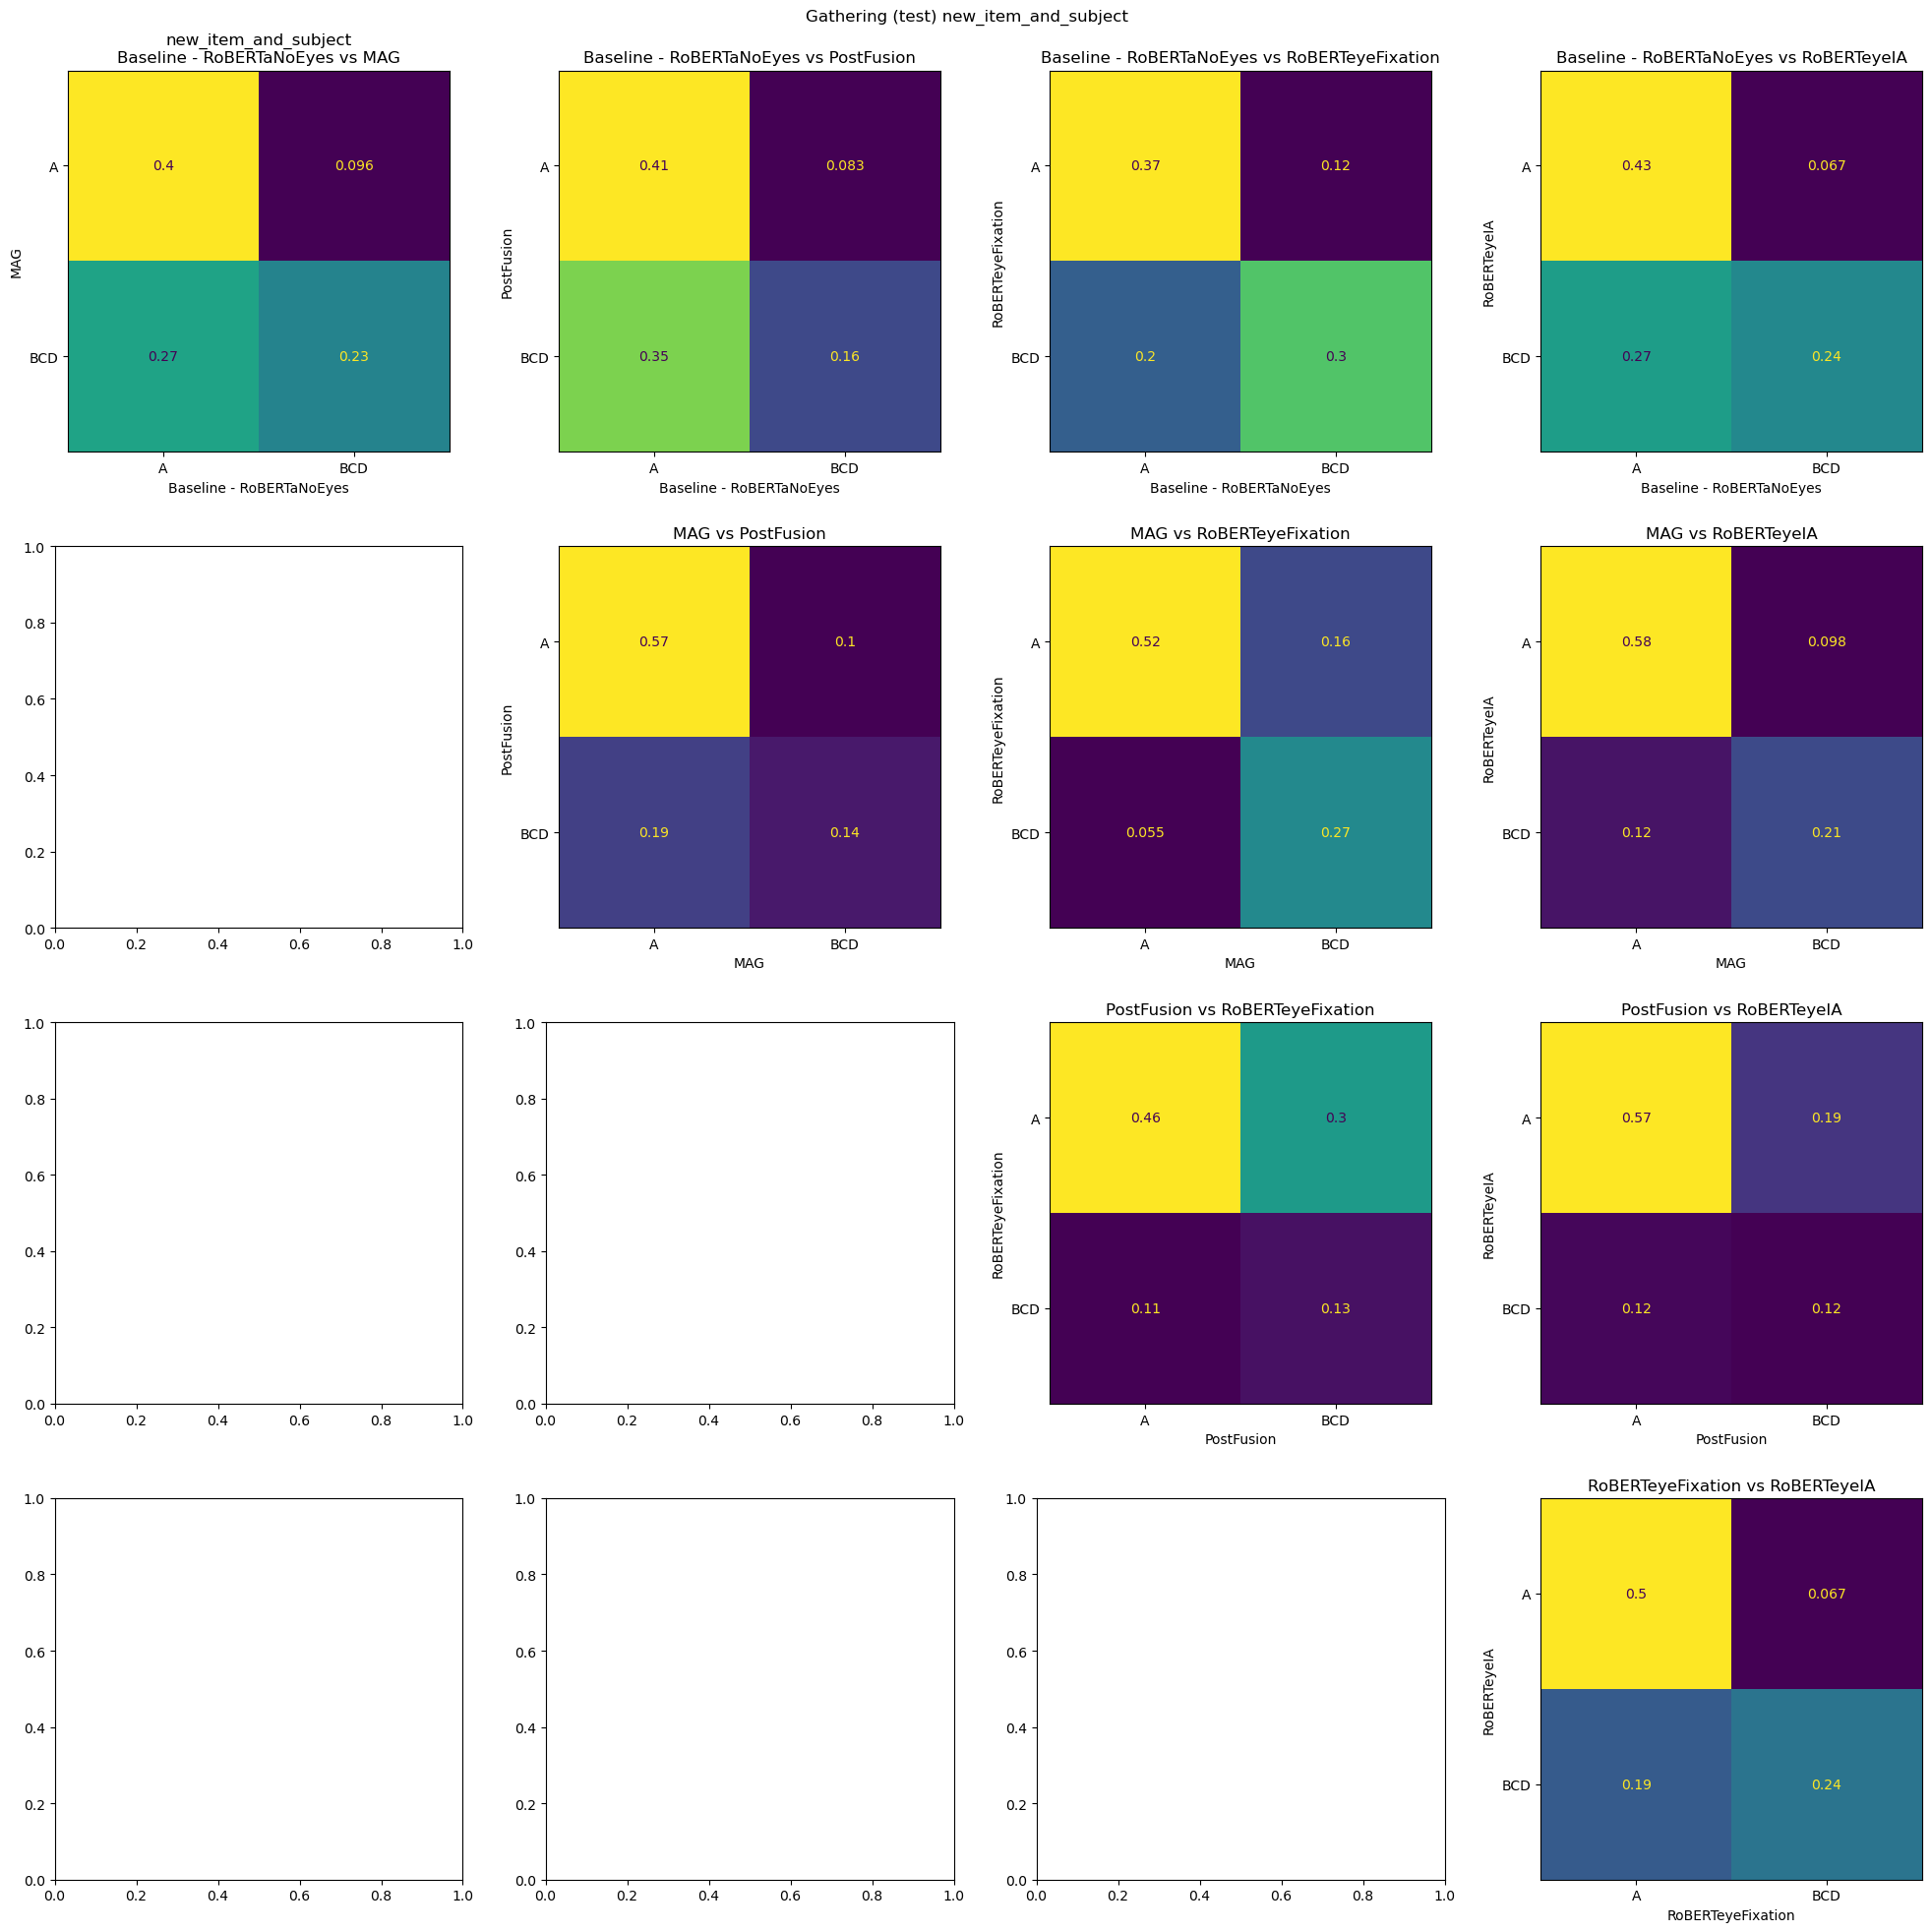

In [11]:
from itertools import combinations

models = [
    "Baseline - RoBERTaNoEyes",
    "MAG",
    "PostFusion",
    "RoBERTeyeFixation",
    "RoBERTeyeIA",
]
label_mappings = [
    # {0: "A", 1: "B", 2: "C", 3: "D"},
    # {0: "A", 1: "BCD", 2: "BCD", 3: "BCD"},
    {1: "A", 0: "BCD"},
]
for eval_type in ["new_item", "new_subject", "new_item_and_subject"]:
    for normalize in [None, "all"]:
        for label_mapping in label_mappings:
            for data_ in ["Hunting", "Gathering"]:
                print(f"Data: {data_}")
                fig, axs = plt.subplots(
                    len(models) - 1,
                    len(models) - 1,
                    figsize=(4 * len(models), 4 * len(models)),
                )
                for (i, model1), (j, model2) in combinations(
                    enumerate(models, start=0), 2
                ):
                    print(f"{i=} {model1=}, {j=} {model2}")
                    res1 = all_res[data_][model1]
                    res2 = all_res[data_][model2]
                    for val_test in ["test", "val"]:
                        if val_test == "val":
                            continue
                        res_val1 = res1[res1["eval_type"] == val_test].copy()
                        res_val2 = res2[res2["eval_type"] == val_test].copy()

                        selected_res1 = res_val1.loc[
                            res_val1["eval_regime"] == eval_type
                        ]
                        selected_res2 = res_val2.loc[
                            res_val2["eval_regime"] == eval_type
                        ]
                        preds1 = [label_mapping[x] for x in selected_res1["y_pred"]]
                        preds2 = [label_mapping[x] for x in selected_res2["y_pred"]]

                        ConfusionMatrixDisplay.from_predictions(
                            y_true=preds1,
                            y_pred=preds2,
                            ax=axs[i, j - 1],
                            colorbar=False,
                            normalize=normalize,
                        )
                        axs[i, j - 1].set_title(
                            f"{eval_type if i == 0 and j==1 else ''}\n{model1} vs {model2}"
                        )
                        axs[i, j - 1].set_xlabel(model1)
                        axs[i, j - 1].set_ylabel(model2)
                plt.suptitle(f"{data_} (test) {eval_type}\n")
                plt.tight_layout()
                plt.show()

Data: Hunting (test), Label Mapping: {1: 'A', 0: 'BCD'}, Normalize: None


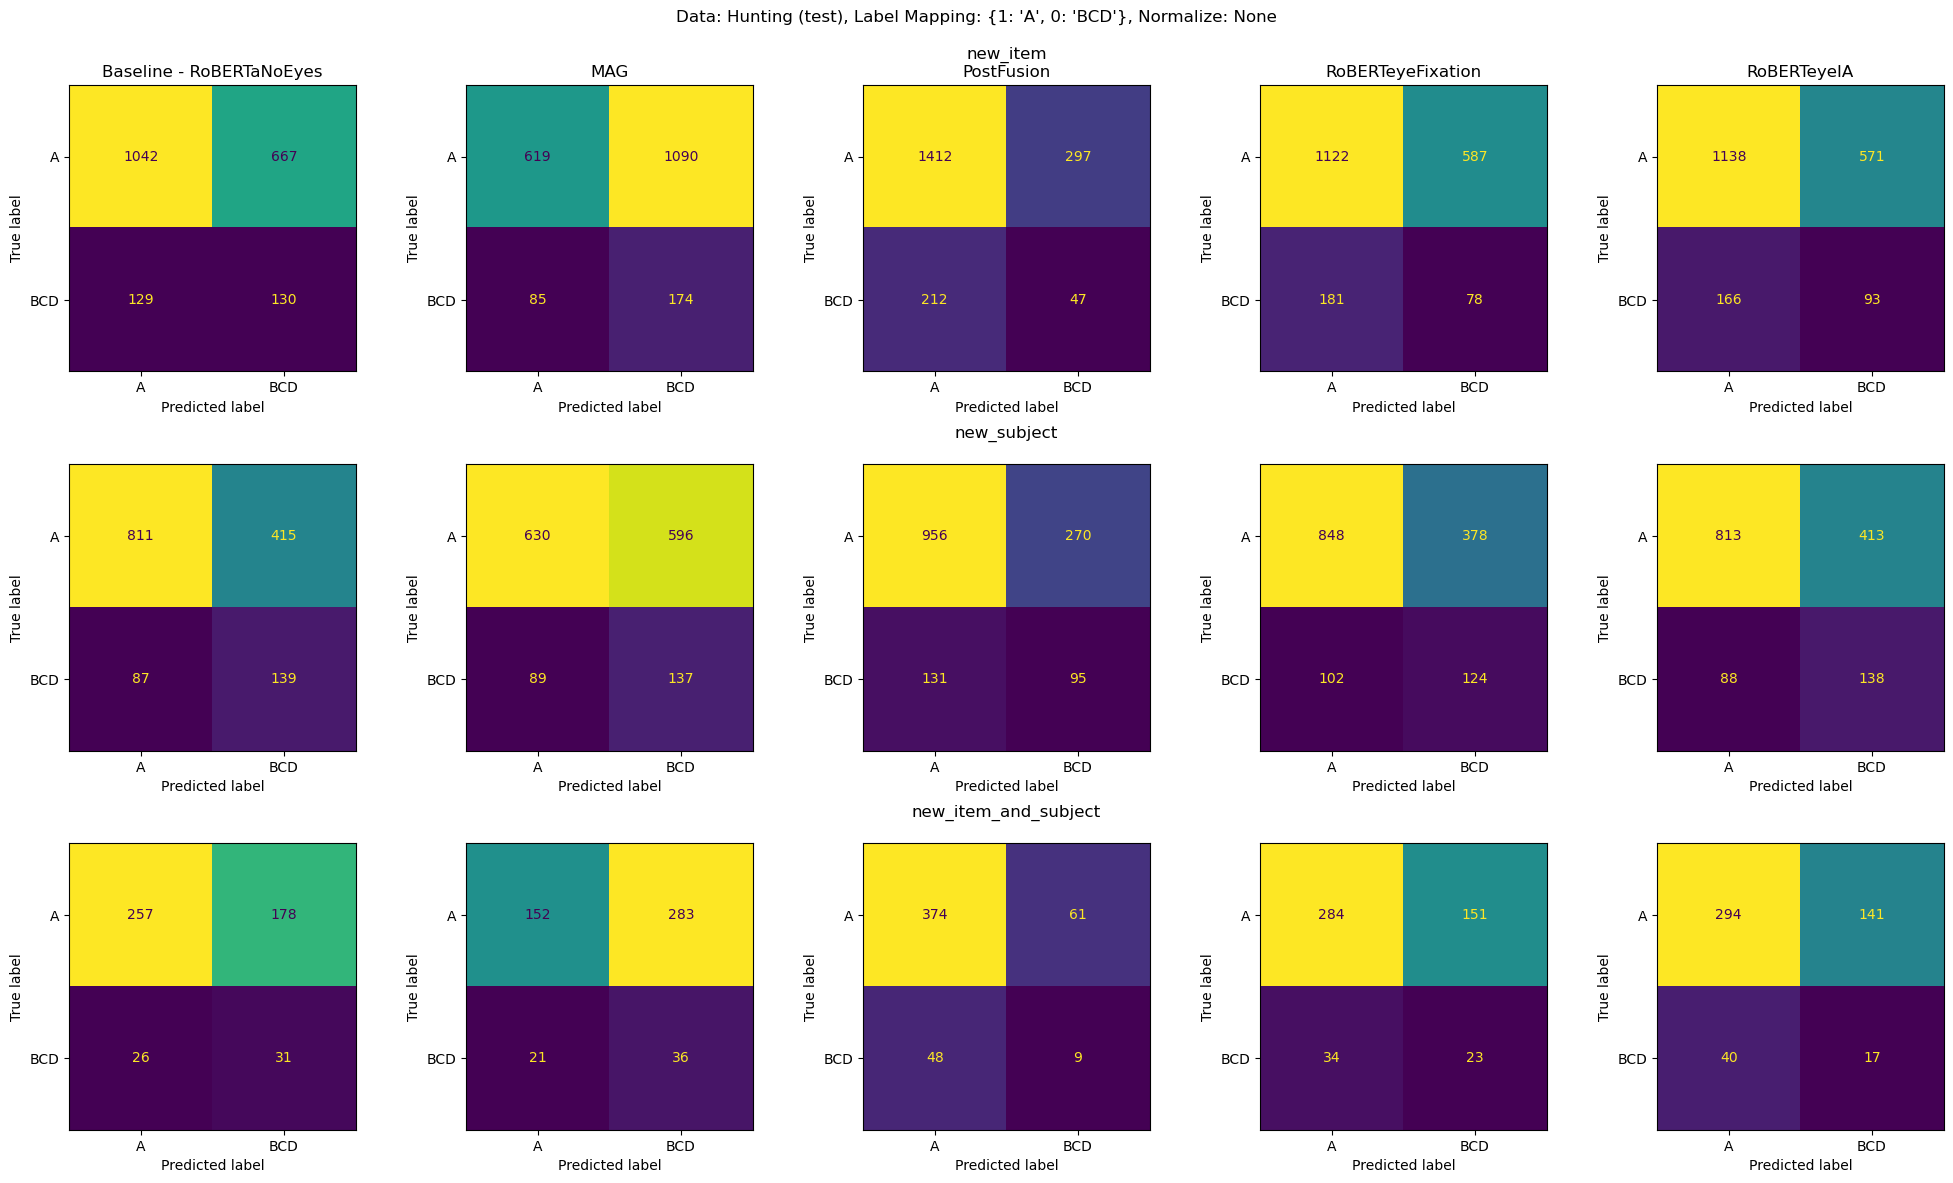

Data: Gathering (test), Label Mapping: {1: 'A', 0: 'BCD'}, Normalize: None


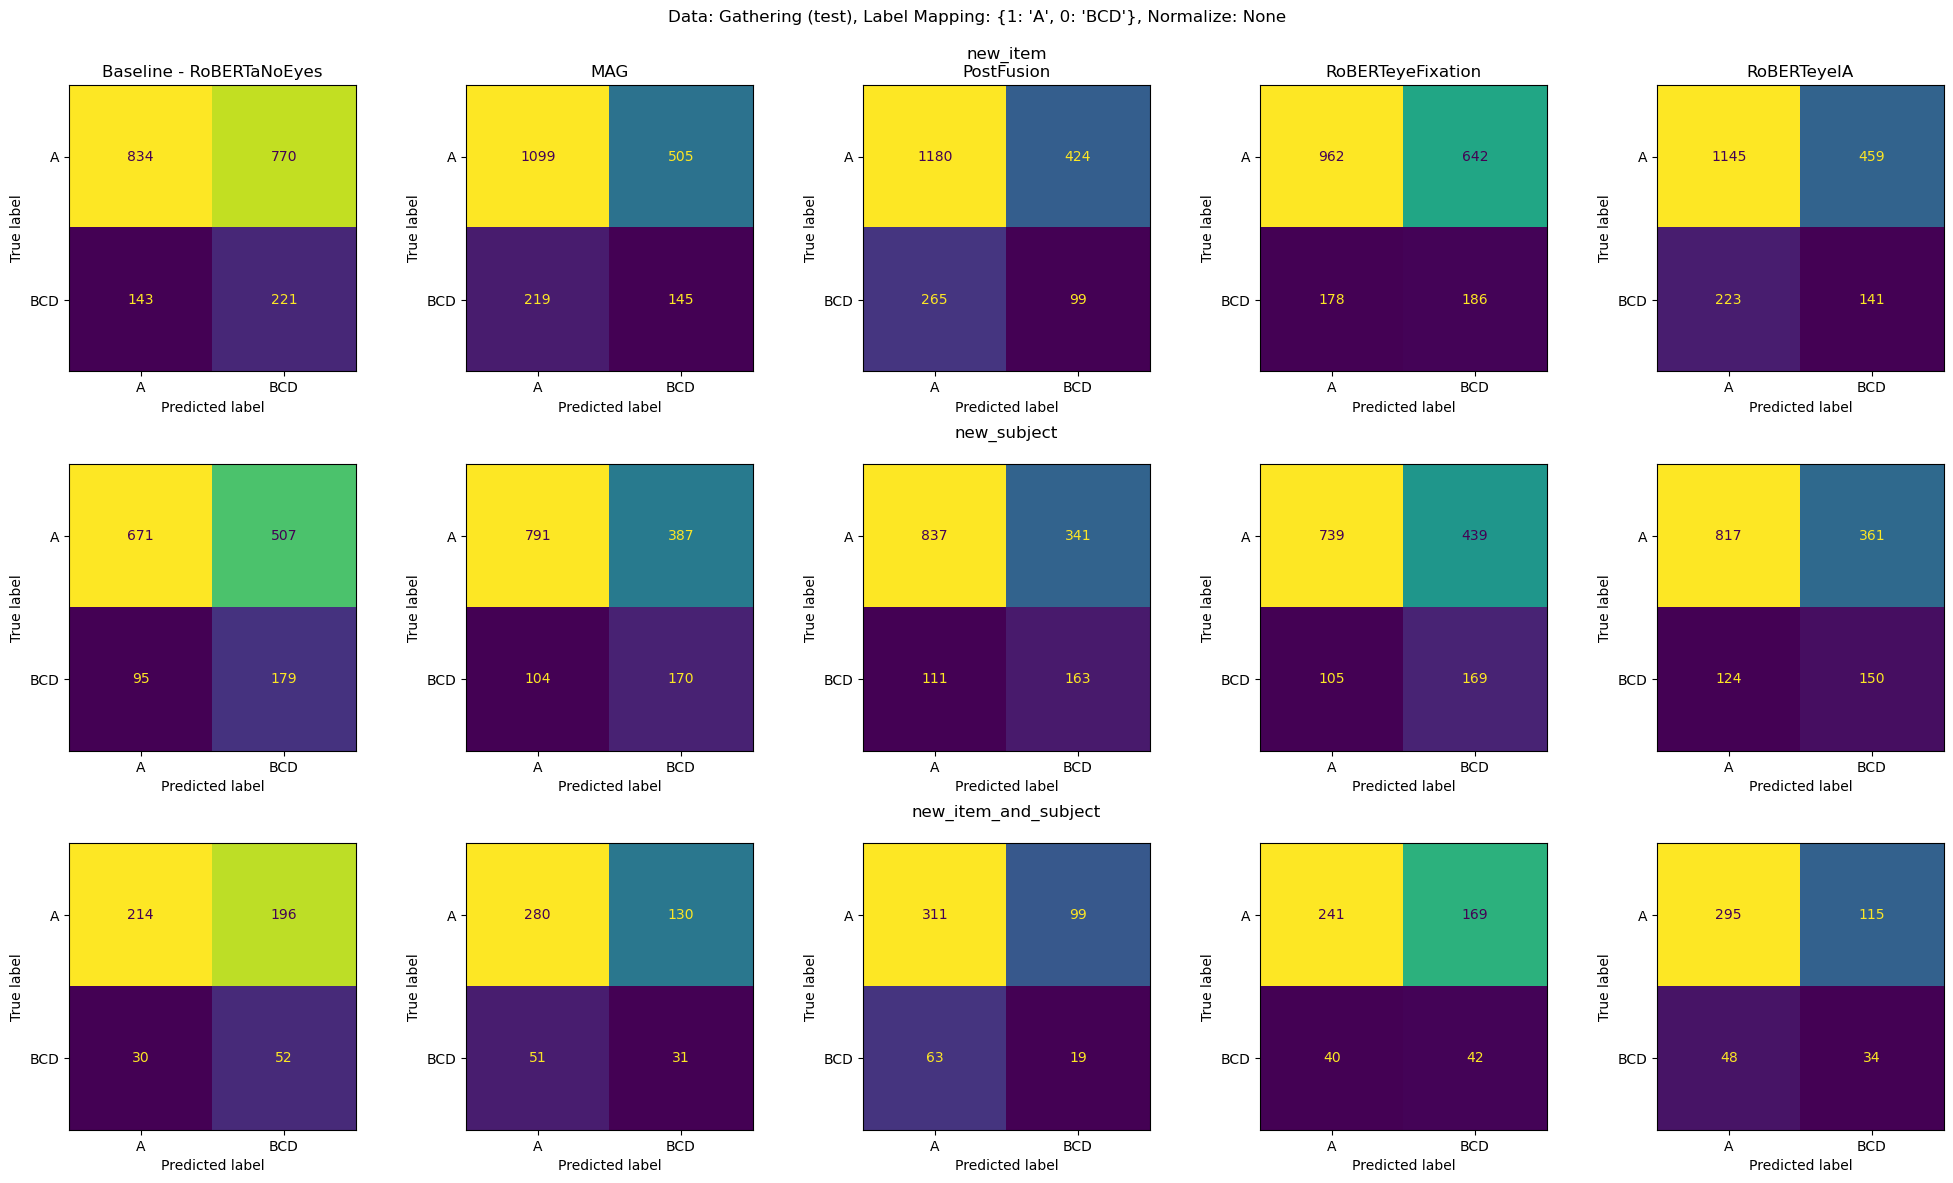

Data: Hunting (test), Label Mapping: {1: 'A', 0: 'BCD'}, Normalize: true


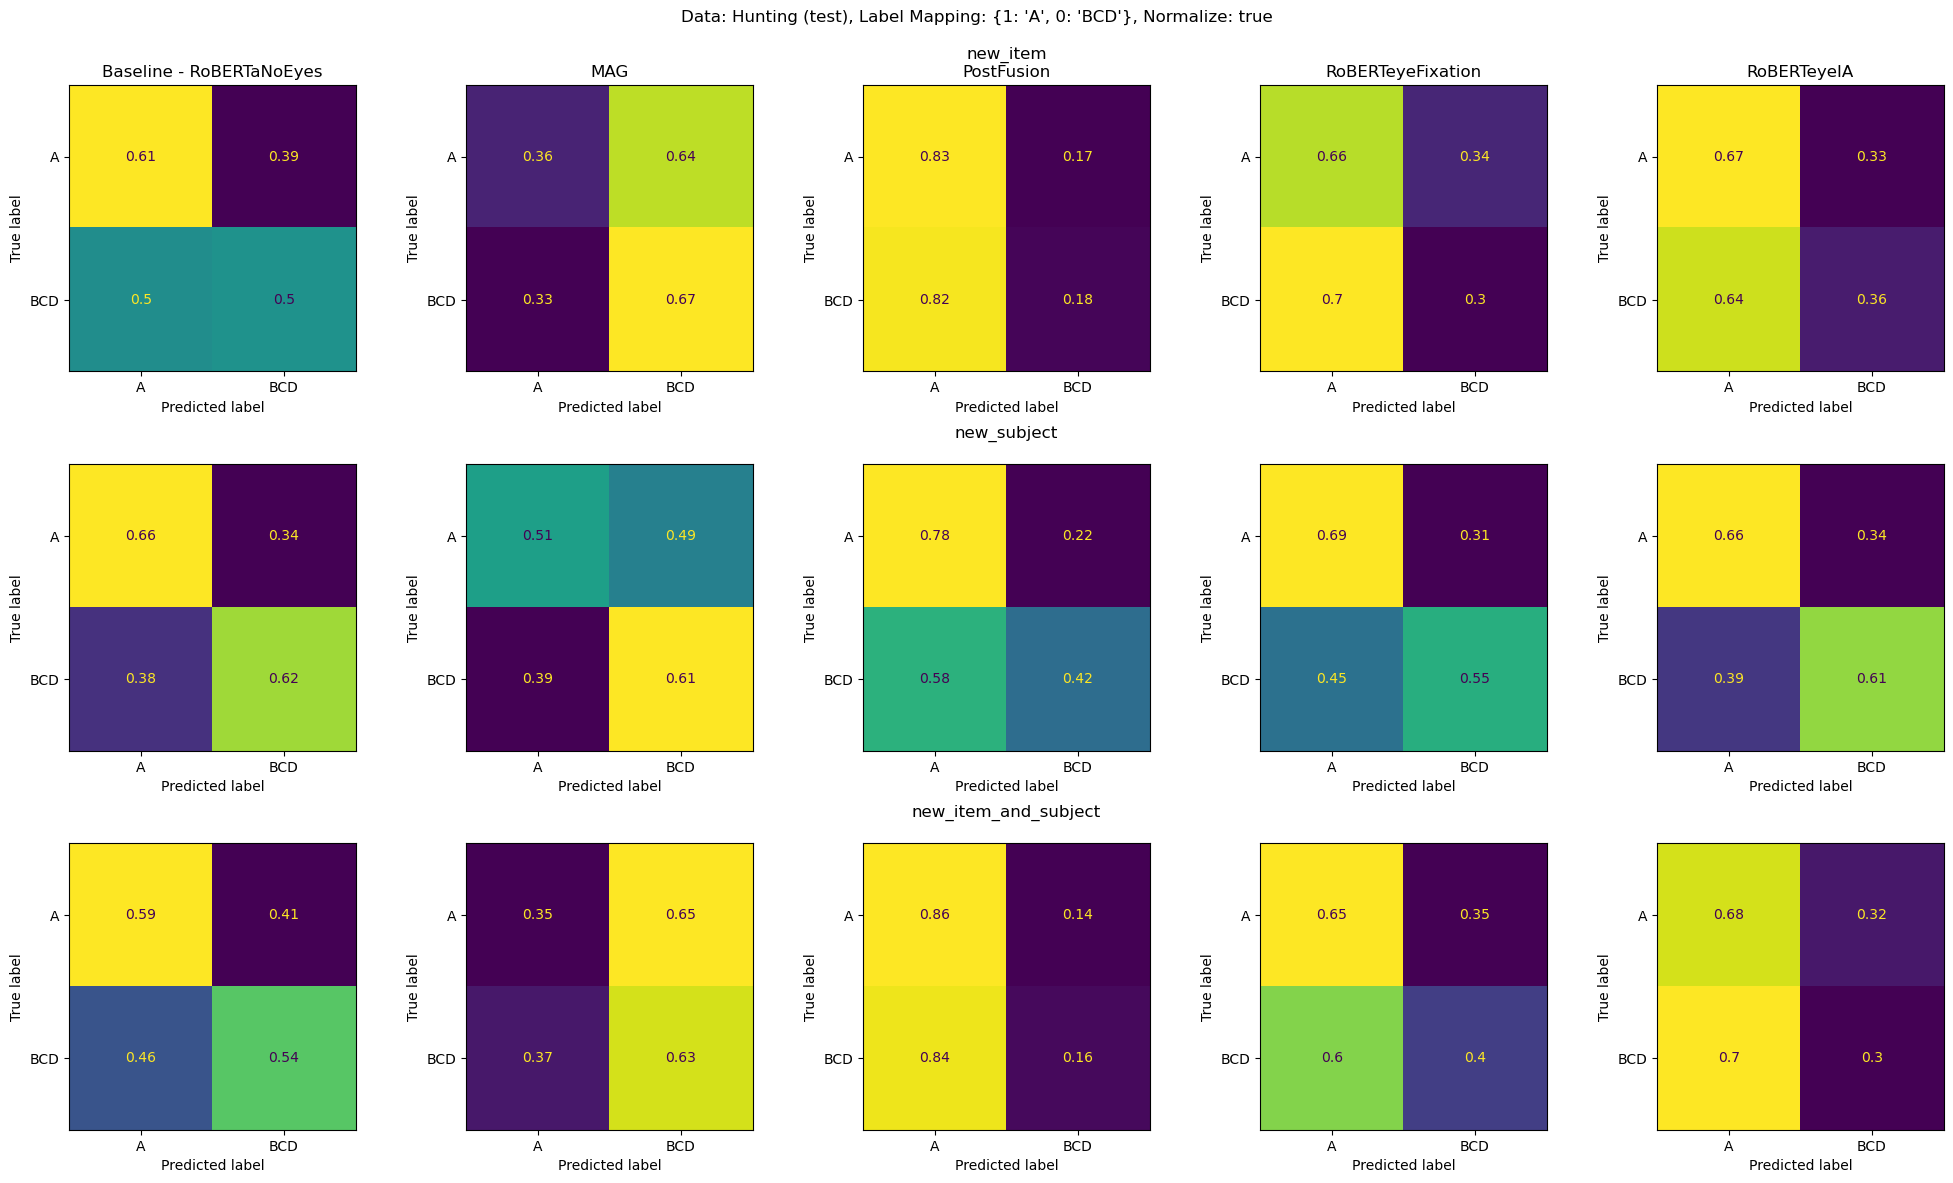

Data: Gathering (test), Label Mapping: {1: 'A', 0: 'BCD'}, Normalize: true


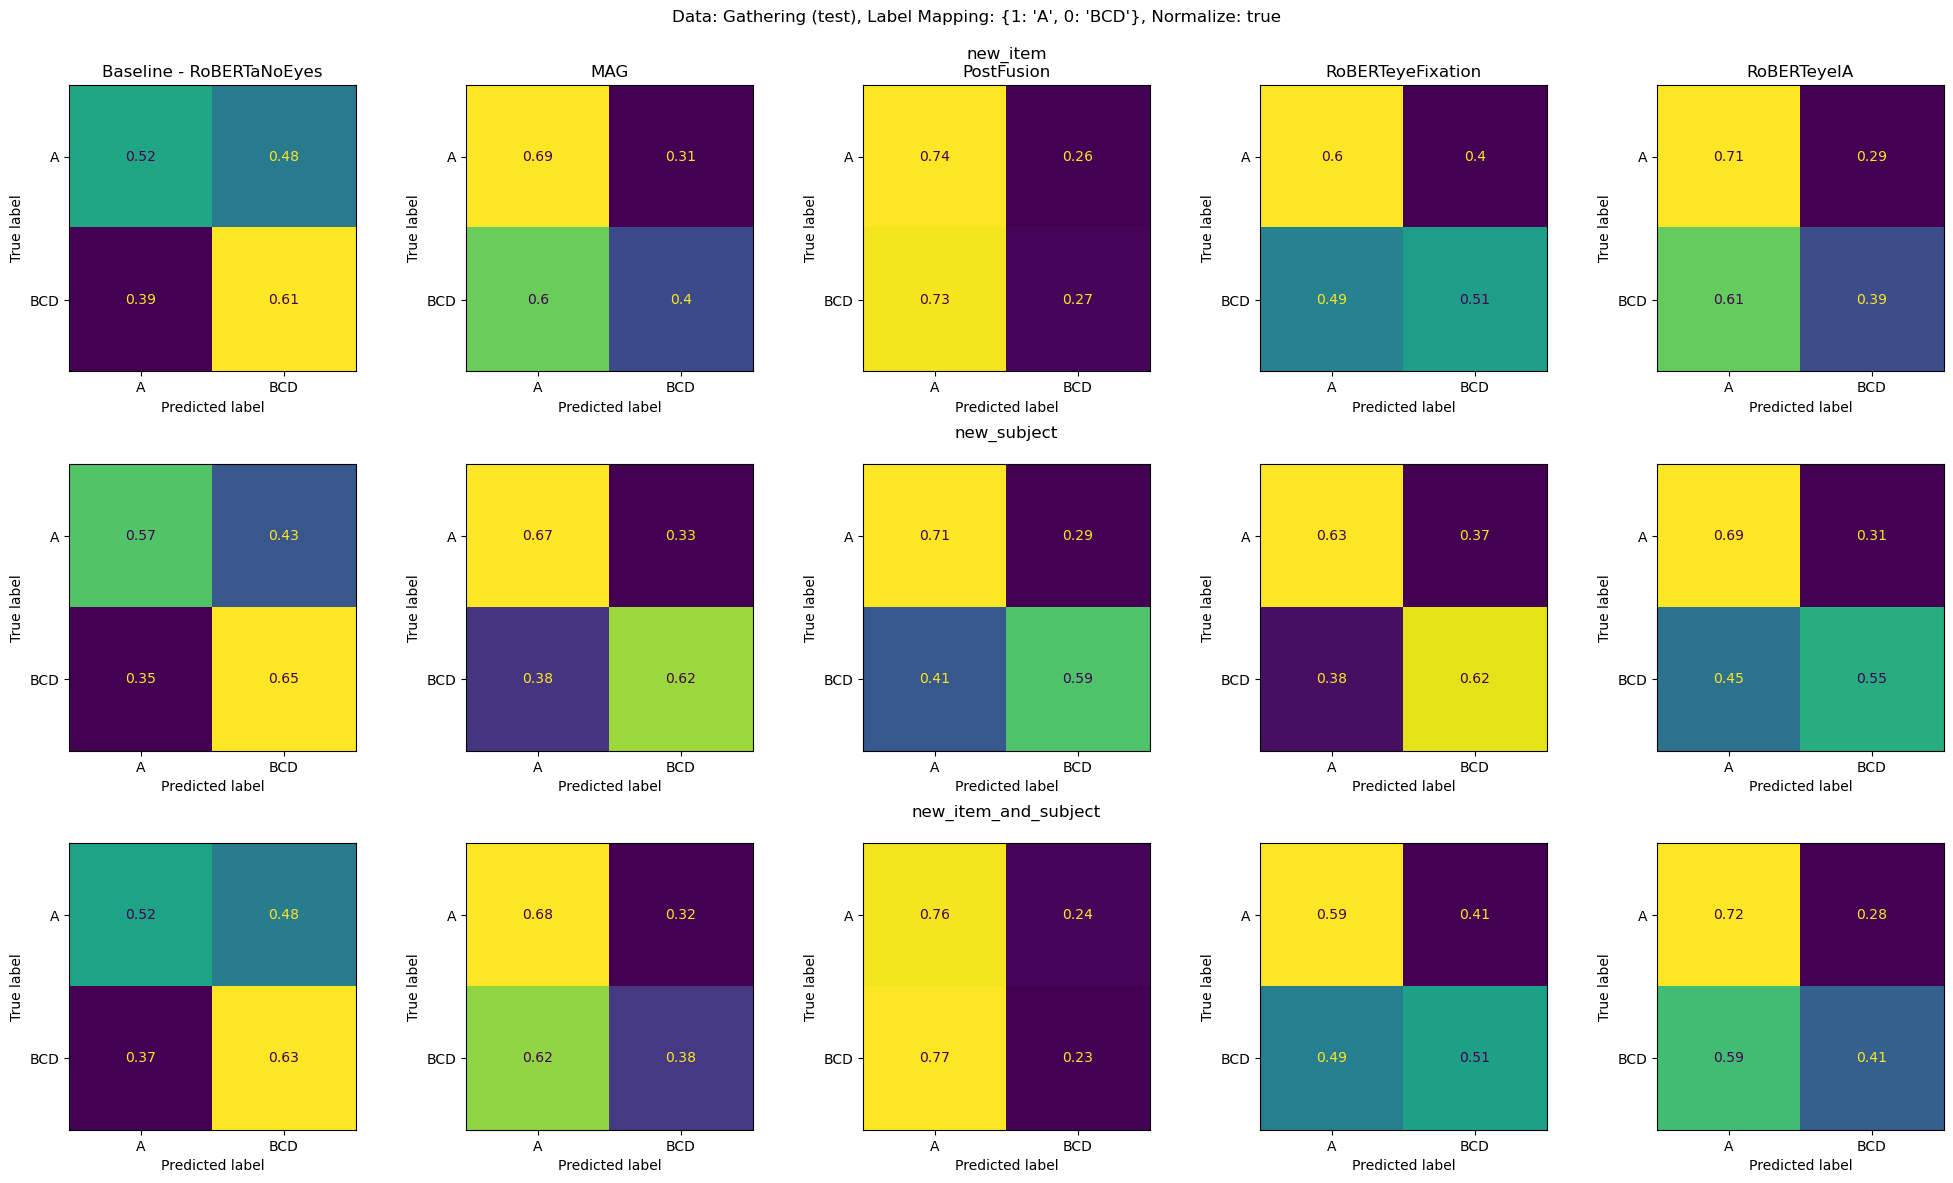

Data: Hunting (val), Label Mapping: {1: 'A', 0: 'BCD'}, Normalize: None


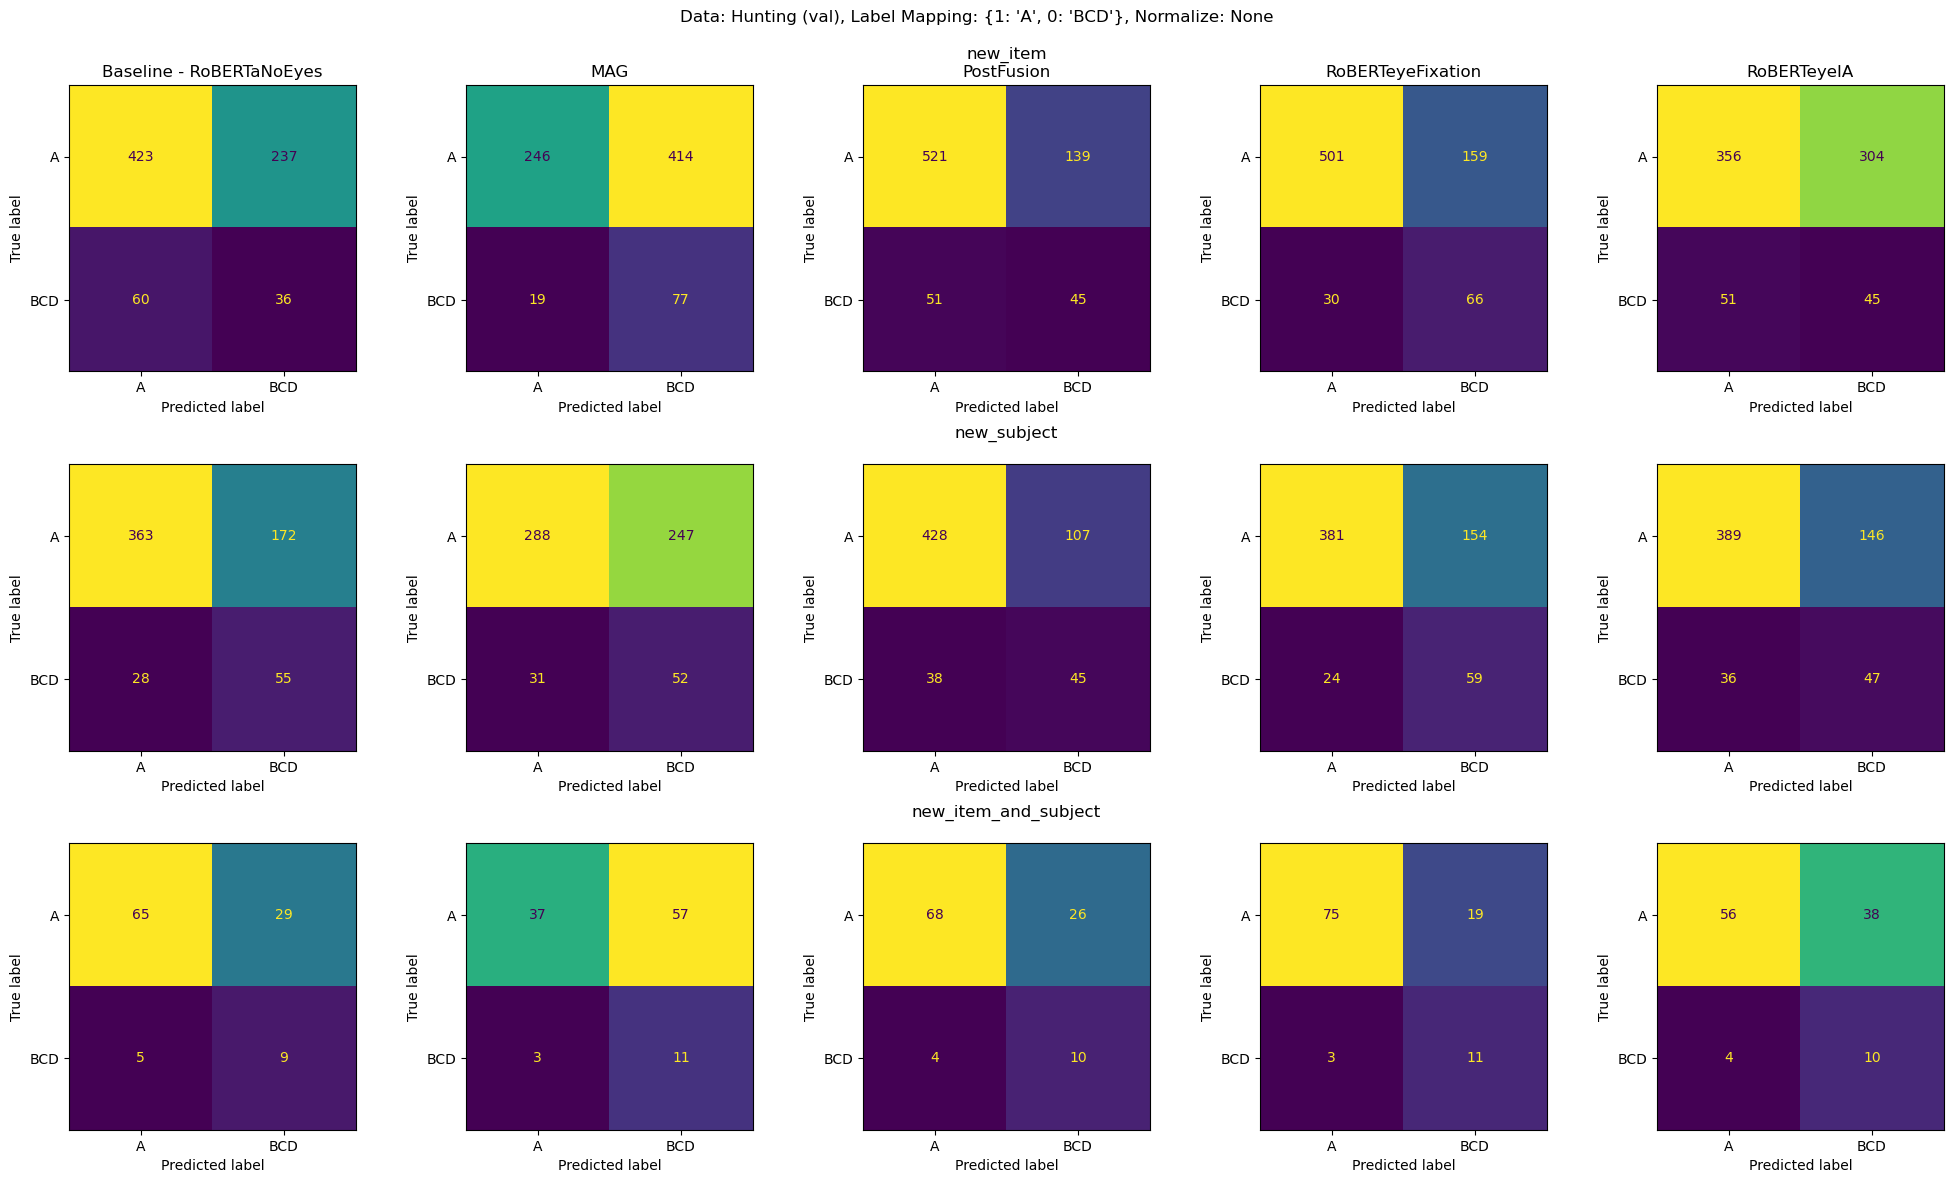

Data: Gathering (val), Label Mapping: {1: 'A', 0: 'BCD'}, Normalize: None


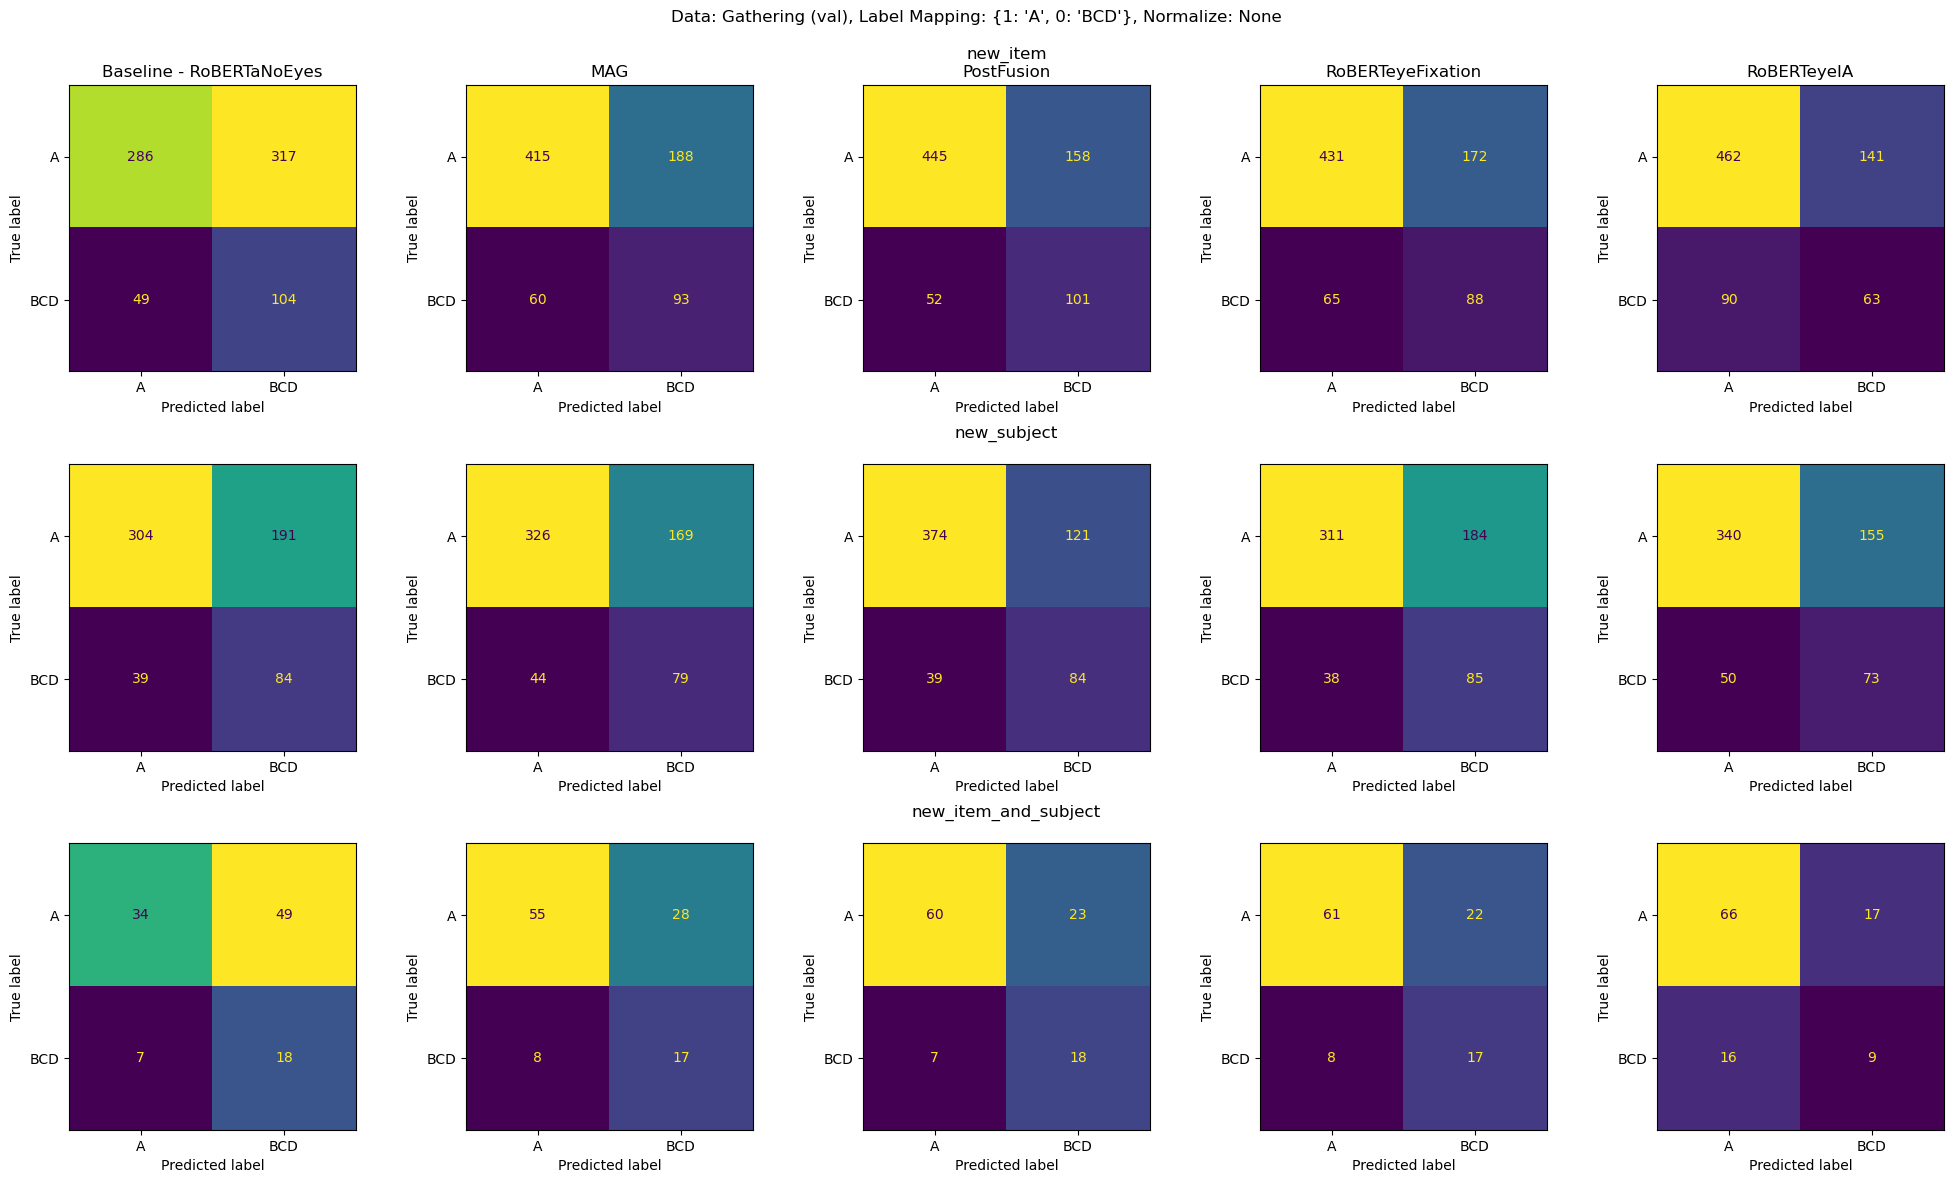

Data: Hunting (val), Label Mapping: {1: 'A', 0: 'BCD'}, Normalize: true


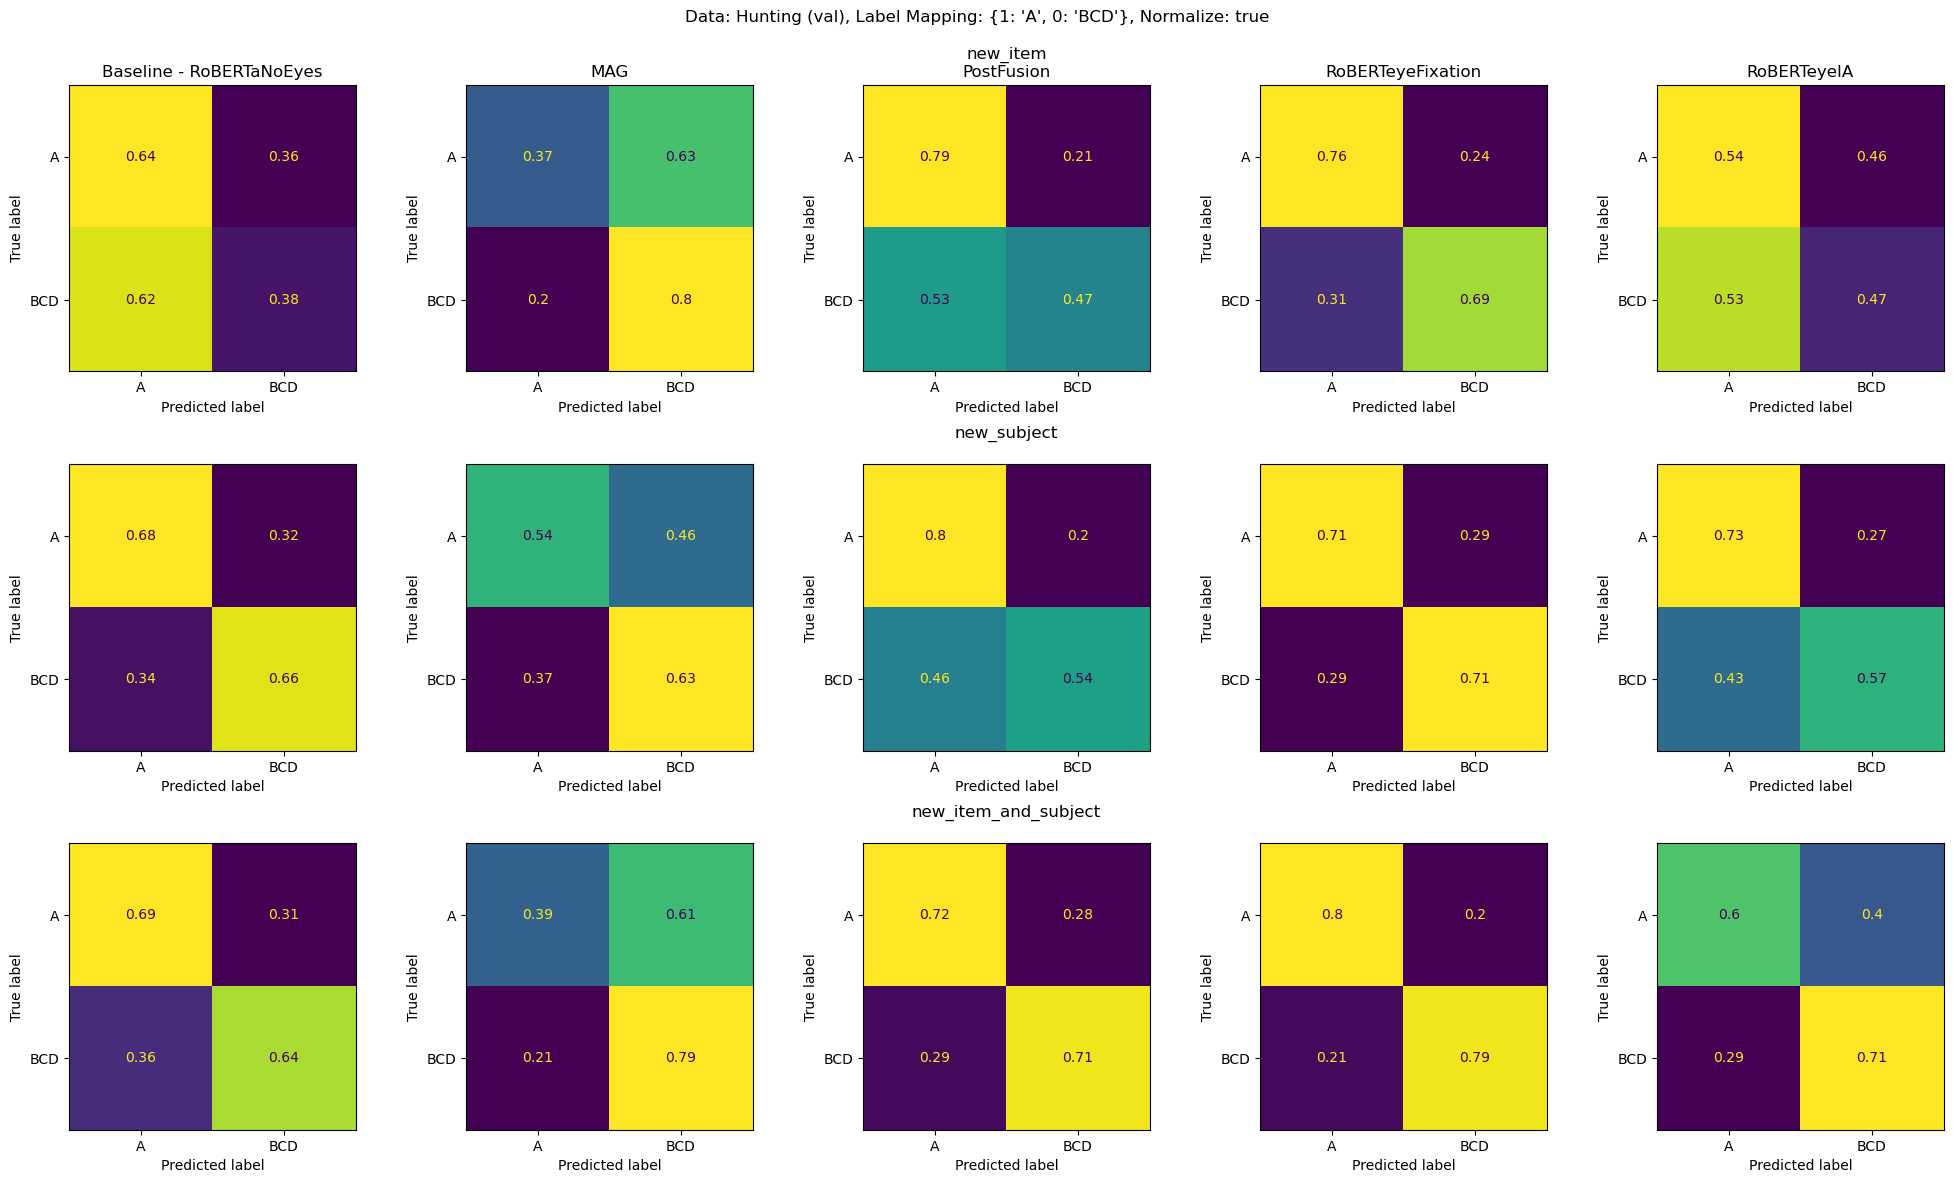

Data: Gathering (val), Label Mapping: {1: 'A', 0: 'BCD'}, Normalize: true


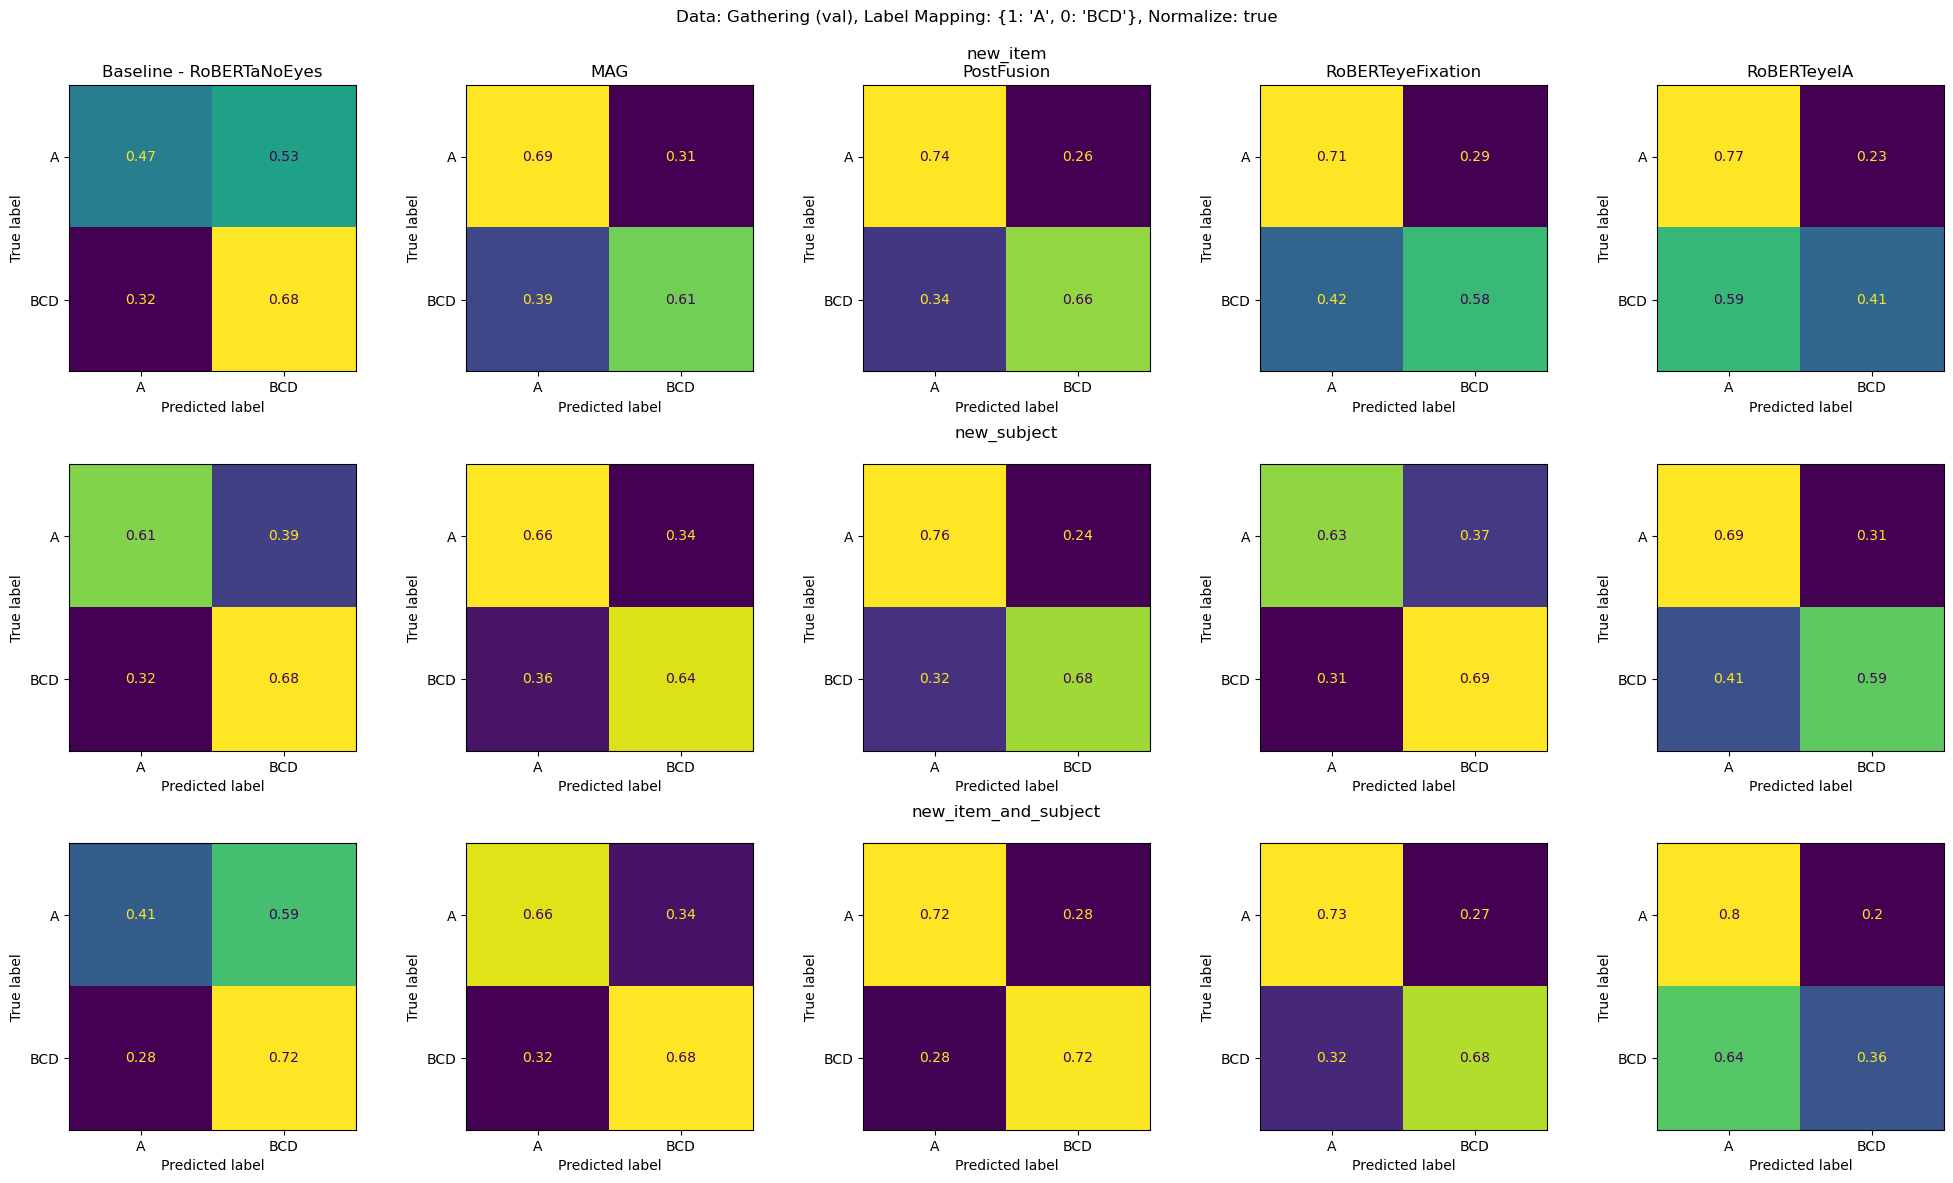

In [10]:
models = [
    "Baseline - RoBERTaNoEyes",
    "MAG",
    "PostFusion",
    "RoBERTeyeFixation",
    "RoBERTeyeIA",
]

label_mappings = [
    # {0: "A", 1: "B", 2: "C", 3: "D"},
    # {0: "A", 1: "BCD", 2: "BCD", 3: "BCD"},
    {1: "A", 0: "BCD"},
]
for val_test in ["test", "val"]:
    for normalize in [None, "true"]:
        for label_mapping in label_mappings:
            for data_ in ["Hunting", "Gathering"]:
                print(
                    f"Data: {data_} ({val_test}), Label Mapping: {label_mapping}, Normalize: {normalize}"
                )
                fig, axs = plt.subplots(3, len(models), figsize=(4 * len(models), 12))
                for i, model in enumerate(models, start=1):
                    res = all_res[data_][model]
                    res_val = res[res["eval_type"] == val_test].copy()

                    for j, eval_type in enumerate(res_val.eval_regime.unique()):
                        selected_res = res_val.loc[res_val["eval_regime"] == eval_type]
                        labels = [
                            label_mapping[x] for x in selected_res["label"].tolist()
                        ]
                        preds = [label_mapping[x] for x in selected_res["y_pred"]]

                        ConfusionMatrixDisplay.from_predictions(
                            y_true=labels,
                            y_pred=preds,
                            ax=axs[j, i - 1],
                            colorbar=False,
                            normalize=normalize,
                        )
                        axs[j, i - 1].set_title(
                            f"{eval_type if i == 3 else ''}\n{model if j == 0 else ''}"
                        )
                plt.suptitle(
                    f"Data: {data_} ({val_test}), Label Mapping: {label_mapping}, Normalize: {normalize}\n"
                )
                plt.tight_layout()
                plt.show()

In [49]:
import wandb

sweep_path = "lacc-lab/emnlp24/"

sweeps = [
    "czf5t5gb",
    "13yyx3nd",
    "buxlqj9j",
    "67cbe2hg",
    "tmerr2hg",
    "pp9zq8z5",
    "jacc6rqr",
    "ca4gpyo5",
    "p8ntm5ik",
    "4agemtuy",
    "t1q33s5y",
    "26p3dxvd",
    "7bhuapeo",
    "h4dzfd60",
    "kyt685zg",
    "afy7z2yf",
    "2kqz3xye",
    "pm0hyq3y",
    "mpr7nsv3",
    "ii8qnf2t",
]


api = wandb.Api()
lrs = []
dropouts = []
for sweep in sweeps:
    sweep = api.sweep(sweep_path + sweep)
    best_run = (
        sweep.best_run()
    )  # when no metric is specified, the default is the sweep's goal metric
    dropouts.append(best_run.config["model"]["model_params"]["eye_projection_dropout"])
    lrs.append(best_run.config["trainer"]["learning_rate"])
    print(
        best_run.config["model"]["model_params"]["eye_projection_dropout"],
        best_run.config["trainer"]["learning_rate"],
    )

wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.3 1e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.1 3e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.5 1e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average
wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.5 3e-05
0.5 3e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.1 1e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.1 1e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.1 3e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average
wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.3 3e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.5 1e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.5 1e-05
0.5 1e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average
wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.3 3e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.3 3e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.3 3e-05
0.1 1e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.5 1e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.1 3e-05


wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average
wandb: Sorting runs by -summary_metrics.Balanced_Accuracy/val_best_epoch_weighted_average


0.3 1e-05
0.1 3e-05


In [51]:
dropouts

[0.3,
 0.1,
 0.5,
 0.5,
 0.5,
 0.1,
 0.1,
 0.1,
 0.3,
 0.5,
 0.5,
 0.5,
 0.3,
 0.3,
 0.3,
 0.1,
 0.5,
 0.1,
 0.3,
 0.1]